# Timeseries Feature Generation & Selection
In this notebook we show how one can create and select features specifically for time series modelling.  
There are some places in which you can explore alternative solutions, and try to find an even better solution yourself.  

The notebook contains the following parts:
 1. **Setup**: Here we setup and verify the environment (mainly data directory and imports)
 1. **Data load**: Now we load the data, and show some statistics
 1. **Feature generation**: Derive features to allow better models
 1. **Defining evaluation**: Define our objective/cost function, and train/validate/test sets.
 1. **Model tuning**: Determine a model which performs best given the features
 1. **Selecting features**: Choose other features, such that the model generalizes better
 1. **Final score on the test set**: After all our tuning, get the final score on the testset

---
## 1 - Setup

### Folders

Here we define the directory holding the dataset, this folder should contain the `soi.dat` and `recruit.dat` datasets:

In [1]:
datafolder = "../data"

Determining wether the folder holds the expected data files:

In [2]:
import os
has_soi = sum([name.endswith("soi.dat") for name in os.listdir(datafolder)])
has_recruit = sum([name.endswith("recruit.dat") for name in os.listdir(datafolder)])

And telling you if the folder is correct:

In [3]:
if (has_soi and has_recruit):
    print 'You are ready to go'
else:
    print 'Your current directory is:'
    print os.getcwd()
    print 'And found the following files in the "{}" directory:'.format(datafolder)
    print os.listdir(datafolder)
    print ''
if not has_soi:
    print 'You are missing soi.dat'
if not has_recruit:
    print 'You are missing recruit.dat'
assert (has_soi and has_recruit)

You are ready to go


### Imports
We have placed all imports at the beginning to not clutter the other cells.
Any failed import means you probably aren't running in the correct kernel. 
Please verify you are using 'Python [conda env:meetup_ds_timeseris]', which can be created using `conda env create -f environment.yml`

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
#%load_ext autoreload
#%autoreload 1
#%aimport bdranalytics
import bdranalytics
import pandas as pd
import numpy as np
import scipy as sc
import seaborn as sns
from scipy.ndimage.interpolation import shift
import sklearn
from sklearn import linear_model, model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import make_scorer, r2_score
from sklearn.metrics.scorer import r2_scorer, mean_squared_error_scorer
import statsmodels
import statsmodels.tsa.api as sm
from bdranalytics.model_selection.growingwindow import GrowingWindow
from bdranalytics.pandaspipeline.transformers import PdFeatureChain, PdFeatureUnion, PdWindowTransformer, PdLagTransformer
from IPython.display import display
import IPython
print "IPython version: {}".format(IPython.__version__)
print "statsmodels: {}".format(statsmodels.__version__)
print "numpy: {}".format(np.__version__)
print "scipy: {}".format(sc.__version__)
print "sklearn: {}".format(sklearn.__version__)
print "pandas: {}".format(pd.__version__)

/Users/gerben/anaconda3/envs/bdranalytics/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


IPython version: 5.3.0
statsmodels: 0.8.0
numpy: 1.13.1
scipy: 0.19.1
sklearn: 0.18.2
pandas: 0.20.3


---
## 2 - Data load

Here we load the two datasets, `soi.dat` and `recruit.dat`.
 - `soi.dat` holds the Southern Oscillation Index Data, which is is the difference in barometric pressure at sea level between Tahiti and Darwin. This is related to the El Nino / El Nina effect.
 - `recruit.dat` holds new fish recruitment

In [5]:
X_orig = pd.read_csv(os.path.join(datafolder, "soi.dat"), header=0, names=["soi"])
rng=pd.date_range('1/1/1866', periods=X_orig.size, freq='MS')
X_orig = X_orig.set_index(rng)
y_orig = pd.read_csv(os.path.join(datafolder, "recruit.dat"), header=0, names=["recruit"]).set_index(rng).iloc[:,0]

### Some information about the data set

To following cells show you some (basic) information about the dataset

In [6]:
print "The soi dataset is used as features, and is {} rows by {} columns".format(X_orig.shape[0], X_orig.shape[1])
print "The recruit dataset holds the target value, and is a series of {} rows".format(y_orig.shape[0])
print "The first few rows, combining the features with the target, looks as follows:"
print X_orig.join(y_orig).head()
print "Some quantile statistics about the range of values:"
print X_orig.join(y_orig).describe()

The soi dataset is used as features, and is 452 rows by 1 columns
The recruit dataset holds the target value, and is a series of 452 rows
The first few rows, combining the features with the target, looks as follows:
                       soi  recruit
1866-01-01 00:00:00  0.246    68.63
1866-02-01 00:00:00  0.311    68.63
1866-03-01 00:00:00  0.104    68.63
1866-04-01 00:00:00 -0.016    68.63
1866-05-01 00:00:00  0.235    68.63
Some quantile statistics about the range of values:
              soi     recruit
count  452.000000  452.000000
mean     0.079381   62.248695
std      0.382915   28.006504
min     -1.000000    1.720000
25%     -0.182750   39.597500
50%      0.115000   68.625000
75%      0.366000   86.860000
max      1.000000  100.000000


Let us now show how the timeseries look through time:

/Users/gerben/anaconda3/envs/bdranalytics/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


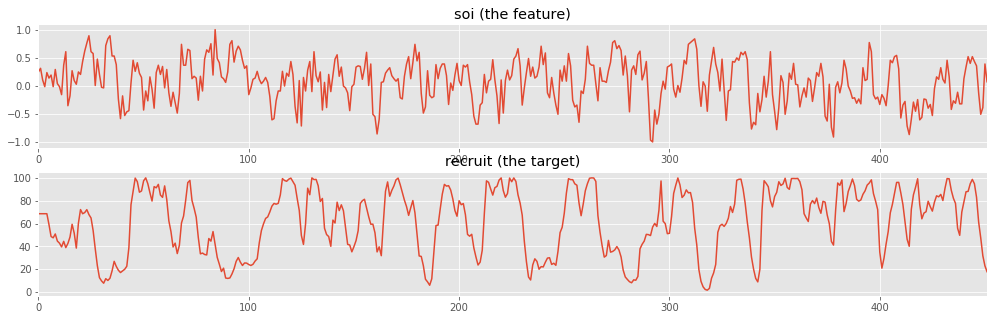

In [7]:
fig, ax = plt.subplots(figsize=(17, 5), ncols=1, nrows=2)
ax[0].set_title("soi (the feature)")
fig1 = sns.tsplot(X_orig.soi, ax=ax[0])
ax[1].set_title("recruit (the target)")
fig2 = sns.tsplot(y_orig, ax=ax[1])

### Defining the target variable
Instead of predicting the *current* recruit, we will attempt to predict the *next* recruit. Therefore we shift the `y_orig` by `-1` to get the value of 1 time ahead.

Note that this will result in a NaN value on the last index, which we therefore remove.

In [8]:
y = y_orig.shift(-1).dropna() # the next recruit

### Defining the base features
Currently we only have the `soi` feature as dataset. As we also know the *current* `soi` value, we add that to X.

As we have one less value of `y` (we don't know the next value at the last row), we subselect only the `X` features for which we have a predictable future `recruit` value.

In [9]:
X = pd.concat([X_orig,  # the original features: the current soi
               y_orig.to_frame() # the current recruit
              ], axis=1, join_axes=[X_orig.index]).loc[y.index,:]

---
## 3 - Feature generation

Now we have a set of features `X`, and a target sequence `y`.
We will now enrich the dataset by with additional features to allow better predictions on `y`. The final set of features will be assigned to the variable `X`.

This uses a sklearn transformer `PdLagTransformer` which will be explained in the next section

### Add derived features
Given this first version of X, we can add new features. In general, you can add transformations of the colums, using for example :
  * http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shift.html
  * http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html
  
To simplify the application of such transformations, we have created a few helper transformers, which work nicely with sklearn's pipelines:
  * `PdLagTransformer(lag)`: This transforms the columns by adding a 'lagged' version. The constructor argument defines the lag to apply. This uses `pandas.DataFrame.shift` to shift the columns. The returned transformation however, also has modified column names. A column `soi`, if shifted `1`, will be transformed into a column named `soi_lag1`.
  * `PdWindowTransformer(function, window)`: This transforms the column using a `rolling`. All constructor arguments are passed through to `pandas.DataFrame.rolling`. In general, one usually provides a `function`, and a `window`. The `window` defines the number of previous values to take, and then applies the provided `function` to those values.

The sklearn `FeatureUnion` and `Pipeline` unfortunately drop the column names when pandas dataframes are passed to them. Therefore we've also made pandas versions:
 * `PdFeatureUnion`: Same as sklearn's `FeatureUnion`, but propagates column names of the contained transformers.  
 The sklearn's `FeatureUnion` always returns a `numpy` `array`, without column labels.  
 Our `PdFeatureUnion` always returns a `pandas` `DataFrame`, propagating the column labels of the contained transformers.  
 If the applied transformer does not return a `pandas` `DataFrame` (thus no column labels), column labels are generated using the format `transformername-index`. For example, `PdFeatureUnion([(feat,MyTransformer())])` will generate column labels like `feat-1` and `feat-2` if the `MyTransformer`'s `transform()` function returns a numpy array.
 * `PdFeatureChain`: Similar to sklearn's `Pipeline`, applies subsequent transformers to each other result.  
 Thus `PdFeatureChain( [ ('f1', MyFirstTransformer()), ('f2', MySecondTransformer()) ] )` will apply `MySecondTransformer.transform` on the result of `MyFirstTransformer.transform`.

### Recommended solution for feature generation: create lagged windows
One way to create a lot of features, is to first create different windows, and then apply different lags to those windows. As we already have lags of single moments, and windows ending at the current time, we here only add lagged windows. To prevent too many overlapping windows, we use a stepsize of the lag which is equal to the window size.

In [10]:
window_transformers = PdFeatureUnion([
        ('window{}'.format(window), PdWindowTransformer(lambda x: x.mean(), window=window)) for window in range(1, 12)
    ])
lag_transformers = PdFeatureUnion([
        ('lag{}'.format(lag), PdLagTransformer(lag)) for lag in range(20)])

new_features = [
    ('chain{}'.format(window),
     PdFeatureChain([
        ('window{}'.format(window), PdWindowTransformer(lambda x: x.mean(), window=window)),
        ('lags', PdFeatureUnion([('lag{}'.format(lag), PdLagTransformer(lag)) for lag in range(window, 20, window)]))
        ])
     )
     for window in range(2, 12, 2)]
combined_features = PdFeatureUnion(
    [('window{}'.format(window), PdWindowTransformer(lambda x: x.mean(), window=window)) for window in range(1,12)]
    + 
    [('lag{}'.format(lag), PdLagTransformer(lag)) for lag in range(20)]
    + new_features
    )

### Selecting usefull rows
As the previous examples show, applying lags and windows result in `NaN` values for the first few rows. Let us remove those to only have complete rows.

In [11]:
X_dev = combined_features.fit_transform(X).dropna()
y = y[X_dev.index] # because of dropped rows in X, need to also select corresponding remaining rows from y
X = X.loc[X_dev.index,:]

> ps. You might think, are we allowed to do `fit_transform` on the **complete** dataset?! Yes we are, because we don't have information leakage, because: 
 * the feature only takes into acount previous rows (rows with older timestamps)
 * and our cross validation, explained below, only tests on future rows (rows with more recent timestamps).

---
## 4 - Defining the evaluation
### Defining the test method of the model
With a dataset of features (X), and a target variable (y), let's see how well we can predict the recruit.  
First we define the evaluation metric, and some helper functions to easily get results for cross validation:
 * `model_score` is the function we use to determine the cost
 * `model_scorer` is the same function, wrapped by sklearn to be able to be used by model selectors.
 * `cross_val` determines the cross validated test score, in which the folds are created specifically for timeseries. The data is divided into `cv_count+` splits.   
 The first fold uses split 1 as train set, and split 2 as validation set.  
 The second fold uses split 1 and 2 as train set, and split 3 as validation set.
 The `cv_count`th fold uses split 1 up till `cv_count` as train set, and split `cv_count+1` as validation set.
 * `cross_val_train` determines the cross validated train score. Thus similar to `cross_val`, but returns the train error instead of the validation error.

In [12]:
model_score = mean_squared_error
model_scorer = make_scorer(mean_squared_error, greater_is_better=False)

def cross_val(estimator, X, y, scorer = model_scorer, cv_count=10):
    return model_selection.cross_val_score(estimator, X, y.to_frame(), 
                                           scoring = scorer,
                                           cv=GrowingWindow(cv_count))

## for different folds, trains the model, en returns the error on the **train** sets.
def cross_val_train(estimator, X, y, scorer = model_scorer, cv_count=10):
    return [scorer(estimator.fit(X.iloc[train,:], y.iloc[train]),
                   X.iloc[train,:],
                   y.iloc[train])
             for train, test in GrowingWindow(cv_count).split(X)]

### Selecting a hold out set

First we extract a train & test set from the full dataset

In [13]:
i_train, i_test = list(itertools.islice(GrowingWindow(8).split(X), 6, 7))[0]
X_train = X.iloc[i_train,:]
y_train = y[i_train]

X_test = X.iloc[i_test,:]
y_test = y[i_test]
print "Train datasize dimensions = {}, Test datasets dimensions= {} ".format(X_train.shape, X_test.shape)

Train datasize dimensions = (332, 2), Test datasets dimensions= (48, 2) 


In [14]:
print "The names of the available columns:"
display(X_train.columns)

The names of the available columns:


Index([u'soi', u'recruit'], dtype='object')

---
# Neural network approach

In [15]:
num_series = 1
timesteps = X_train.shape[0]
data_dim = X_train.shape[1]

from sklearn.preprocessing import StandardScaler
x_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train.values.reshape(-1, 1))

In [16]:
X_train_p = x_scaler.transform(X_train).reshape(num_series, timesteps, data_dim)
y_train_p = y_scaler.transform(y_train.values.reshape(-1, 1)).reshape(num_series, timesteps, 1)

In [17]:
print X_train_p.shape
print y_train_p.shape

(1, 332, 2)
(1, 332, 1)


In [18]:
print y_scaler.mean_
print y_scaler.scale_

[ 58.65421705]
[ 29.50997955]


In [19]:
x_scaler.transform(X_train)[0:5,:]

array([[ 1.66291068,  0.46302952],
       [ 2.00151723,  0.31591731],
       [ 1.26743891,  0.21535134],
       [ 1.18214108, -0.16041367],
       [-0.28860034, -0.7002781 ]])

In [20]:
X_train_p[:,0:5,:]

array([[[ 1.66291068,  0.46302952],
        [ 2.00151723,  0.31591731],
        [ 1.26743891,  0.21535134],
        [ 1.18214108, -0.16041367],
        [-0.28860034, -0.7002781 ]]])

In [21]:
import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed, Dropout
from keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau


val_size = 40
i_fit = np.arange(0, timesteps - val_size)

def mse(y_true, y_pred):
    y_true = y_true * y_scaler.scale_ + y_scaler.mean_
    y_pred = y_pred * y_scaler.scale_ + y_scaler.mean_
    return K.mean(K.square(y_true[-val_size:] - y_pred[-val_size:]))

Using TensorFlow backend.


In [21]:
def run1():
    tensor_board = TensorBoard(log_dir="../tensorboardlog/baseline")
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto')

    model = Sequential()
    model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(None, 2)))
    model.add(LSTM(128, return_sequences=True, activation='tanh', dropout=0.5))
    model.add(TimeDistributed(Dense(1, activation='linear')))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[mse])

    model.summary()


    fit = model.fit(X_train_p[:,i_fit,:], y_train_p[:,i_fit,:], epochs=1000,
              validation_data=(X_train_p, y_train_p),
              verbose=2, callbacks=[early_stopping, tensor_board])
    return fit
run1()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 128)         67072     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 1)           129       
Total params: 198,785
Trainable params: 198,785
Non-trainable params: 0
_________________________________________________________________
Train on 1 samples, validate on 1 samples
Epoch 1/1000
1s - loss: 0.9083 - mse: 790.9547 - val_loss: 0.8972 - val_mse: 781.3371
Epoch 2/1000
1s - loss: 0.8545 - mse: 744.1086 - val_loss: 0.8220 - val_mse: 715.8292
Epoch 3/1000
1s - loss: 0.7201 - mse: 627.1072 - val_loss: 0.7449 - val_mse: 648.7037
Epoch 4/1000
1s - loss: 0.6964 - mse: 606.4576 - val_loss: 0.6683 - val_mse: 582.0075
Epoch 5/1000
1

1s - loss: 0.0951 - mse: 82.7767 - val_loss: 0.1048 - val_mse: 91.2785
Epoch 88/1000
1s - loss: 0.0948 - mse: 82.5715 - val_loss: 0.1036 - val_mse: 90.2457
Epoch 89/1000
1s - loss: 0.1124 - mse: 97.9170 - val_loss: 0.1025 - val_mse: 89.2864
Epoch 90/1000
1s - loss: 0.1045 - mse: 90.9808 - val_loss: 0.1004 - val_mse: 87.4332
Epoch 91/1000
1s - loss: 0.0907 - mse: 79.0079 - val_loss: 0.1005 - val_mse: 87.5444
Epoch 92/1000
1s - loss: 0.1184 - mse: 103.1285 - val_loss: 0.0985 - val_mse: 85.7699
Epoch 93/1000
1s - loss: 0.1157 - mse: 100.7416 - val_loss: 0.0955 - val_mse: 83.2083
Epoch 94/1000
1s - loss: 0.1190 - mse: 103.6401 - val_loss: 0.0950 - val_mse: 82.7130
Epoch 95/1000
1s - loss: 0.1210 - mse: 105.4023 - val_loss: 0.0933 - val_mse: 81.2413
Epoch 96/1000
1s - loss: 0.0848 - mse: 73.8514 - val_loss: 0.0930 - val_mse: 81.0007
Epoch 97/1000
1s - loss: 0.0905 - mse: 78.8280 - val_loss: 0.0918 - val_mse: 79.9519
Epoch 98/1000
1s - loss: 0.0947 - mse: 82.4417 - val_loss: 0.0896 - val_mse

1s - loss: 0.0502 - mse: 43.7044 - val_loss: 0.0372 - val_mse: 32.4369
Epoch 184/1000
1s - loss: 0.0363 - mse: 31.5982 - val_loss: 0.0381 - val_mse: 33.2090
Epoch 185/1000
1s - loss: 0.0477 - mse: 41.5755 - val_loss: 0.0385 - val_mse: 33.5367
Epoch 186/1000
1s - loss: 0.0430 - mse: 37.4745 - val_loss: 0.0389 - val_mse: 33.9146
Epoch 187/1000
1s - loss: 0.0484 - mse: 42.1331 - val_loss: 0.0386 - val_mse: 33.6459
Epoch 188/1000
1s - loss: 0.0347 - mse: 30.2259 - val_loss: 0.0387 - val_mse: 33.7303
Epoch 189/1000
1s - loss: 0.0385 - mse: 33.4922 - val_loss: 0.0397 - val_mse: 34.5716
Epoch 190/1000
1s - loss: 0.0775 - mse: 67.5116 - val_loss: 0.0392 - val_mse: 34.1039
Epoch 191/1000
1s - loss: 0.0421 - mse: 36.6361 - val_loss: 0.0382 - val_mse: 33.2592
Epoch 192/1000
1s - loss: 0.0383 - mse: 33.3505 - val_loss: 0.0376 - val_mse: 32.7001
Epoch 193/1000
1s - loss: 0.0432 - mse: 37.6010 - val_loss: 0.0363 - val_mse: 31.6132
Epoch 194/1000
1s - loss: 0.0452 - mse: 39.3804 - val_loss: 0.0352 - 

In [ ]:
#import tensorflow as tf
#config = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1, \
#                        allow_soft_placement=True, device_count = {'CPU': 1})
#session = tf.Session(config=config)
#K.set_session(session)

# With adaptive learning rate

In [22]:
def run2():
    tensor_board = TensorBoard(log_dir="../tensorboardlog/adaptivelearningrate")
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10, min_lr=1e-4)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=21, verbose=0, mode='auto')

    model = Sequential()
    model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(None, 2)))
    model.add(LSTM(128, return_sequences=True, activation='tanh', dropout=0.5))
    model.add(TimeDistributed(Dense(1, activation='linear')))
    optimizer = keras.optimizers.Adam(lr=3e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[mse])
    model.summary()

    fit = model.fit(X_train_p[:,i_fit,:], y_train_p[:,i_fit,:], epochs=1000,
              validation_data=(X_train_p, y_train_p),
              verbose=2, callbacks=[reduce_lr, early_stopping, tensor_board])
    return fit
run2()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, None, 128)         67072     
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1)           129       
Total params: 198,785
Trainable params: 198,785
Non-trainable params: 0
_________________________________________________________________
Train on 1 samples, validate on 1 samples
Epoch 1/1000
1s - loss: 1.1465 - mse: 998.4250 - val_loss: 5.1012 - val_mse: 4442.3613
Epoch 2/1000
1s - loss: 1.2659 - mse: 1102.3705 - val_loss: 0.7449 - val_mse: 648.6743
Epoch 3/1000
1s - loss: 1.2923 - mse: 1125.3623 - val_loss: 7.9018 - val_mse: 6881.2305
Epoch 4/1000
1s - loss: 6.3767 - mse: 5553.1060 - val_loss: 6.3168 - val_mse: 5500.9170
Epoch 5/

thus in 40 epochs less a 10% improved `val_mse` by using adaptive lr

## iterative


if adding nodes did not improve for this nr of steps, we stop adding nodes:

In [22]:
def assign_weights(model, prev_weights):
    for i in range(min(len(prev_weights), len(model.layers))): # over minimum nr of layers
            old_weights = prev_weights[i]
            curr_weights = model.layers[i].get_weights()
            for j in range(len(curr_weights)): # within layer
                if (curr_weights[j].shape == old_weights[j].shape): # only if shape is equal (else useless)
                    curr_weights[j] = old_weights[j]
            model.layers[i].set_weights(curr_weights) 

note , the reduce_lr and early stopping should collaborate well, in case the  initial lr is way too high, it should have the possibility to be reduced enough before the early stopping kicks in

so initial lr * factor^floor(patience_early_stopping / patience_lr_reduce) should be low enough to always converge
in a few steps : patience_early_stopping % patience_lr_reduce

In [59]:
def run_depth1(width, learning_params, initial_weights=None, label=''):
    model = Sequential()
    model.add(LSTM(width, return_sequences=True, activation='tanh', input_shape=(None, 2)))
    model.add(TimeDistributed(Dense(1, activation='linear')))
    optimizer = keras.optimizers.Adam(lr=learning_params['lr_intial'], 
                                      beta_1=0.9, 
                                      beta_2=0.999, 
                                      epsilon=1e-08, 
                                      decay=learning_params['lr_decay'])
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[mse])
    if not initial_weights is None:
        assign_weights(model, initial_weights)   
    model.summary()

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  cooldown=learning_params['lr_plateau_cooldown'], 
                                  factor=learning_params['lr_plateau_factor'], 
                                  patience=learning_params['lr_plateau_patience'], 
                                  min_lr=learning_params['lr_minimum'],
                                  verbose=1)
    tensor_board = TensorBoard(log_dir="../tensorboardlog/{}depth1_width{}".format(label, width))
    early_stopping = EarlyStopping(monitor='val_loss', 
                                   min_delta=learning_params['stop_delta'],
                                   patience=learning_params['stop_patience'], 
                                   verbose=0, 
                                   mode='auto')
    
    fit = model.fit(X_train_p[:,i_fit,:], 
                    y_train_p[:,i_fit,:], 
                    epochs=learning_params['epochs_max'], 
                    validation_data=(X_train_p, y_train_p),
                    verbose=2, 
                    callbacks=[reduce_lr, early_stopping, tensor_board]
                   )
    return fit, {'width':width, 
                 'label':label,
                 'dropout':0.0,
                       'val_mse':fit.history['val_mse'][-1],
                       'val_loss':fit.history['val_loss'][-1],
                       'mse':fit.history['mse'][-1],
                       'loss':fit.history['loss'][-1],
                      }, [layer.get_weights() for layer in model.layers]

In [24]:
learningrates1 = {
'lr_intial' : 1e-2, # higher than the default
'lr_decay' : 0.01, # for adam it is 1 / (1 + decay * t) , thus with decay 0.001 and at t==1000, lr is divided by 2
                # note that the effect of this decay is not visible in tensorboard
'lr_plateau_factor' : 0.7, # if no convergence (possibly by too high lr), we boost the lr decay
'lr_plateau_patience' : 4, # nr of consequetive epochs without improvement before we boost the lr decay
'lr_plateau_cooldown' : 10, # first do this nr of iterations at new lr before detecting plateau
'lr_minimum' : 1e-6, # the minimum lr too which we decay (for plateau detection)

'stop_patience' : 30, # if no extra improvement after this nr of steps , we terminate learning
'stop_delta' : 0.0001, # the epsilon, changes below this threshold are 'no improvement'
'epochs_max' : 1000 # limit the total nr op epochs, very high, we will stop based on plateau
}

In [64]:
width_patience=2 # if increasing width this nr of times did not improve val_loss, stop
width_perf = []
prev_weights = []
for width in range(10, 411, 100):
    fit, results = run_depth1(width, learningrates1, prev_weights, 'bigsteps')
    width_perf.append(results)
    prev_weights=[layer.get_weights() for layer in model.layers]
    print width_perf
    if len(width_perf)>width_patience and width_perf[-1]['val_mse']>np.min(x['val_mse'] for x in width_perf[-width_patience:-1]):
        break

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_59 (LSTM)               (None, None, 10)          520       
_________________________________________________________________
time_distributed_56 (TimeDis (None, None, 1)           11        
Total params: 531
Trainable params: 531
Non-trainable params: 0
_________________________________________________________________
Train on 1 samples, validate on 1 samples
Epoch 1/1000
2s - loss: 1.3547 - mse: 1179.7335 - val_loss: 1.2747 - val_mse: 1110.0435
Epoch 2/1000
0s - loss: 1.2338 - mse: 1074.4353 - val_loss: 1.1850 - val_mse: 1031.9619
Epoch 3/1000
0s - loss: 1.1431 - mse: 995.4827 - val_loss: 1.0981 - val_mse: 956.3091
Epoch 4/1000
0s - loss: 1.0556 - mse: 919.2869 - val_loss: 1.0151 - val_mse: 884.0290
Epoch 5/1000
0s - loss: 0.9723 - mse: 846.6887 - val_loss: 0.9360 - val_mse: 815.0782
Epoch 6/1000
0s - loss: 0.8929 - mse: 777.6034 - val_loss: 0.858

0s - loss: 0.0622 - mse: 54.1590 - val_loss: 0.0668 - val_mse: 58.1937
Epoch 90/1000
0s - loss: 0.0619 - mse: 53.9263 - val_loss: 0.0665 - val_mse: 57.9063
Epoch 91/1000
0s - loss: 0.0617 - mse: 53.6936 - val_loss: 0.0662 - val_mse: 57.6257
Epoch 92/1000
0s - loss: 0.0614 - mse: 53.4680 - val_loss: 0.0659 - val_mse: 57.3509
Epoch 93/1000
0s - loss: 0.0611 - mse: 53.2500 - val_loss: 0.0656 - val_mse: 57.0844
Epoch 94/1000
0s - loss: 0.0609 - mse: 53.0371 - val_loss: 0.0653 - val_mse: 56.8274
Epoch 95/1000
0s - loss: 0.0607 - mse: 52.8289 - val_loss: 0.0650 - val_mse: 56.5798
Epoch 96/1000
0s - loss: 0.0604 - mse: 52.6275 - val_loss: 0.0647 - val_mse: 56.3419
Epoch 97/1000
0s - loss: 0.0602 - mse: 52.4326 - val_loss: 0.0644 - val_mse: 56.1132
Epoch 98/1000
1s - loss: 0.0600 - mse: 52.2401 - val_loss: 0.0642 - val_mse: 55.8892
Epoch 99/1000
0s - loss: 0.0598 - mse: 52.0462 - val_loss: 0.0639 - val_mse: 55.6689
Epoch 100/1000
0s - loss: 0.0595 - mse: 51.8529 - val_loss: 0.0637 - val_mse: 5

0s - loss: 0.0475 - mse: 41.3442 - val_loss: 0.0493 - val_mse: 42.9396
Epoch 186/1000
0s - loss: 0.0474 - mse: 41.2487 - val_loss: 0.0492 - val_mse: 42.8453
Epoch 187/1000
0s - loss: 0.0473 - mse: 41.1747 - val_loss: 0.0491 - val_mse: 42.7399
Epoch 188/1000
0s - loss: 0.0472 - mse: 41.0841 - val_loss: 0.0490 - val_mse: 42.6400
Epoch 189/1000
0s - loss: 0.0471 - mse: 41.0015 - val_loss: 0.0489 - val_mse: 42.5412
Epoch 190/1000
0s - loss: 0.0470 - mse: 40.9226 - val_loss: 0.0487 - val_mse: 42.4364
Epoch 191/1000
0s - loss: 0.0469 - mse: 40.8330 - val_loss: 0.0486 - val_mse: 42.3438
Epoch 192/1000
0s - loss: 0.0468 - mse: 40.7568 - val_loss: 0.0485 - val_mse: 42.2406
Epoch 193/1000
0s - loss: 0.0467 - mse: 40.6726 - val_loss: 0.0484 - val_mse: 42.1415
Epoch 194/1000
0s - loss: 0.0466 - mse: 40.5896 - val_loss: 0.0483 - val_mse: 42.0500
Epoch 195/1000
0s - loss: 0.0465 - mse: 40.5127 - val_loss: 0.0482 - val_mse: 41.9476
Epoch 196/1000
0s - loss: 0.0464 - mse: 40.4274 - val_loss: 0.0481 - 

0s - loss: 0.0391 - mse: 34.0207 - val_loss: 0.0397 - val_mse: 34.5983
Epoch 282/1000
0s - loss: 0.0390 - mse: 33.9555 - val_loss: 0.0397 - val_mse: 34.5303
Epoch 283/1000
0s - loss: 0.0389 - mse: 33.8905 - val_loss: 0.0396 - val_mse: 34.4627
Epoch 284/1000
0s - loss: 0.0388 - mse: 33.8257 - val_loss: 0.0395 - val_mse: 34.3955
Epoch 285/1000
0s - loss: 0.0388 - mse: 33.7612 - val_loss: 0.0394 - val_mse: 34.3282
Epoch 286/1000
0s - loss: 0.0387 - mse: 33.6966 - val_loss: 0.0393 - val_mse: 34.2610
Epoch 287/1000
0s - loss: 0.0386 - mse: 33.6321 - val_loss: 0.0393 - val_mse: 34.1940
Epoch 288/1000
0s - loss: 0.0385 - mse: 33.5678 - val_loss: 0.0392 - val_mse: 34.1272
Epoch 289/1000
0s - loss: 0.0385 - mse: 33.5036 - val_loss: 0.0391 - val_mse: 34.0607
Epoch 290/1000
0s - loss: 0.0384 - mse: 33.4396 - val_loss: 0.0390 - val_mse: 33.9944
Epoch 291/1000
0s - loss: 0.0383 - mse: 33.3759 - val_loss: 0.0390 - val_mse: 33.9284
Epoch 292/1000
0s - loss: 0.0383 - mse: 33.3123 - val_loss: 0.0389 - 

0s - loss: 0.0330 - mse: 28.7292 - val_loss: 0.0338 - val_mse: 29.4283
Epoch 378/1000
0s - loss: 0.0329 - mse: 28.6839 - val_loss: 0.0337 - val_mse: 29.3886
Epoch 379/1000
0s - loss: 0.0329 - mse: 28.6388 - val_loss: 0.0337 - val_mse: 29.3451
Epoch 380/1000
0s - loss: 0.0328 - mse: 28.5936 - val_loss: 0.0337 - val_mse: 29.3057
Epoch 381/1000
0s - loss: 0.0328 - mse: 28.5487 - val_loss: 0.0336 - val_mse: 29.2622
Epoch 382/1000
0s - loss: 0.0327 - mse: 28.5037 - val_loss: 0.0336 - val_mse: 29.2228
Epoch 383/1000
0s - loss: 0.0327 - mse: 28.4587 - val_loss: 0.0335 - val_mse: 29.1808
Epoch 384/1000
0s - loss: 0.0326 - mse: 28.4138 - val_loss: 0.0335 - val_mse: 29.1413
Epoch 385/1000
0s - loss: 0.0326 - mse: 28.3691 - val_loss: 0.0334 - val_mse: 29.1009
Epoch 386/1000
0s - loss: 0.0325 - mse: 28.3247 - val_loss: 0.0334 - val_mse: 29.0611
Epoch 387/1000
0s - loss: 0.0325 - mse: 28.2804 - val_loss: 0.0333 - val_mse: 29.0218
Epoch 388/1000
0s - loss: 0.0324 - mse: 28.2363 - val_loss: 0.0333 - 

0s - loss: 0.0285 - mse: 24.8040 - val_loss: 0.0300 - val_mse: 26.1149
Epoch 474/1000
0s - loss: 0.0284 - mse: 24.7663 - val_loss: 0.0300 - val_mse: 26.0882
Epoch 475/1000
0s - loss: 0.0284 - mse: 24.7288 - val_loss: 0.0299 - val_mse: 26.0595
Epoch 476/1000
0s - loss: 0.0284 - mse: 24.6914 - val_loss: 0.0299 - val_mse: 26.0340
Epoch 477/1000
0s - loss: 0.0283 - mse: 24.6541 - val_loss: 0.0299 - val_mse: 26.0042
Epoch 478/1000
0s - loss: 0.0283 - mse: 24.6169 - val_loss: 0.0298 - val_mse: 25.9801
Epoch 479/1000
0s - loss: 0.0282 - mse: 24.5797 - val_loss: 0.0298 - val_mse: 25.9500
Epoch 480/1000
0s - loss: 0.0282 - mse: 24.5425 - val_loss: 0.0298 - val_mse: 25.9259
Epoch 481/1000
0s - loss: 0.0281 - mse: 24.5052 - val_loss: 0.0297 - val_mse: 25.8957
Epoch 482/1000
0s - loss: 0.0281 - mse: 24.4680 - val_loss: 0.0297 - val_mse: 25.8702
Epoch 483/1000
0s - loss: 0.0281 - mse: 24.4308 - val_loss: 0.0297 - val_mse: 25.8416
Epoch 484/1000
0s - loss: 0.0280 - mse: 24.3937 - val_loss: 0.0296 - 

0s - loss: 0.0250 - mse: 21.7693 - val_loss: 0.0277 - val_mse: 24.1275
Epoch 569/1000
0s - loss: 0.0250 - mse: 21.7499 - val_loss: 0.0277 - val_mse: 24.1164
Epoch 570/1000
0s - loss: 0.0250 - mse: 21.7304 - val_loss: 0.0277 - val_mse: 24.1042
Epoch 571/1000
0s - loss: 0.0249 - mse: 21.7111 - val_loss: 0.0277 - val_mse: 24.0910
Epoch 572/1000
0s - loss: 0.0249 - mse: 21.6919 - val_loss: 0.0277 - val_mse: 24.0804
Epoch 573/1000

Epoch 00572: reducing learning rate to 0.00489999982528.
0s - loss: 0.0249 - mse: 21.6726 - val_loss: 0.0276 - val_mse: 24.0701
Epoch 574/1000
0s - loss: 0.0249 - mse: 21.6535 - val_loss: 0.0276 - val_mse: 24.0610
Epoch 575/1000
0s - loss: 0.0248 - mse: 21.6400 - val_loss: 0.0276 - val_mse: 24.0524
Epoch 576/1000
0s - loss: 0.0248 - mse: 21.6267 - val_loss: 0.0276 - val_mse: 24.0452
Epoch 577/1000
0s - loss: 0.0248 - mse: 21.6133 - val_loss: 0.0276 - val_mse: 24.0378
Epoch 578/1000
0s - loss: 0.0248 - mse: 21.5999 - val_loss: 0.0276 - val_mse: 24.0288
Epoch 579/1

0s - loss: 0.1114 - mse: 97.0205 - val_loss: 0.1206 - val_mse: 105.0086
Epoch 12/1000
0s - loss: 0.1086 - mse: 94.5747 - val_loss: 0.1240 - val_mse: 107.9594
Epoch 13/1000
0s - loss: 0.1084 - mse: 94.4353 - val_loss: 0.1293 - val_mse: 112.6279
Epoch 14/1000
0s - loss: 0.1089 - mse: 94.8657 - val_loss: 0.1305 - val_mse: 113.6810
Epoch 15/1000
0s - loss: 0.1072 - mse: 93.3968 - val_loss: 0.1231 - val_mse: 107.1900
Epoch 16/1000
0s - loss: 0.1011 - mse: 88.0818 - val_loss: 0.1120 - val_mse: 97.5286
Epoch 17/1000
0s - loss: 0.0940 - mse: 81.8917 - val_loss: 0.1037 - val_mse: 90.3205
Epoch 18/1000
0s - loss: 0.0898 - mse: 78.2228 - val_loss: 0.0988 - val_mse: 86.0671
Epoch 19/1000
0s - loss: 0.0880 - mse: 76.6174 - val_loss: 0.0949 - val_mse: 82.6390
Epoch 20/1000
0s - loss: 0.0861 - mse: 74.9839 - val_loss: 0.0903 - val_mse: 78.6506
Epoch 21/1000
0s - loss: 0.0829 - mse: 72.2169 - val_loss: 0.0856 - val_mse: 74.5602
Epoch 22/1000
0s - loss: 0.0792 - mse: 68.9555 - val_loss: 0.0825 - val_ms

0s - loss: 0.0146 - mse: 12.7301 - val_loss: 0.0175 - val_mse: 15.2133
Epoch 109/1000
0s - loss: 0.0146 - mse: 12.7158 - val_loss: 0.0171 - val_mse: 14.9243
Epoch 110/1000
0s - loss: 0.0142 - mse: 12.3565 - val_loss: 0.0169 - val_mse: 14.7035
Epoch 111/1000
0s - loss: 0.0139 - mse: 12.1089 - val_loss: 0.0167 - val_mse: 14.5662
Epoch 112/1000
0s - loss: 0.0138 - mse: 12.0523 - val_loss: 0.0163 - val_mse: 14.2321
Epoch 113/1000
0s - loss: 0.0136 - mse: 11.8452 - val_loss: 0.0161 - val_mse: 13.9820
Epoch 114/1000
0s - loss: 0.0133 - mse: 11.5560 - val_loss: 0.0158 - val_mse: 13.7706
Epoch 115/1000
0s - loss: 0.0130 - mse: 11.3283 - val_loss: 0.0156 - val_mse: 13.6077
Epoch 116/1000
0s - loss: 0.0129 - mse: 11.2063 - val_loss: 0.0157 - val_mse: 13.6795
Epoch 117/1000
0s - loss: 0.0129 - mse: 11.1911 - val_loss: 0.0157 - val_mse: 13.6498
Epoch 118/1000
0s - loss: 0.0127 - mse: 11.0917 - val_loss: 0.0156 - val_mse: 13.6027
Epoch 119/1000
0s - loss: 0.0127 - mse: 11.0301 - val_loss: 0.0152 - 

0s - loss: 0.0050 - mse: 4.3697 - val_loss: 0.0092 - val_mse: 8.0341
Epoch 205/1000
0s - loss: 0.0050 - mse: 4.3430 - val_loss: 0.0092 - val_mse: 8.0140
Epoch 206/1000
0s - loss: 0.0050 - mse: 4.3177 - val_loss: 0.0092 - val_mse: 8.0377
Epoch 207/1000
0s - loss: 0.0049 - mse: 4.2923 - val_loss: 0.0092 - val_mse: 8.0199
Epoch 208/1000
0s - loss: 0.0049 - mse: 4.2663 - val_loss: 0.0092 - val_mse: 7.9955
Epoch 209/1000
0s - loss: 0.0049 - mse: 4.2416 - val_loss: 0.0092 - val_mse: 7.9940
Epoch 210/1000
0s - loss: 0.0048 - mse: 4.2164 - val_loss: 0.0092 - val_mse: 7.9685
Epoch 211/1000
0s - loss: 0.0048 - mse: 4.1912 - val_loss: 0.0091 - val_mse: 7.9531
Epoch 212/1000
0s - loss: 0.0048 - mse: 4.1672 - val_loss: 0.0092 - val_mse: 7.9687
Epoch 213/1000
0s - loss: 0.0048 - mse: 4.1431 - val_loss: 0.0091 - val_mse: 7.9550
Epoch 214/1000
0s - loss: 0.0047 - mse: 4.1189 - val_loss: 0.0091 - val_mse: 7.9476
Epoch 215/1000

Epoch 00214: reducing learning rate to 0.00343000004068.
0s - loss: 0.0047 

0s - loss: 0.0444 - mse: 38.6319 - val_loss: 0.0465 - val_mse: 40.4524
Epoch 30/1000
0s - loss: 0.0419 - mse: 36.4758 - val_loss: 0.0451 - val_mse: 39.3164
Epoch 31/1000
0s - loss: 0.0404 - mse: 35.2213 - val_loss: 0.0436 - val_mse: 37.9768
Epoch 32/1000
0s - loss: 0.0393 - mse: 34.1936 - val_loss: 0.0407 - val_mse: 35.4840
Epoch 33/1000
0s - loss: 0.0372 - mse: 32.3909 - val_loss: 0.0383 - val_mse: 33.3239
Epoch 34/1000
0s - loss: 0.0354 - mse: 30.8088 - val_loss: 0.0372 - val_mse: 32.4383
Epoch 35/1000
0s - loss: 0.0345 - mse: 30.0498 - val_loss: 0.0368 - val_mse: 32.0146
Epoch 36/1000
0s - loss: 0.0339 - mse: 29.4845 - val_loss: 0.0356 - val_mse: 30.9890
Epoch 37/1000
0s - loss: 0.0326 - mse: 28.3702 - val_loss: 0.0340 - val_mse: 29.5898
Epoch 38/1000
0s - loss: 0.0309 - mse: 26.9066 - val_loss: 0.0331 - val_mse: 28.8265
Epoch 39/1000
0s - loss: 0.0298 - mse: 25.9105 - val_loss: 0.0328 - val_mse: 28.5431
Epoch 40/1000
0s - loss: 0.0291 - mse: 25.3097 - val_loss: 0.0319 - val_mse: 27

0s - loss: 0.0086 - mse: 7.4488 - val_loss: 0.0112 - val_mse: 9.7580
Epoch 127/1000
0s - loss: 0.0085 - mse: 7.3719 - val_loss: 0.0111 - val_mse: 9.6762
Epoch 128/1000
0s - loss: 0.0084 - mse: 7.2948 - val_loss: 0.0110 - val_mse: 9.5908
Epoch 129/1000
0s - loss: 0.0083 - mse: 7.2163 - val_loss: 0.0109 - val_mse: 9.5099
Epoch 130/1000
0s - loss: 0.0082 - mse: 7.1368 - val_loss: 0.0108 - val_mse: 9.4250
Epoch 131/1000
0s - loss: 0.0081 - mse: 7.0575 - val_loss: 0.0107 - val_mse: 9.3504
Epoch 132/1000
0s - loss: 0.0080 - mse: 6.9773 - val_loss: 0.0106 - val_mse: 9.2217
Epoch 133/1000
0s - loss: 0.0079 - mse: 6.9031 - val_loss: 0.0107 - val_mse: 9.2808
Epoch 134/1000
0s - loss: 0.0079 - mse: 6.8966 - val_loss: 0.0110 - val_mse: 9.5878
Epoch 135/1000
0s - loss: 0.0088 - mse: 7.6652 - val_loss: 0.0198 - val_mse: 17.2342
Epoch 136/1000
0s - loss: 0.0173 - mse: 15.0680 - val_loss: 0.0164 - val_mse: 14.3223
Epoch 137/1000

Epoch 00136: reducing learning rate to 0.00699999984354.
5s - loss: 0.01

0s - loss: 0.0056 - mse: 4.8343 - val_loss: 0.0072 - val_mse: 6.2765
Epoch 223/1000
0s - loss: 0.0055 - mse: 4.8019 - val_loss: 0.0072 - val_mse: 6.2475
Epoch 224/1000
0s - loss: 0.0055 - mse: 4.7692 - val_loss: 0.0071 - val_mse: 6.2164
Epoch 225/1000
0s - loss: 0.0054 - mse: 4.7365 - val_loss: 0.0071 - val_mse: 6.1812
Epoch 226/1000
0s - loss: 0.0054 - mse: 4.7031 - val_loss: 0.0071 - val_mse: 6.1429
Epoch 227/1000
0s - loss: 0.0054 - mse: 4.6690 - val_loss: 0.0070 - val_mse: 6.1047
Epoch 228/1000
0s - loss: 0.0053 - mse: 4.6345 - val_loss: 0.0070 - val_mse: 6.0690
Epoch 229/1000
0s - loss: 0.0053 - mse: 4.5996 - val_loss: 0.0069 - val_mse: 6.0358
Epoch 230/1000
0s - loss: 0.0052 - mse: 4.5641 - val_loss: 0.0069 - val_mse: 6.0039
Epoch 231/1000
0s - loss: 0.0052 - mse: 4.5281 - val_loss: 0.0069 - val_mse: 5.9718
Epoch 232/1000
0s - loss: 0.0052 - mse: 4.4916 - val_loss: 0.0068 - val_mse: 5.9378
Epoch 233/1000
0s - loss: 0.0051 - mse: 4.4543 - val_loss: 0.0068 - val_mse: 5.9018
Epoch 2

0s - loss: 0.0015 - mse: 1.2908 - val_loss: 0.0040 - val_mse: 3.4537
Epoch 320/1000
0s - loss: 0.0015 - mse: 1.2846 - val_loss: 0.0040 - val_mse: 3.4507
Epoch 321/1000
0s - loss: 0.0015 - mse: 1.2785 - val_loss: 0.0040 - val_mse: 3.4477
Epoch 322/1000
0s - loss: 0.0015 - mse: 1.2725 - val_loss: 0.0040 - val_mse: 3.4446
Epoch 323/1000
0s - loss: 0.0015 - mse: 1.2666 - val_loss: 0.0040 - val_mse: 3.4415
Epoch 324/1000
0s - loss: 0.0014 - mse: 1.2608 - val_loss: 0.0039 - val_mse: 3.4387
Epoch 325/1000
0s - loss: 0.0014 - mse: 1.2551 - val_loss: 0.0039 - val_mse: 3.4364
Epoch 326/1000
0s - loss: 0.0014 - mse: 1.2495 - val_loss: 0.0039 - val_mse: 3.4343
Epoch 327/1000
0s - loss: 0.0014 - mse: 1.2439 - val_loss: 0.0039 - val_mse: 3.4322
Epoch 328/1000
0s - loss: 0.0014 - mse: 1.2384 - val_loss: 0.0039 - val_mse: 3.4300
Epoch 329/1000
0s - loss: 0.0014 - mse: 1.2331 - val_loss: 0.0039 - val_mse: 3.4279
Epoch 330/1000

Epoch 00329: reducing learning rate to 0.00117649007589.
0s - loss: 0.0014 

0s - loss: 0.0138 - mse: 12.0438 - val_loss: 0.0178 - val_mse: 15.4585
Epoch 61/1000
0s - loss: 0.0136 - mse: 11.8619 - val_loss: 0.0175 - val_mse: 15.2397
Epoch 62/1000
0s - loss: 0.0134 - mse: 11.6976 - val_loss: 0.0171 - val_mse: 14.9178
Epoch 63/1000
0s - loss: 0.0132 - mse: 11.5211 - val_loss: 0.0167 - val_mse: 14.5167
Epoch 64/1000
0s - loss: 0.0130 - mse: 11.3116 - val_loss: 0.0162 - val_mse: 14.1210
Epoch 65/1000
0s - loss: 0.0127 - mse: 11.0878 - val_loss: 0.0159 - val_mse: 13.8238
Epoch 66/1000
0s - loss: 0.0125 - mse: 10.9184 - val_loss: 0.0156 - val_mse: 13.6259
Epoch 67/1000
0s - loss: 0.0124 - mse: 10.7945 - val_loss: 0.0155 - val_mse: 13.5010
Epoch 68/1000
0s - loss: 0.0123 - mse: 10.6878 - val_loss: 0.0154 - val_mse: 13.3844
Epoch 69/1000
0s - loss: 0.0121 - mse: 10.5424 - val_loss: 0.0152 - val_mse: 13.2685
Epoch 70/1000
0s - loss: 0.0119 - mse: 10.3629 - val_loss: 0.0151 - val_mse: 13.1834
Epoch 71/1000
0s - loss: 0.0117 - mse: 10.1887 - val_loss: 0.0151 - val_mse: 13

0s - loss: 0.0076 - mse: 6.6160 - val_loss: 0.0112 - val_mse: 9.7585
Epoch 155/1000
0s - loss: 0.0076 - mse: 6.6069 - val_loss: 0.0112 - val_mse: 9.7525
Epoch 156/1000
0s - loss: 0.0076 - mse: 6.5982 - val_loss: 0.0112 - val_mse: 9.7418
Epoch 157/1000
0s - loss: 0.0076 - mse: 6.5848 - val_loss: 0.0112 - val_mse: 9.7260
Epoch 158/1000
0s - loss: 0.0075 - mse: 6.5662 - val_loss: 0.0111 - val_mse: 9.7080
Epoch 159/1000
0s - loss: 0.0075 - mse: 6.5462 - val_loss: 0.0111 - val_mse: 9.6913
Epoch 160/1000
0s - loss: 0.0075 - mse: 6.5292 - val_loss: 0.0111 - val_mse: 9.6766
Epoch 161/1000
0s - loss: 0.0075 - mse: 6.5165 - val_loss: 0.0111 - val_mse: 9.6616
Epoch 162/1000
0s - loss: 0.0075 - mse: 6.5062 - val_loss: 0.0111 - val_mse: 9.6433
Epoch 163/1000
0s - loss: 0.0075 - mse: 6.4951 - val_loss: 0.0110 - val_mse: 9.6211
Epoch 164/1000
0s - loss: 0.0074 - mse: 6.4814 - val_loss: 0.0110 - val_mse: 9.5971
Epoch 165/1000
0s - loss: 0.0074 - mse: 6.4659 - val_loss: 0.0110 - val_mse: 9.5751
Epoch 1

0s - loss: 0.0070 - mse: 6.0547 - val_loss: 0.0106 - val_mse: 9.2501
Epoch 249/1000
0s - loss: 0.0070 - mse: 6.0536 - val_loss: 0.0106 - val_mse: 9.2489
Epoch 250/1000
0s - loss: 0.0070 - mse: 6.0525 - val_loss: 0.0106 - val_mse: 9.2478
Epoch 251/1000
0s - loss: 0.0069 - mse: 6.0513 - val_loss: 0.0106 - val_mse: 9.2466
Epoch 252/1000
0s - loss: 0.0069 - mse: 6.0502 - val_loss: 0.0106 - val_mse: 9.2454
Epoch 253/1000
0s - loss: 0.0069 - mse: 6.0491 - val_loss: 0.0106 - val_mse: 9.2442
Epoch 254/1000
0s - loss: 0.0069 - mse: 6.0479 - val_loss: 0.0106 - val_mse: 9.2430
Epoch 255/1000
0s - loss: 0.0069 - mse: 6.0468 - val_loss: 0.0106 - val_mse: 9.2418
Epoch 256/1000
0s - loss: 0.0069 - mse: 6.0457 - val_loss: 0.0106 - val_mse: 9.2406
[{'loss': 0.024293258786201477, 'dropout': 0.0, 'val_mse': 23.78474235534668, 'width': 10, 'mse': 21.155517578125, 'val_loss': 0.027312444522976875}, {'loss': 0.0041144080460071564, 'dropout': 0.0, 'val_mse': 7.8667654991149902, 'width': 110, 'mse': 3.5829868

0s - loss: 0.2886 - mse: 251.3228 - val_loss: 0.3068 - val_mse: 267.1794
Epoch 72/1000
0s - loss: 0.2823 - mse: 245.8759 - val_loss: 0.3004 - val_mse: 261.6218
Epoch 73/1000
0s - loss: 0.2764 - mse: 240.7211 - val_loss: 0.2932 - val_mse: 255.3226
Epoch 74/1000
0s - loss: 0.2703 - mse: 235.3714 - val_loss: 0.2874 - val_mse: 250.3213
Epoch 75/1000
0s - loss: 0.2652 - mse: 230.9266 - val_loss: 0.2815 - val_mse: 245.1229
Epoch 76/1000
0s - loss: 0.2591 - mse: 225.6732 - val_loss: 0.2766 - val_mse: 240.8372
Epoch 77/1000
0s - loss: 0.2544 - mse: 221.5563 - val_loss: 0.2698 - val_mse: 234.9689
Epoch 78/1000
0s - loss: 0.2485 - mse: 216.4300 - val_loss: 0.2644 - val_mse: 230.2860
Epoch 79/1000
0s - loss: 0.2439 - mse: 212.4123 - val_loss: 0.2586 - val_mse: 225.2319
Epoch 80/1000
0s - loss: 0.2382 - mse: 207.4505 - val_loss: 0.2539 - val_mse: 221.0763
Epoch 81/1000
0s - loss: 0.2335 - mse: 203.3528 - val_loss: 0.2477 - val_mse: 215.6824
Epoch 82/1000
0s - loss: 0.2280 - mse: 198.5198 - val_los

0s - loss: 0.0816 - mse: 71.0700 - val_loss: 0.0935 - val_mse: 81.4425
Epoch 167/1000
0s - loss: 0.0813 - mse: 70.8178 - val_loss: 0.0930 - val_mse: 81.0132
Epoch 168/1000
0s - loss: 0.0809 - mse: 70.4865 - val_loss: 0.0924 - val_mse: 80.4694
Epoch 169/1000
0s - loss: 0.0807 - mse: 70.2379 - val_loss: 0.0920 - val_mse: 80.1596
Epoch 170/1000
0s - loss: 0.0803 - mse: 69.9145 - val_loss: 0.0920 - val_mse: 80.0931
Epoch 171/1000
1s - loss: 0.0800 - mse: 69.6770 - val_loss: 0.0915 - val_mse: 79.6534
Epoch 172/1000
0s - loss: 0.0796 - mse: 69.3583 - val_loss: 0.0909 - val_mse: 79.1688
Epoch 173/1000
0s - loss: 0.0794 - mse: 69.1303 - val_loss: 0.0906 - val_mse: 78.8871
Epoch 174/1000
0s - loss: 0.0790 - mse: 68.8137 - val_loss: 0.0905 - val_mse: 78.7805
Epoch 175/1000
0s - loss: 0.0788 - mse: 68.5915 - val_loss: 0.0899 - val_mse: 78.3134
Epoch 176/1000
0s - loss: 0.0784 - mse: 68.2771 - val_loss: 0.0894 - val_mse: 77.8917
Epoch 177/1000
0s - loss: 0.0782 - mse: 68.0580 - val_loss: 0.0892 - 

0s - loss: 0.0621 - mse: 54.1124 - val_loss: 0.0713 - val_mse: 62.1051
Epoch 263/1000
1s - loss: 0.0620 - mse: 53.9814 - val_loss: 0.0708 - val_mse: 61.6623
Epoch 264/1000
0s - loss: 0.0618 - mse: 53.8236 - val_loss: 0.0708 - val_mse: 61.6798
Epoch 265/1000
0s - loss: 0.0616 - mse: 53.6866 - val_loss: 0.0706 - val_mse: 61.4934
Epoch 266/1000
0s - loss: 0.0615 - mse: 53.5786 - val_loss: 0.0705 - val_mse: 61.3538
Epoch 267/1000
0s - loss: 0.0614 - mse: 53.4730 - val_loss: 0.0703 - val_mse: 61.2620
Epoch 268/1000
1s - loss: 0.0613 - mse: 53.3779 - val_loss: 0.0702 - val_mse: 61.1028
Epoch 269/1000
0s - loss: 0.0612 - mse: 53.2787 - val_loss: 0.0701 - val_mse: 61.0495
Epoch 270/1000
0s - loss: 0.0611 - mse: 53.1780 - val_loss: 0.0699 - val_mse: 60.8759
Epoch 271/1000
0s - loss: 0.0610 - mse: 53.0968 - val_loss: 0.0700 - val_mse: 60.9405
Epoch 272/1000
0s - loss: 0.0609 - mse: 53.0323 - val_loss: 0.0696 - val_mse: 60.6038
Epoch 273/1000
0s - loss: 0.0609 - mse: 53.0087 - val_loss: 0.0700 - 

0s - loss: 0.0520 - mse: 45.2561 - val_loss: 0.0589 - val_mse: 51.3073
Epoch 359/1000
0s - loss: 0.0519 - mse: 45.1688 - val_loss: 0.0588 - val_mse: 51.2457
Epoch 360/1000
0s - loss: 0.0518 - mse: 45.0820 - val_loss: 0.0587 - val_mse: 51.1207
Epoch 361/1000
0s - loss: 0.0517 - mse: 44.9947 - val_loss: 0.0586 - val_mse: 51.0428
Epoch 362/1000
0s - loss: 0.0516 - mse: 44.9071 - val_loss: 0.0585 - val_mse: 50.9358
Epoch 363/1000
0s - loss: 0.0515 - mse: 44.8206 - val_loss: 0.0584 - val_mse: 50.8357
Epoch 364/1000
0s - loss: 0.0514 - mse: 44.7347 - val_loss: 0.0583 - val_mse: 50.7502
Epoch 365/1000
0s - loss: 0.0513 - mse: 44.6502 - val_loss: 0.0581 - val_mse: 50.6352
Epoch 366/1000
0s - loss: 0.0512 - mse: 44.5667 - val_loss: 0.0581 - val_mse: 50.5701
Epoch 367/1000
0s - loss: 0.0511 - mse: 44.4833 - val_loss: 0.0579 - val_mse: 50.4441
Epoch 368/1000
0s - loss: 0.0510 - mse: 44.4005 - val_loss: 0.0579 - val_mse: 50.3927
Epoch 369/1000
0s - loss: 0.0509 - mse: 44.3170 - val_loss: 0.0577 - 

0s - loss: 0.0432 - mse: 37.6210 - val_loss: 0.0487 - val_mse: 42.4026
Epoch 455/1000
0s - loss: 0.0431 - mse: 37.5431 - val_loss: 0.0486 - val_mse: 42.3182
Epoch 456/1000
0s - loss: 0.0430 - mse: 37.4658 - val_loss: 0.0485 - val_mse: 42.2317
Epoch 457/1000
0s - loss: 0.0429 - mse: 37.3907 - val_loss: 0.0484 - val_mse: 42.1315
Epoch 458/1000
0s - loss: 0.0429 - mse: 37.3182 - val_loss: 0.0483 - val_mse: 42.0615
Epoch 459/1000
0s - loss: 0.0428 - mse: 37.2456 - val_loss: 0.0482 - val_mse: 41.9523
Epoch 460/1000
0s - loss: 0.0427 - mse: 37.1717 - val_loss: 0.0481 - val_mse: 41.8714
Epoch 461/1000
0s - loss: 0.0426 - mse: 37.0970 - val_loss: 0.0480 - val_mse: 41.7759
Epoch 462/1000
0s - loss: 0.0425 - mse: 37.0233 - val_loss: 0.0479 - val_mse: 41.6805
Epoch 463/1000
0s - loss: 0.0424 - mse: 36.9511 - val_loss: 0.0478 - val_mse: 41.5990
Epoch 464/1000
0s - loss: 0.0423 - mse: 36.8793 - val_loss: 0.0477 - val_mse: 41.4974
Epoch 465/1000
0s - loss: 0.0423 - mse: 36.8068 - val_loss: 0.0476 - 

0s - loss: 0.0359 - mse: 31.3047 - val_loss: 0.0401 - val_mse: 34.9322
Epoch 551/1000
0s - loss: 0.0359 - mse: 31.2492 - val_loss: 0.0400 - val_mse: 34.8733
Epoch 552/1000
0s - loss: 0.0358 - mse: 31.1957 - val_loss: 0.0400 - val_mse: 34.8193
Epoch 553/1000
0s - loss: 0.0358 - mse: 31.1431 - val_loss: 0.0399 - val_mse: 34.7564
Epoch 554/1000
0s - loss: 0.0357 - mse: 31.0912 - val_loss: 0.0398 - val_mse: 34.7007
Epoch 555/1000
0s - loss: 0.0356 - mse: 31.0395 - val_loss: 0.0398 - val_mse: 34.6381
Epoch 556/1000
0s - loss: 0.0356 - mse: 30.9879 - val_loss: 0.0397 - val_mse: 34.5771
Epoch 557/1000
0s - loss: 0.0355 - mse: 30.9364 - val_loss: 0.0396 - val_mse: 34.5194
Epoch 558/1000
0s - loss: 0.0355 - mse: 30.8855 - val_loss: 0.0396 - val_mse: 34.4559
Epoch 559/1000
0s - loss: 0.0354 - mse: 30.8349 - val_loss: 0.0395 - val_mse: 34.3998
Epoch 560/1000
0s - loss: 0.0354 - mse: 30.7848 - val_loss: 0.0394 - val_mse: 34.3432
Epoch 561/1000
0s - loss: 0.0353 - mse: 30.7352 - val_loss: 0.0394 - 

0s - loss: 0.0315 - mse: 27.4489 - val_loss: 0.0352 - val_mse: 30.6600
Epoch 647/1000
0s - loss: 0.0315 - mse: 27.4149 - val_loss: 0.0352 - val_mse: 30.6212
Epoch 648/1000
0s - loss: 0.0314 - mse: 27.3810 - val_loss: 0.0351 - val_mse: 30.5871
Epoch 649/1000
0s - loss: 0.0314 - mse: 27.3467 - val_loss: 0.0351 - val_mse: 30.5498
Epoch 650/1000
0s - loss: 0.0314 - mse: 27.3103 - val_loss: 0.0350 - val_mse: 30.5124
Epoch 651/1000
0s - loss: 0.0313 - mse: 27.2718 - val_loss: 0.0350 - val_mse: 30.4765
Epoch 652/1000
0s - loss: 0.0313 - mse: 27.2322 - val_loss: 0.0350 - val_mse: 30.4374
Epoch 653/1000
0s - loss: 0.0312 - mse: 27.1923 - val_loss: 0.0349 - val_mse: 30.3972
Epoch 654/1000
0s - loss: 0.0312 - mse: 27.1539 - val_loss: 0.0349 - val_mse: 30.3582
Epoch 655/1000
0s - loss: 0.0311 - mse: 27.1169 - val_loss: 0.0348 - val_mse: 30.3165
Epoch 656/1000
0s - loss: 0.0311 - mse: 27.0796 - val_loss: 0.0348 - val_mse: 30.2750
Epoch 657/1000
0s - loss: 0.0311 - mse: 27.0435 - val_loss: 0.0347 - 

0s - loss: 0.0278 - mse: 24.2227 - val_loss: 0.0313 - val_mse: 27.2977
Epoch 743/1000
0s - loss: 0.0278 - mse: 24.1962 - val_loss: 0.0313 - val_mse: 27.2732
Epoch 744/1000
0s - loss: 0.0278 - mse: 24.1708 - val_loss: 0.0313 - val_mse: 27.2409
Epoch 745/1000
0s - loss: 0.0277 - mse: 24.1442 - val_loss: 0.0312 - val_mse: 27.2067
Epoch 746/1000
0s - loss: 0.0277 - mse: 24.1187 - val_loss: 0.0312 - val_mse: 27.1808
Epoch 747/1000
0s - loss: 0.0277 - mse: 24.0920 - val_loss: 0.0312 - val_mse: 27.1630
Epoch 748/1000
0s - loss: 0.0276 - mse: 24.0665 - val_loss: 0.0312 - val_mse: 27.1358
Epoch 749/1000
0s - loss: 0.0276 - mse: 24.0404 - val_loss: 0.0311 - val_mse: 27.1000
Epoch 750/1000
0s - loss: 0.0276 - mse: 24.0134 - val_loss: 0.0311 - val_mse: 27.0640
Epoch 751/1000
0s - loss: 0.0275 - mse: 23.9878 - val_loss: 0.0310 - val_mse: 27.0368
Epoch 752/1000
0s - loss: 0.0275 - mse: 23.9606 - val_loss: 0.0310 - val_mse: 27.0203
Epoch 753/1000
0s - loss: 0.0275 - mse: 23.9357 - val_loss: 0.0310 - 

0s - loss: 0.0252 - mse: 21.9286 - val_loss: 0.0284 - val_mse: 24.7424
Epoch 839/1000
0s - loss: 0.0252 - mse: 21.9077 - val_loss: 0.0284 - val_mse: 24.7162
Epoch 840/1000
0s - loss: 0.0251 - mse: 21.8877 - val_loss: 0.0284 - val_mse: 24.6993
Epoch 841/1000
0s - loss: 0.0251 - mse: 21.8674 - val_loss: 0.0283 - val_mse: 24.6836
Epoch 842/1000
0s - loss: 0.0251 - mse: 21.8474 - val_loss: 0.0283 - val_mse: 24.6555
Epoch 843/1000
0s - loss: 0.0251 - mse: 21.8266 - val_loss: 0.0283 - val_mse: 24.6341
Epoch 844/1000
0s - loss: 0.0250 - mse: 21.8069 - val_loss: 0.0283 - val_mse: 24.6122
Epoch 845/1000
0s - loss: 0.0250 - mse: 21.7869 - val_loss: 0.0282 - val_mse: 24.5876
Epoch 846/1000
0s - loss: 0.0250 - mse: 21.7663 - val_loss: 0.0282 - val_mse: 24.5667
Epoch 847/1000
0s - loss: 0.0250 - mse: 21.7467 - val_loss: 0.0282 - val_mse: 24.5423
Epoch 848/1000
0s - loss: 0.0249 - mse: 21.7272 - val_loss: 0.0282 - val_mse: 24.5178
Epoch 849/1000
0s - loss: 0.0249 - mse: 21.7073 - val_loss: 0.0281 - 

0s - loss: 0.0233 - mse: 20.3325 - val_loss: 0.0264 - val_mse: 22.9699
Epoch 934/1000
0s - loss: 0.0233 - mse: 20.3252 - val_loss: 0.0264 - val_mse: 22.9706
Epoch 935/1000
0s - loss: 0.0233 - mse: 20.3175 - val_loss: 0.0264 - val_mse: 22.9724
Epoch 936/1000
0s - loss: 0.0233 - mse: 20.3101 - val_loss: 0.0264 - val_mse: 22.9586
Epoch 937/1000
0s - loss: 0.0233 - mse: 20.3025 - val_loss: 0.0263 - val_mse: 22.9462
Epoch 938/1000
0s - loss: 0.0233 - mse: 20.2951 - val_loss: 0.0263 - val_mse: 22.9444
Epoch 939/1000
0s - loss: 0.0233 - mse: 20.2876 - val_loss: 0.0263 - val_mse: 22.9415
Epoch 940/1000
0s - loss: 0.0233 - mse: 20.2802 - val_loss: 0.0263 - val_mse: 22.9318
Epoch 941/1000
0s - loss: 0.0233 - mse: 20.2728 - val_loss: 0.0263 - val_mse: 22.9268
Epoch 942/1000
0s - loss: 0.0233 - mse: 20.2654 - val_loss: 0.0263 - val_mse: 22.9251
Epoch 943/1000
0s - loss: 0.0233 - mse: 20.2580 - val_loss: 0.0263 - val_mse: 22.9161
Epoch 944/1000
0s - loss: 0.0233 - mse: 20.2506 - val_loss: 0.0263 - 

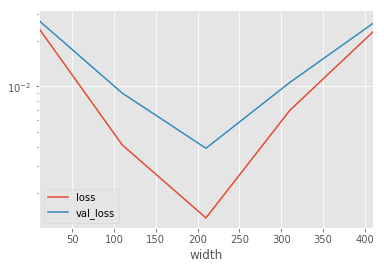

In [65]:
pd.DataFrame(width_perf).loc[:,['width','loss','val_loss']].set_index('width').plot(logy=True)

In [25]:
learningrates2 = {
    'lr_intial' : 1e-2, # higher than the default
    'lr_decay' : 0.01, # for adam it is 1 / (1 + decay * t) , thus with decay 0.001 and at t==1000, lr is divided by 2
                    # note that the effect of this decay is not visible in tensorboard
    'lr_plateau_factor' : 0.7, # if no convergence (possibly by too high lr), we boost the lr decay
    'lr_plateau_patience' : 4, # nr of consequetive epochs without improvement before we boost the lr decay
    'lr_plateau_cooldown' : 10, # first do this nr of iterations at new lr before detecting plateau
    'lr_minimum' : 1e-6, # the minimum lr too which we decay (for plateau detection)

    'stop_patience' : 30, # if no extra improvement after this nr of steps , we terminate learning
    'stop_delta' : 0.0001, # the epsilon, changes below this threshold are 'no improvement'

    'epochs_max' : 1000 # limit the total nr op epochs, very high, we will stop based on plateau
}

In [66]:
width_patience=2 # if increasing width this nr of times did not improve val_loss, stop
width2_perf = []
prev_weights = []
for width in range(50, 301, 50):
    fit, results = run_depth1(width, learningrates2, prev_weights, 'mediumsteps')
    width2_perf.append(results)
    prev_weights=[layer.get_weights() for layer in model.layers]
    print width_perf
    if len(width_perf)>width_patience and width_perf[-1]['val_mse']>np.min(x['val_mse'] for x in width_perf[-width_patience:-1]):
        break

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_64 (LSTM)               (None, None, 50)          10600     
_________________________________________________________________
time_distributed_61 (TimeDis (None, None, 1)           51        
Total params: 10,651
Trainable params: 10,651
Non-trainable params: 0
_________________________________________________________________
Train on 1 samples, validate on 1 samples
Epoch 1/1000
3s - loss: 0.8481 - mse: 738.5408 - val_loss: 0.6401 - val_mse: 557.3804
Epoch 2/1000
0s - loss: 0.5927 - mse: 516.1166 - val_loss: 0.5083 - val_mse: 442.6301
Epoch 3/1000
0s - loss: 0.4647 - mse: 404.7019 - val_loss: 0.4050 - val_mse: 352.6635
Epoch 4/1000
0s - loss: 0.3734 - mse: 325.1505 - val_loss: 0.3196 - val_mse: 278.3061
Epoch 5/1000
0s - loss: 0.3009 - mse: 262.0180 - val_loss: 0.2749 - val_mse: 239.4184
Epoch 6/1000
0s - loss: 0.2666 - mse: 232.1522 - val_loss: 0.2

0s - loss: 0.0341 - mse: 29.6757 - val_loss: 0.0351 - val_mse: 30.5445
Epoch 90/1000
0s - loss: 0.0336 - mse: 29.2839 - val_loss: 0.0346 - val_mse: 30.1368
Epoch 91/1000
0s - loss: 0.0332 - mse: 28.9111 - val_loss: 0.0342 - val_mse: 29.7950
Epoch 92/1000
0s - loss: 0.0328 - mse: 28.5564 - val_loss: 0.0339 - val_mse: 29.4914
Epoch 93/1000
0s - loss: 0.0324 - mse: 28.2270 - val_loss: 0.0335 - val_mse: 29.1757
Epoch 94/1000
0s - loss: 0.0321 - mse: 27.9128 - val_loss: 0.0331 - val_mse: 28.8336
Epoch 95/1000
0s - loss: 0.0317 - mse: 27.6147 - val_loss: 0.0327 - val_mse: 28.4980
Epoch 96/1000
0s - loss: 0.0314 - mse: 27.3323 - val_loss: 0.0324 - val_mse: 28.2078
Epoch 97/1000
0s - loss: 0.0311 - mse: 27.0656 - val_loss: 0.0321 - val_mse: 27.9715
Epoch 98/1000
0s - loss: 0.0308 - mse: 26.8052 - val_loss: 0.0319 - val_mse: 27.7747
Epoch 99/1000
0s - loss: 0.0305 - mse: 26.5516 - val_loss: 0.0317 - val_mse: 27.5872
Epoch 100/1000
0s - loss: 0.0302 - mse: 26.3075 - val_loss: 0.0314 - val_mse: 2

0s - loss: 0.0172 - mse: 15.0034 - val_loss: 0.0195 - val_mse: 16.9413
Epoch 186/1000
0s - loss: 0.0171 - mse: 14.9069 - val_loss: 0.0194 - val_mse: 16.9026
Epoch 187/1000
0s - loss: 0.0171 - mse: 14.8484 - val_loss: 0.0193 - val_mse: 16.8205
Epoch 188/1000
0s - loss: 0.0169 - mse: 14.7366 - val_loss: 0.0192 - val_mse: 16.7559
Epoch 189/1000
0s - loss: 0.0168 - mse: 14.6730 - val_loss: 0.0191 - val_mse: 16.6682
Epoch 190/1000
0s - loss: 0.0167 - mse: 14.5840 - val_loss: 0.0191 - val_mse: 16.6047
Epoch 191/1000
0s - loss: 0.0166 - mse: 14.4944 - val_loss: 0.0190 - val_mse: 16.5610
Epoch 192/1000
0s - loss: 0.0166 - mse: 14.4317 - val_loss: 0.0189 - val_mse: 16.4729
Epoch 193/1000
0s - loss: 0.0165 - mse: 14.3342 - val_loss: 0.0189 - val_mse: 16.4289
Epoch 194/1000
0s - loss: 0.0164 - mse: 14.2655 - val_loss: 0.0188 - val_mse: 16.3971
Epoch 195/1000
0s - loss: 0.0163 - mse: 14.1878 - val_loss: 0.0187 - val_mse: 16.3277
Epoch 196/1000
0s - loss: 0.0162 - mse: 14.0996 - val_loss: 0.0187 - 

0s - loss: 0.0112 - mse: 9.7343 - val_loss: 0.0146 - val_mse: 12.7291
Epoch 281/1000
0s - loss: 0.0111 - mse: 9.6975 - val_loss: 0.0146 - val_mse: 12.7271
Epoch 282/1000
0s - loss: 0.0111 - mse: 9.6821 - val_loss: 0.0146 - val_mse: 12.7036
Epoch 283/1000
0s - loss: 0.0111 - mse: 9.6540 - val_loss: 0.0146 - val_mse: 12.6781
Epoch 284/1000
0s - loss: 0.0111 - mse: 9.6310 - val_loss: 0.0145 - val_mse: 12.6610
Epoch 285/1000
0s - loss: 0.0110 - mse: 9.6105 - val_loss: 0.0145 - val_mse: 12.6459
Epoch 286/1000
0s - loss: 0.0110 - mse: 9.5823 - val_loss: 0.0145 - val_mse: 12.6378
Epoch 287/1000
0s - loss: 0.0110 - mse: 9.5657 - val_loss: 0.0145 - val_mse: 12.6099
Epoch 288/1000
0s - loss: 0.0110 - mse: 9.5360 - val_loss: 0.0145 - val_mse: 12.5965
Epoch 289/1000

Epoch 00288: reducing learning rate to 0.00240100002848.
0s - loss: 0.0109 - mse: 9.5197 - val_loss: 0.0144 - val_mse: 12.5798
Epoch 290/1000
0s - loss: 0.0109 - mse: 9.4921 - val_loss: 0.0144 - val_mse: 12.5741
Epoch 291/1000
0s - lo

0s - loss: 0.0102 - mse: 8.8764 - val_loss: 0.0140 - val_mse: 12.1846
Epoch 374/1000
0s - loss: 0.0102 - mse: 8.8741 - val_loss: 0.0140 - val_mse: 12.1831
Epoch 375/1000
0s - loss: 0.0102 - mse: 8.8719 - val_loss: 0.0140 - val_mse: 12.1817
Epoch 376/1000
0s - loss: 0.0102 - mse: 8.8696 - val_loss: 0.0140 - val_mse: 12.1803
Epoch 377/1000

Epoch 00376: reducing learning rate to 0.000282475253334.
0s - loss: 0.0102 - mse: 8.8674 - val_loss: 0.0140 - val_mse: 12.1788
Epoch 378/1000
0s - loss: 0.0102 - mse: 8.8651 - val_loss: 0.0140 - val_mse: 12.1777
Epoch 379/1000
0s - loss: 0.0102 - mse: 8.8635 - val_loss: 0.0140 - val_mse: 12.1767
Epoch 380/1000
0s - loss: 0.0102 - mse: 8.8620 - val_loss: 0.0140 - val_mse: 12.1757
Epoch 381/1000
0s - loss: 0.0102 - mse: 8.8604 - val_loss: 0.0140 - val_mse: 12.1747
Epoch 382/1000
0s - loss: 0.0102 - mse: 8.8588 - val_loss: 0.0140 - val_mse: 12.1737
Epoch 383/1000
0s - loss: 0.0102 - mse: 8.8573 - val_loss: 0.0140 - val_mse: 12.1727
Epoch 384/1000
0s - l

0s - loss: 0.0257 - mse: 22.3909 - val_loss: 0.0274 - val_mse: 23.8900
Epoch 64/1000
0s - loss: 0.0253 - mse: 22.0736 - val_loss: 0.0272 - val_mse: 23.6514
Epoch 65/1000
0s - loss: 0.0251 - mse: 21.8320 - val_loss: 0.0268 - val_mse: 23.3450
Epoch 66/1000
0s - loss: 0.0248 - mse: 21.5952 - val_loss: 0.0266 - val_mse: 23.1479
Epoch 67/1000
0s - loss: 0.0245 - mse: 21.3126 - val_loss: 0.0264 - val_mse: 22.9657
Epoch 68/1000
0s - loss: 0.0241 - mse: 21.0247 - val_loss: 0.0262 - val_mse: 22.8463
Epoch 69/1000
0s - loss: 0.0239 - mse: 20.7751 - val_loss: 0.0261 - val_mse: 22.7145
Epoch 70/1000
0s - loss: 0.0236 - mse: 20.5636 - val_loss: 0.0258 - val_mse: 22.4417
Epoch 71/1000
0s - loss: 0.0234 - mse: 20.3553 - val_loss: 0.0255 - val_mse: 22.2192
Epoch 72/1000
0s - loss: 0.0231 - mse: 20.1507 - val_loss: 0.0251 - val_mse: 21.8563
Epoch 73/1000
0s - loss: 0.0230 - mse: 20.0308 - val_loss: 0.0257 - val_mse: 22.3630
Epoch 74/1000
0s - loss: 0.0235 - mse: 20.4359 - val_loss: 0.0269 - val_mse: 23

0s - loss: 0.0102 - mse: 8.8796 - val_loss: 0.0154 - val_mse: 13.3762
Epoch 160/1000
0s - loss: 0.0125 - mse: 10.8895 - val_loss: 0.0127 - val_mse: 11.0526
Epoch 161/1000
0s - loss: 0.0101 - mse: 8.7675 - val_loss: 0.0132 - val_mse: 11.5201
Epoch 162/1000
0s - loss: 0.0110 - mse: 9.6209 - val_loss: 0.0130 - val_mse: 11.2908
Epoch 163/1000
0s - loss: 0.0109 - mse: 9.5281 - val_loss: 0.0120 - val_mse: 10.4656
Epoch 164/1000
0s - loss: 0.0098 - mse: 8.5056 - val_loss: 0.0134 - val_mse: 11.6785
Epoch 165/1000
0s - loss: 0.0110 - mse: 9.5502 - val_loss: 0.0122 - val_mse: 10.6215
Epoch 166/1000
0s - loss: 0.0099 - mse: 8.5793 - val_loss: 0.0121 - val_mse: 10.5536
Epoch 167/1000
0s - loss: 0.0099 - mse: 8.6541 - val_loss: 0.0124 - val_mse: 10.8138
Epoch 168/1000
0s - loss: 0.0102 - mse: 8.9010 - val_loss: 0.0119 - val_mse: 10.3536
Epoch 169/1000
0s - loss: 0.0095 - mse: 8.2388 - val_loss: 0.0124 - val_mse: 10.8166
Epoch 170/1000
0s - loss: 0.0098 - mse: 8.5691 - val_loss: 0.0121 - val_mse: 10

0s - loss: 0.0053 - mse: 4.6566 - val_loss: 0.0076 - val_mse: 6.6326
Epoch 258/1000
0s - loss: 0.0053 - mse: 4.6262 - val_loss: 0.0076 - val_mse: 6.6053
Epoch 259/1000
0s - loss: 0.0053 - mse: 4.5957 - val_loss: 0.0076 - val_mse: 6.5755
Epoch 260/1000
0s - loss: 0.0052 - mse: 4.5650 - val_loss: 0.0075 - val_mse: 6.5475
Epoch 261/1000
0s - loss: 0.0052 - mse: 4.5345 - val_loss: 0.0075 - val_mse: 6.5181
Epoch 262/1000
0s - loss: 0.0052 - mse: 4.5037 - val_loss: 0.0074 - val_mse: 6.4874
Epoch 263/1000
0s - loss: 0.0051 - mse: 4.4729 - val_loss: 0.0074 - val_mse: 6.4608
Epoch 264/1000
0s - loss: 0.0051 - mse: 4.4423 - val_loss: 0.0074 - val_mse: 6.4313
Epoch 265/1000
0s - loss: 0.0051 - mse: 4.4115 - val_loss: 0.0073 - val_mse: 6.4006
Epoch 266/1000
0s - loss: 0.0050 - mse: 4.3810 - val_loss: 0.0073 - val_mse: 6.3741
Epoch 267/1000
0s - loss: 0.0050 - mse: 4.3504 - val_loss: 0.0073 - val_mse: 6.3459
Epoch 268/1000
0s - loss: 0.0050 - mse: 4.3199 - val_loss: 0.0073 - val_mse: 6.3159
Epoch 2

0s - loss: 0.0036 - mse: 3.1503 - val_loss: 0.0062 - val_mse: 5.4212
Epoch 353/1000
0s - loss: 0.0036 - mse: 3.1462 - val_loss: 0.0062 - val_mse: 5.4204
Epoch 354/1000
0s - loss: 0.0036 - mse: 3.1417 - val_loss: 0.0062 - val_mse: 5.4200
Epoch 355/1000

Epoch 00354: reducing learning rate to 0.000823543069419.
0s - loss: 0.0036 - mse: 3.1376 - val_loss: 0.0062 - val_mse: 5.4187
Epoch 356/1000
0s - loss: 0.0036 - mse: 3.1335 - val_loss: 0.0062 - val_mse: 5.4167
Epoch 357/1000
0s - loss: 0.0036 - mse: 3.1305 - val_loss: 0.0062 - val_mse: 5.4144
Epoch 358/1000
0s - loss: 0.0036 - mse: 3.1274 - val_loss: 0.0062 - val_mse: 5.4122
Epoch 359/1000
0s - loss: 0.0036 - mse: 3.1246 - val_loss: 0.0062 - val_mse: 5.4103
Epoch 360/1000
0s - loss: 0.0036 - mse: 3.1217 - val_loss: 0.0062 - val_mse: 5.4087
Epoch 361/1000
0s - loss: 0.0036 - mse: 3.1187 - val_loss: 0.0062 - val_mse: 5.4074
Epoch 362/1000
0s - loss: 0.0036 - mse: 3.1157 - val_loss: 0.0062 - val_mse: 5.4061
Epoch 363/1000
0s - loss: 0.0036

0s - loss: 0.0213 - mse: 18.5920 - val_loss: 0.0242 - val_mse: 21.1137
Epoch 70/1000
0s - loss: 0.0210 - mse: 18.2901 - val_loss: 0.0239 - val_mse: 20.8521
Epoch 71/1000
0s - loss: 0.0207 - mse: 17.9994 - val_loss: 0.0236 - val_mse: 20.5794
Epoch 72/1000
0s - loss: 0.0203 - mse: 17.6925 - val_loss: 0.0233 - val_mse: 20.3116
Epoch 73/1000
0s - loss: 0.0200 - mse: 17.4268 - val_loss: 0.0230 - val_mse: 19.9873
Epoch 74/1000
0s - loss: 0.0197 - mse: 17.1374 - val_loss: 0.0226 - val_mse: 19.7041
Epoch 75/1000
0s - loss: 0.0194 - mse: 16.8576 - val_loss: 0.0224 - val_mse: 19.4932
Epoch 76/1000
0s - loss: 0.0190 - mse: 16.5655 - val_loss: 0.0222 - val_mse: 19.3458
Epoch 77/1000
0s - loss: 0.0187 - mse: 16.3115 - val_loss: 0.0219 - val_mse: 19.1090
Epoch 78/1000
0s - loss: 0.0184 - mse: 16.0324 - val_loss: 0.0216 - val_mse: 18.8344
Epoch 79/1000
0s - loss: 0.0181 - mse: 15.7477 - val_loss: 0.0214 - val_mse: 18.6606
Epoch 80/1000
0s - loss: 0.0178 - mse: 15.5053 - val_loss: 0.0220 - val_mse: 19

0s - loss: 0.0087 - mse: 7.5834 - val_loss: 0.0116 - val_mse: 10.1003
Epoch 166/1000
0s - loss: 0.0086 - mse: 7.5191 - val_loss: 0.0115 - val_mse: 10.0454
Epoch 167/1000
0s - loss: 0.0086 - mse: 7.4555 - val_loss: 0.0115 - val_mse: 9.9723
Epoch 168/1000
0s - loss: 0.0085 - mse: 7.3920 - val_loss: 0.0114 - val_mse: 9.8948
Epoch 169/1000
0s - loss: 0.0084 - mse: 7.3284 - val_loss: 0.0113 - val_mse: 9.8300
Epoch 170/1000
0s - loss: 0.0083 - mse: 7.2650 - val_loss: 0.0112 - val_mse: 9.7797
Epoch 171/1000
0s - loss: 0.0083 - mse: 7.2033 - val_loss: 0.0112 - val_mse: 9.7310
Epoch 172/1000
0s - loss: 0.0082 - mse: 7.1403 - val_loss: 0.0111 - val_mse: 9.6804
Epoch 173/1000
0s - loss: 0.0081 - mse: 7.0784 - val_loss: 0.0111 - val_mse: 9.6266
Epoch 174/1000
0s - loss: 0.0081 - mse: 7.0167 - val_loss: 0.0110 - val_mse: 9.5698
Epoch 175/1000
0s - loss: 0.0080 - mse: 6.9548 - val_loss: 0.0109 - val_mse: 9.5101
Epoch 176/1000
0s - loss: 0.0079 - mse: 6.8943 - val_loss: 0.0109 - val_mse: 9.4508
Epoch

0s - loss: 0.0042 - mse: 3.6357 - val_loss: 0.0073 - val_mse: 6.3298
Epoch 262/1000
0s - loss: 0.0042 - mse: 3.6236 - val_loss: 0.0073 - val_mse: 6.3376
Epoch 263/1000
0s - loss: 0.0041 - mse: 3.6096 - val_loss: 0.0073 - val_mse: 6.3315
Epoch 264/1000
0s - loss: 0.0041 - mse: 3.5861 - val_loss: 0.0073 - val_mse: 6.3183
Epoch 265/1000
0s - loss: 0.0041 - mse: 3.5735 - val_loss: 0.0072 - val_mse: 6.2910
Epoch 266/1000
0s - loss: 0.0041 - mse: 3.5597 - val_loss: 0.0072 - val_mse: 6.2575
Epoch 267/1000
0s - loss: 0.0041 - mse: 3.5376 - val_loss: 0.0072 - val_mse: 6.2428
Epoch 268/1000
0s - loss: 0.0040 - mse: 3.5239 - val_loss: 0.0072 - val_mse: 6.2338
Epoch 269/1000
0s - loss: 0.0040 - mse: 3.5092 - val_loss: 0.0071 - val_mse: 6.2159
Epoch 270/1000
0s - loss: 0.0040 - mse: 3.4882 - val_loss: 0.0071 - val_mse: 6.1947
Epoch 271/1000
0s - loss: 0.0040 - mse: 3.4741 - val_loss: 0.0071 - val_mse: 6.1652
Epoch 272/1000
0s - loss: 0.0040 - mse: 3.4586 - val_loss: 0.0070 - val_mse: 6.1344
Epoch 2

0s - loss: 0.0033 - mse: 2.8663 - val_loss: 0.0064 - val_mse: 5.5551
Epoch 356/1000
0s - loss: 0.0033 - mse: 2.8644 - val_loss: 0.0064 - val_mse: 5.5533
Epoch 357/1000
0s - loss: 0.0033 - mse: 2.8625 - val_loss: 0.0064 - val_mse: 5.5516
Epoch 358/1000
0s - loss: 0.0033 - mse: 2.8606 - val_loss: 0.0064 - val_mse: 5.5498
Epoch 359/1000
0s - loss: 0.0033 - mse: 2.8586 - val_loss: 0.0064 - val_mse: 5.5480
Epoch 360/1000
0s - loss: 0.0033 - mse: 2.8567 - val_loss: 0.0064 - val_mse: 5.5462
Epoch 361/1000
0s - loss: 0.0033 - mse: 2.8548 - val_loss: 0.0064 - val_mse: 5.5445
Epoch 362/1000
0s - loss: 0.0033 - mse: 2.8529 - val_loss: 0.0064 - val_mse: 5.5428
Epoch 363/1000
0s - loss: 0.0033 - mse: 2.8510 - val_loss: 0.0064 - val_mse: 5.5410
Epoch 364/1000
0s - loss: 0.0033 - mse: 2.8491 - val_loss: 0.0064 - val_mse: 5.5392
Epoch 365/1000
0s - loss: 0.0033 - mse: 2.8471 - val_loss: 0.0064 - val_mse: 5.5375
Epoch 366/1000

Epoch 00365: reducing learning rate to 0.000197732681409.
0s - loss: 0.0033

0s - loss: 0.0283 - mse: 24.6514 - val_loss: 0.0310 - val_mse: 26.9609
Epoch 62/1000
0s - loss: 0.0278 - mse: 24.2094 - val_loss: 0.0304 - val_mse: 26.4385
Epoch 63/1000
0s - loss: 0.0274 - mse: 23.8468 - val_loss: 0.0300 - val_mse: 26.0903
Epoch 64/1000
0s - loss: 0.0271 - mse: 23.6103 - val_loss: 0.0297 - val_mse: 25.8637
Epoch 65/1000
0s - loss: 0.0269 - mse: 23.4135 - val_loss: 0.0295 - val_mse: 25.6852
Epoch 66/1000
0s - loss: 0.0266 - mse: 23.1712 - val_loss: 0.0294 - val_mse: 25.5704
Epoch 67/1000
0s - loss: 0.0263 - mse: 22.9007 - val_loss: 0.0293 - val_mse: 25.5552
Epoch 68/1000
0s - loss: 0.0260 - mse: 22.6732 - val_loss: 0.0294 - val_mse: 25.5840
Epoch 69/1000
0s - loss: 0.0258 - mse: 22.5016 - val_loss: 0.0293 - val_mse: 25.5253
Epoch 70/1000
0s - loss: 0.0256 - mse: 22.3342 - val_loss: 0.0291 - val_mse: 25.3026
Epoch 71/1000
0s - loss: 0.0254 - mse: 22.1320 - val_loss: 0.0287 - val_mse: 24.9615
Epoch 72/1000
0s - loss: 0.0252 - mse: 21.9142 - val_loss: 0.0283 - val_mse: 24

0s - loss: 0.0130 - mse: 11.3277 - val_loss: 0.0167 - val_mse: 14.5452
Epoch 158/1000
0s - loss: 0.0129 - mse: 11.2227 - val_loss: 0.0166 - val_mse: 14.4720
Epoch 159/1000
0s - loss: 0.0128 - mse: 11.1186 - val_loss: 0.0165 - val_mse: 14.4016
Epoch 160/1000
0s - loss: 0.0127 - mse: 11.0162 - val_loss: 0.0165 - val_mse: 14.3334
Epoch 161/1000
0s - loss: 0.0125 - mse: 10.9148 - val_loss: 0.0164 - val_mse: 14.2643
Epoch 162/1000
0s - loss: 0.0124 - mse: 10.8140 - val_loss: 0.0163 - val_mse: 14.1921
Epoch 163/1000
0s - loss: 0.0123 - mse: 10.7139 - val_loss: 0.0162 - val_mse: 14.1173
Epoch 164/1000
0s - loss: 0.0122 - mse: 10.6149 - val_loss: 0.0161 - val_mse: 14.0421
Epoch 165/1000
0s - loss: 0.0121 - mse: 10.5172 - val_loss: 0.0160 - val_mse: 13.9694
Epoch 166/1000
0s - loss: 0.0120 - mse: 10.4200 - val_loss: 0.0160 - val_mse: 13.9015
Epoch 167/1000
0s - loss: 0.0119 - mse: 10.3230 - val_loss: 0.0159 - val_mse: 13.8377
Epoch 168/1000
0s - loss: 0.0117 - mse: 10.2276 - val_loss: 0.0158 - 

0s - loss: 0.0046 - mse: 3.9746 - val_loss: 0.0107 - val_mse: 9.3559
Epoch 255/1000
0s - loss: 0.0045 - mse: 3.9390 - val_loss: 0.0107 - val_mse: 9.3132
Epoch 256/1000
0s - loss: 0.0045 - mse: 3.9041 - val_loss: 0.0106 - val_mse: 9.2677
Epoch 257/1000
0s - loss: 0.0044 - mse: 3.8694 - val_loss: 0.0106 - val_mse: 9.2320
Epoch 258/1000
0s - loss: 0.0044 - mse: 3.8352 - val_loss: 0.0106 - val_mse: 9.2048
Epoch 259/1000
0s - loss: 0.0044 - mse: 3.8013 - val_loss: 0.0105 - val_mse: 9.1731
Epoch 260/1000
0s - loss: 0.0043 - mse: 3.7678 - val_loss: 0.0105 - val_mse: 9.1301
Epoch 261/1000
0s - loss: 0.0043 - mse: 3.7344 - val_loss: 0.0104 - val_mse: 9.0917
Epoch 262/1000
0s - loss: 0.0043 - mse: 3.7011 - val_loss: 0.0104 - val_mse: 9.0584
Epoch 263/1000
0s - loss: 0.0042 - mse: 3.6685 - val_loss: 0.0104 - val_mse: 9.0194
Epoch 264/1000
0s - loss: 0.0042 - mse: 3.6362 - val_loss: 0.0103 - val_mse: 8.9808
Epoch 265/1000
0s - loss: 0.0041 - mse: 3.6040 - val_loss: 0.0103 - val_mse: 8.9509
Epoch 2

0s - loss: 0.0020 - mse: 1.7156 - val_loss: 0.0090 - val_mse: 7.8107
Epoch 350/1000
0s - loss: 0.0020 - mse: 1.7069 - val_loss: 0.0090 - val_mse: 7.8081
Epoch 351/1000
0s - loss: 0.0020 - mse: 1.6982 - val_loss: 0.0090 - val_mse: 7.8057
Epoch 352/1000

Epoch 00351: reducing learning rate to 0.00168070008513.
0s - loss: 0.0019 - mse: 1.6895 - val_loss: 0.0090 - val_mse: 7.8041
Epoch 353/1000
0s - loss: 0.0019 - mse: 1.6810 - val_loss: 0.0090 - val_mse: 7.8035
Epoch 354/1000
0s - loss: 0.0019 - mse: 1.6750 - val_loss: 0.0090 - val_mse: 7.8035
Epoch 355/1000
0s - loss: 0.0019 - mse: 1.6690 - val_loss: 0.0090 - val_mse: 7.8036
Epoch 356/1000
0s - loss: 0.0019 - mse: 1.6631 - val_loss: 0.0090 - val_mse: 7.8035
Epoch 357/1000
0s - loss: 0.0019 - mse: 1.6571 - val_loss: 0.0090 - val_mse: 7.8026
Epoch 358/1000
0s - loss: 0.0019 - mse: 1.6512 - val_loss: 0.0090 - val_mse: 7.8015
Epoch 359/1000
0s - loss: 0.0019 - mse: 1.6455 - val_loss: 0.0090 - val_mse: 7.8007
Epoch 360/1000
0s - loss: 0.0019 

0s - loss: 0.0214 - mse: 18.5962 - val_loss: 0.0230 - val_mse: 20.0118
Epoch 66/1000
0s - loss: 0.0211 - mse: 18.3486 - val_loss: 0.0228 - val_mse: 19.8553
Epoch 67/1000
0s - loss: 0.0208 - mse: 18.1024 - val_loss: 0.0226 - val_mse: 19.6783
Epoch 68/1000
0s - loss: 0.0205 - mse: 17.8349 - val_loss: 0.0224 - val_mse: 19.5208
Epoch 69/1000
0s - loss: 0.0202 - mse: 17.5809 - val_loss: 0.0223 - val_mse: 19.4129
Epoch 70/1000
0s - loss: 0.0199 - mse: 17.3641 - val_loss: 0.0222 - val_mse: 19.3451
Epoch 71/1000
0s - loss: 0.0197 - mse: 17.1735 - val_loss: 0.0221 - val_mse: 19.2854
Epoch 72/1000
0s - loss: 0.0195 - mse: 16.9876 - val_loss: 0.0220 - val_mse: 19.1944
Epoch 73/1000
0s - loss: 0.0193 - mse: 16.7883 - val_loss: 0.0219 - val_mse: 19.0595
Epoch 74/1000
0s - loss: 0.0190 - mse: 16.5797 - val_loss: 0.0217 - val_mse: 18.8965
Epoch 75/1000
0s - loss: 0.0188 - mse: 16.3782 - val_loss: 0.0215 - val_mse: 18.7137
Epoch 76/1000
0s - loss: 0.0186 - mse: 16.1822 - val_loss: 0.0213 - val_mse: 18

0s - loss: 0.0069 - mse: 6.0062 - val_loss: 0.0111 - val_mse: 9.6930
Epoch 162/1000
0s - loss: 0.0065 - mse: 5.6664 - val_loss: 0.0114 - val_mse: 9.8976
Epoch 163/1000
0s - loss: 0.0066 - mse: 5.7847 - val_loss: 0.0111 - val_mse: 9.6531
Epoch 164/1000
0s - loss: 0.0064 - mse: 5.5829 - val_loss: 0.0109 - val_mse: 9.4973
Epoch 165/1000
0s - loss: 0.0064 - mse: 5.5518 - val_loss: 0.0108 - val_mse: 9.4280
Epoch 166/1000
0s - loss: 0.0063 - mse: 5.4835 - val_loss: 0.0108 - val_mse: 9.3768
Epoch 167/1000
0s - loss: 0.0061 - mse: 5.3498 - val_loss: 0.0108 - val_mse: 9.3935
Epoch 168/1000
0s - loss: 0.0061 - mse: 5.3315 - val_loss: 0.0106 - val_mse: 9.1977
Epoch 169/1000
0s - loss: 0.0060 - mse: 5.1815 - val_loss: 0.0105 - val_mse: 9.1817
Epoch 170/1000
0s - loss: 0.0059 - mse: 5.1496 - val_loss: 0.0105 - val_mse: 9.1460
Epoch 171/1000
0s - loss: 0.0058 - mse: 5.0213 - val_loss: 0.0104 - val_mse: 9.0869
Epoch 172/1000
0s - loss: 0.0057 - mse: 4.9584 - val_loss: 0.0102 - val_mse: 8.9094
Epoch 1

0s - loss: 0.0013 - mse: 1.1453 - val_loss: 0.0062 - val_mse: 5.4395
Epoch 257/1000
0s - loss: 0.0013 - mse: 1.1409 - val_loss: 0.0062 - val_mse: 5.4424
Epoch 258/1000
0s - loss: 0.0013 - mse: 1.1380 - val_loss: 0.0062 - val_mse: 5.4374
Epoch 259/1000
0s - loss: 0.0013 - mse: 1.1332 - val_loss: 0.0062 - val_mse: 5.4283
Epoch 260/1000
0s - loss: 0.0013 - mse: 1.1283 - val_loss: 0.0062 - val_mse: 5.4225
Epoch 261/1000
0s - loss: 0.0013 - mse: 1.1249 - val_loss: 0.0062 - val_mse: 5.4209
Epoch 262/1000
0s - loss: 0.0013 - mse: 1.1209 - val_loss: 0.0062 - val_mse: 5.4232
Epoch 263/1000
0s - loss: 0.0013 - mse: 1.1163 - val_loss: 0.0062 - val_mse: 5.4268
[{'loss': 0.024293258786201477, 'dropout': 0.0, 'val_mse': 23.78474235534668, 'width': 10, 'mse': 21.155517578125, 'val_loss': 0.027312444522976875}, {'loss': 0.0041144080460071564, 'dropout': 0.0, 'val_mse': 7.8667654991149902, 'width': 110, 'mse': 3.5829868316650391, 'val_loss': 0.0090335477143526077}, {'loss': 0.0013604337582364678, 'drop

0s - loss: 0.0227 - mse: 19.7703 - val_loss: 0.0239 - val_mse: 20.8226
Epoch 74/1000
0s - loss: 0.0224 - mse: 19.5345 - val_loss: 0.0236 - val_mse: 20.5866
Epoch 75/1000
0s - loss: 0.0222 - mse: 19.3098 - val_loss: 0.0234 - val_mse: 20.3555
Epoch 76/1000
0s - loss: 0.0219 - mse: 19.0951 - val_loss: 0.0231 - val_mse: 20.0937
Epoch 77/1000
0s - loss: 0.0216 - mse: 18.8414 - val_loss: 0.0228 - val_mse: 19.8618
Epoch 78/1000
0s - loss: 0.0214 - mse: 18.6057 - val_loss: 0.0226 - val_mse: 19.6600
Epoch 79/1000
0s - loss: 0.0211 - mse: 18.3950 - val_loss: 0.0223 - val_mse: 19.4365
Epoch 80/1000
0s - loss: 0.0209 - mse: 18.1608 - val_loss: 0.0221 - val_mse: 19.2178
Epoch 81/1000
0s - loss: 0.0206 - mse: 17.9206 - val_loss: 0.0218 - val_mse: 19.0070
Epoch 82/1000
0s - loss: 0.0203 - mse: 17.6788 - val_loss: 0.0216 - val_mse: 18.8014
Epoch 83/1000
0s - loss: 0.0200 - mse: 17.4543 - val_loss: 0.0213 - val_mse: 18.5700
Epoch 84/1000
0s - loss: 0.0198 - mse: 17.2302 - val_loss: 0.0211 - val_mse: 18

0s - loss: 0.0072 - mse: 6.2935 - val_loss: 0.0108 - val_mse: 9.3831
Epoch 169/1000
0s - loss: 0.0077 - mse: 6.6949 - val_loss: 0.0101 - val_mse: 8.8310
Epoch 170/1000
0s - loss: 0.0071 - mse: 6.1736 - val_loss: 0.0103 - val_mse: 9.0121
Epoch 171/1000
0s - loss: 0.0075 - mse: 6.5064 - val_loss: 0.0100 - val_mse: 8.7165
Epoch 172/1000
0s - loss: 0.0069 - mse: 6.0395 - val_loss: 0.0104 - val_mse: 9.0635
Epoch 173/1000
0s - loss: 0.0072 - mse: 6.2890 - val_loss: 0.0099 - val_mse: 8.6243
Epoch 174/1000
0s - loss: 0.0068 - mse: 5.9175 - val_loss: 0.0100 - val_mse: 8.7221
Epoch 175/1000
0s - loss: 0.0070 - mse: 6.1288 - val_loss: 0.0098 - val_mse: 8.5712
Epoch 176/1000
0s - loss: 0.0066 - mse: 5.7900 - val_loss: 0.0101 - val_mse: 8.8163
Epoch 177/1000
0s - loss: 0.0068 - mse: 5.9458 - val_loss: 0.0097 - val_mse: 8.4447
Epoch 178/1000
0s - loss: 0.0065 - mse: 5.6733 - val_loss: 0.0098 - val_mse: 8.4958
Epoch 179/1000
0s - loss: 0.0067 - mse: 5.7923 - val_loss: 0.0097 - val_mse: 8.4761
Epoch 1

0s - loss: 0.0030 - mse: 2.5710 - val_loss: 0.0069 - val_mse: 6.0396
Epoch 266/1000
0s - loss: 0.0029 - mse: 2.5550 - val_loss: 0.0069 - val_mse: 6.0240
Epoch 267/1000
0s - loss: 0.0029 - mse: 2.5410 - val_loss: 0.0069 - val_mse: 6.0104
Epoch 268/1000

Epoch 00267: reducing learning rate to 0.00168070008513.
0s - loss: 0.0029 - mse: 2.5249 - val_loss: 0.0069 - val_mse: 5.9958
Epoch 269/1000
0s - loss: 0.0029 - mse: 2.5104 - val_loss: 0.0069 - val_mse: 5.9837
Epoch 270/1000
0s - loss: 0.0029 - mse: 2.4993 - val_loss: 0.0069 - val_mse: 5.9747
Epoch 271/1000
0s - loss: 0.0029 - mse: 2.4892 - val_loss: 0.0069 - val_mse: 5.9675
Epoch 272/1000
0s - loss: 0.0028 - mse: 2.4781 - val_loss: 0.0068 - val_mse: 5.9594
Epoch 273/1000
0s - loss: 0.0028 - mse: 2.4681 - val_loss: 0.0068 - val_mse: 5.9473
Epoch 274/1000
0s - loss: 0.0028 - mse: 2.4571 - val_loss: 0.0068 - val_mse: 5.9363
Epoch 275/1000
0s - loss: 0.0028 - mse: 2.4472 - val_loss: 0.0068 - val_mse: 5.9272
Epoch 276/1000
0s - loss: 0.0028 

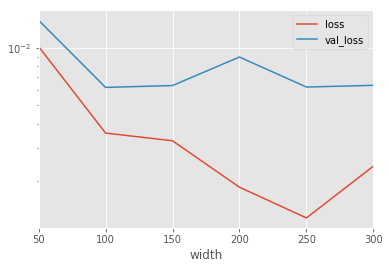

In [67]:
pd.DataFrame(width2_perf).loc[:,['width','loss','val_loss']].set_index('width').plot(logy=True)

In [69]:
width_patience=2 # if increasing width this nr of times did not improve val_loss, stop
width3_perf = []
prev_weights = []
for width in range(75, 150, 15):
    fit, results, prev_weights = run_depth1(width, learningrates2, prev_weights, 'smallsteps')
    width3_perf.append(results)
    print width3_perf
    if len(width2_perf)>width_patience and width2_perf[-1]['val_mse']>np.min(x['val_mse'] for x in width2_perf[-width_patience:-1]):
        break

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_70 (LSTM)               (None, None, 75)          23400     
_________________________________________________________________
time_distributed_67 (TimeDis (None, None, 1)           76        
Total params: 23,476
Trainable params: 23,476
Non-trainable params: 0
_________________________________________________________________
Train on 1 samples, validate on 1 samples
Epoch 1/1000
3s - loss: 1.0390 - mse: 904.8274 - val_loss: 0.7489 - val_mse: 652.1671
Epoch 2/1000
0s - loss: 0.7070 - mse: 615.6877 - val_loss: 0.4976 - val_mse: 433.3028
Epoch 3/1000
0s - loss: 0.4583 - mse: 399.0903 - val_loss: 0.3232 - val_mse: 281.4737
Epoch 4/1000
0s - loss: 0.2991 - mse: 260.4613 - val_loss: 0.2695 - val_mse: 234.6826
Epoch 5/1000
0s - loss: 0.2615 - mse: 227.7144 - val_loss: 0.2829 - val_mse: 246.3958
Epoch 6/1000
0s - loss: 0.2820 - mse: 245.5874 - val_loss: 0.2

0s - loss: 0.0318 - mse: 27.6930 - val_loss: 0.0335 - val_mse: 29.1810
Epoch 91/1000
0s - loss: 0.0302 - mse: 26.2636 - val_loss: 0.0284 - val_mse: 24.7445
Epoch 92/1000
0s - loss: 0.0255 - mse: 22.2304 - val_loss: 0.0316 - val_mse: 27.4789
Epoch 93/1000
0s - loss: 0.0300 - mse: 26.1373 - val_loss: 0.0285 - val_mse: 24.8033
Epoch 94/1000
0s - loss: 0.0255 - mse: 22.2398 - val_loss: 0.0299 - val_mse: 26.0707
Epoch 95/1000
0s - loss: 0.0270 - mse: 23.5125 - val_loss: 0.0277 - val_mse: 24.0860
Epoch 96/1000
0s - loss: 0.0253 - mse: 22.0445 - val_loss: 0.0278 - val_mse: 24.2430
Epoch 97/1000
0s - loss: 0.0257 - mse: 22.4072 - val_loss: 0.0284 - val_mse: 24.7337
Epoch 98/1000
0s - loss: 0.0250 - mse: 21.8000 - val_loss: 0.0278 - val_mse: 24.2067
Epoch 99/1000
0s - loss: 0.0246 - mse: 21.4184 - val_loss: 0.0271 - val_mse: 23.6071
Epoch 100/1000
0s - loss: 0.0245 - mse: 21.3011 - val_loss: 0.0266 - val_mse: 23.1553
Epoch 101/1000
0s - loss: 0.0241 - mse: 21.0291 - val_loss: 0.0270 - val_mse: 

0s - loss: 0.0131 - mse: 11.4148 - val_loss: 0.0159 - val_mse: 13.8264
Epoch 186/1000
0s - loss: 0.0130 - mse: 11.3202 - val_loss: 0.0158 - val_mse: 13.7478
Epoch 187/1000
0s - loss: 0.0128 - mse: 11.1823 - val_loss: 0.0159 - val_mse: 13.8758
Epoch 188/1000
0s - loss: 0.0129 - mse: 11.2189 - val_loss: 0.0156 - val_mse: 13.5678
Epoch 189/1000
0s - loss: 0.0126 - mse: 11.0039 - val_loss: 0.0156 - val_mse: 13.5687
Epoch 190/1000
0s - loss: 0.0127 - mse: 11.0565 - val_loss: 0.0155 - val_mse: 13.5052
Epoch 191/1000
0s - loss: 0.0125 - mse: 10.8950 - val_loss: 0.0154 - val_mse: 13.4447
Epoch 192/1000
0s - loss: 0.0125 - mse: 10.8496 - val_loss: 0.0153 - val_mse: 13.2943
Epoch 193/1000
0s - loss: 0.0124 - mse: 10.8092 - val_loss: 0.0152 - val_mse: 13.2130
Epoch 194/1000
0s - loss: 0.0122 - mse: 10.6624 - val_loss: 0.0152 - val_mse: 13.2682
Epoch 195/1000
0s - loss: 0.0123 - mse: 10.6724 - val_loss: 0.0150 - val_mse: 13.0560
Epoch 196/1000
0s - loss: 0.0121 - mse: 10.5394 - val_loss: 0.0149 - 

0s - loss: 0.0079 - mse: 6.9171 - val_loss: 0.0117 - val_mse: 10.1498
Epoch 281/1000
0s - loss: 0.0079 - mse: 6.8960 - val_loss: 0.0117 - val_mse: 10.1919
Epoch 282/1000

Epoch 00281: reducing learning rate to 0.00168070008513.
0s - loss: 0.0079 - mse: 6.8924 - val_loss: 0.0117 - val_mse: 10.1703
Epoch 283/1000
0s - loss: 0.0079 - mse: 6.8759 - val_loss: 0.0116 - val_mse: 10.1328
Epoch 284/1000
0s - loss: 0.0079 - mse: 6.8631 - val_loss: 0.0116 - val_mse: 10.1084
Epoch 285/1000
0s - loss: 0.0079 - mse: 6.8583 - val_loss: 0.0116 - val_mse: 10.1091
Epoch 286/1000
0s - loss: 0.0079 - mse: 6.8506 - val_loss: 0.0116 - val_mse: 10.1309
Epoch 287/1000
0s - loss: 0.0079 - mse: 6.8382 - val_loss: 0.0117 - val_mse: 10.1581
Epoch 288/1000
0s - loss: 0.0078 - mse: 6.8309 - val_loss: 0.0117 - val_mse: 10.1647
Epoch 289/1000
0s - loss: 0.0078 - mse: 6.8246 - val_loss: 0.0116 - val_mse: 10.1434
Epoch 290/1000
0s - loss: 0.0078 - mse: 6.8138 - val_loss: 0.0116 - val_mse: 10.1187
Epoch 291/1000
0s - lo

0s - loss: 0.0265 - mse: 23.1024 - val_loss: 0.0286 - val_mse: 24.9366
Epoch 74/1000
0s - loss: 0.0261 - mse: 22.6954 - val_loss: 0.0286 - val_mse: 24.8836
Epoch 75/1000
0s - loss: 0.0259 - mse: 22.5440 - val_loss: 0.0282 - val_mse: 24.5184
Epoch 76/1000
0s - loss: 0.0257 - mse: 22.3783 - val_loss: 0.0281 - val_mse: 24.4637
Epoch 77/1000
0s - loss: 0.0253 - mse: 22.0511 - val_loss: 0.0276 - val_mse: 24.0318
Epoch 78/1000
0s - loss: 0.0249 - mse: 21.6998 - val_loss: 0.0273 - val_mse: 23.8117
Epoch 79/1000
0s - loss: 0.0247 - mse: 21.5008 - val_loss: 0.0274 - val_mse: 23.8791
Epoch 80/1000
0s - loss: 0.0245 - mse: 21.3657 - val_loss: 0.0269 - val_mse: 23.4348
Epoch 81/1000
0s - loss: 0.0243 - mse: 21.1258 - val_loss: 0.0268 - val_mse: 23.3261
Epoch 82/1000
0s - loss: 0.0239 - mse: 20.8356 - val_loss: 0.0264 - val_mse: 23.0040
Epoch 83/1000
0s - loss: 0.0236 - mse: 20.5791 - val_loss: 0.0261 - val_mse: 22.7670
Epoch 84/1000
0s - loss: 0.0234 - mse: 20.3929 - val_loss: 0.0261 - val_mse: 22

0s - loss: 0.0111 - mse: 9.7068 - val_loss: 0.0141 - val_mse: 12.2594
Epoch 169/1000
0s - loss: 0.0111 - mse: 9.6969 - val_loss: 0.0140 - val_mse: 12.1746
Epoch 170/1000
0s - loss: 0.0110 - mse: 9.5454 - val_loss: 0.0141 - val_mse: 12.2602
Epoch 171/1000
0s - loss: 0.0109 - mse: 9.5180 - val_loss: 0.0141 - val_mse: 12.2374
Epoch 172/1000
0s - loss: 0.0109 - mse: 9.4527 - val_loss: 0.0139 - val_mse: 12.0642
Epoch 173/1000
0s - loss: 0.0107 - mse: 9.3418 - val_loss: 0.0137 - val_mse: 11.9540
Epoch 174/1000
0s - loss: 0.0107 - mse: 9.3177 - val_loss: 0.0137 - val_mse: 11.8887
Epoch 175/1000
0s - loss: 0.0106 - mse: 9.2244 - val_loss: 0.0137 - val_mse: 11.9505
Epoch 176/1000
0s - loss: 0.0105 - mse: 9.1511 - val_loss: 0.0138 - val_mse: 12.0244
Epoch 177/1000
0s - loss: 0.0105 - mse: 9.1099 - val_loss: 0.0137 - val_mse: 11.9137
Epoch 178/1000
0s - loss: 0.0104 - mse: 9.0168 - val_loss: 0.0135 - val_mse: 11.7538
Epoch 179/1000
0s - loss: 0.0103 - mse: 8.9667 - val_loss: 0.0134 - val_mse: 11.

0s - loss: 0.0066 - mse: 5.7637 - val_loss: 0.0110 - val_mse: 9.5684
Epoch 264/1000
0s - loss: 0.0066 - mse: 5.7504 - val_loss: 0.0110 - val_mse: 9.5600
Epoch 265/1000
0s - loss: 0.0066 - mse: 5.7370 - val_loss: 0.0110 - val_mse: 9.5505
Epoch 266/1000
0s - loss: 0.0066 - mse: 5.7235 - val_loss: 0.0110 - val_mse: 9.5360
Epoch 267/1000
0s - loss: 0.0066 - mse: 5.7099 - val_loss: 0.0109 - val_mse: 9.5266
Epoch 268/1000
0s - loss: 0.0065 - mse: 5.6963 - val_loss: 0.0109 - val_mse: 9.5222
Epoch 269/1000
0s - loss: 0.0065 - mse: 5.6827 - val_loss: 0.0109 - val_mse: 9.5160
Epoch 270/1000
0s - loss: 0.0065 - mse: 5.6690 - val_loss: 0.0109 - val_mse: 9.5035
Epoch 271/1000
0s - loss: 0.0065 - mse: 5.6553 - val_loss: 0.0109 - val_mse: 9.4903
Epoch 272/1000
0s - loss: 0.0065 - mse: 5.6416 - val_loss: 0.0109 - val_mse: 9.4797
Epoch 273/1000
0s - loss: 0.0065 - mse: 5.6278 - val_loss: 0.0109 - val_mse: 9.4763
Epoch 274/1000
0s - loss: 0.0064 - mse: 5.6141 - val_loss: 0.0109 - val_mse: 9.4696
Epoch 2

Train on 1 samples, validate on 1 samples
Epoch 1/1000
3s - loss: 1.0763 - mse: 937.2563 - val_loss: 0.5898 - val_mse: 513.5988
Epoch 2/1000
0s - loss: 0.5400 - mse: 470.2236 - val_loss: 0.3584 - val_mse: 312.1037
Epoch 3/1000
0s - loss: 0.3322 - mse: 289.3189 - val_loss: 0.2848 - val_mse: 247.9979
Epoch 4/1000
0s - loss: 0.2847 - mse: 247.9124 - val_loss: 0.2599 - val_mse: 226.3305
Epoch 5/1000
0s - loss: 0.2603 - mse: 226.6826 - val_loss: 0.2129 - val_mse: 185.4069
Epoch 6/1000
0s - loss: 0.2115 - mse: 184.1610 - val_loss: 0.1784 - val_mse: 155.3302
Epoch 7/1000
0s - loss: 0.1682 - mse: 146.4456 - val_loss: 0.1748 - val_mse: 152.1924
Epoch 8/1000
0s - loss: 0.1618 - mse: 140.9052 - val_loss: 0.1450 - val_mse: 126.3113
Epoch 9/1000
0s - loss: 0.1317 - mse: 114.7063 - val_loss: 0.1286 - val_mse: 111.9825
Epoch 10/1000
0s - loss: 0.1121 - mse: 97.6401 - val_loss: 0.1370 - val_mse: 119.3045
Epoch 11/1000
0s - loss: 0.1104 - mse: 96.1683 - val_loss: 0.1550 - val_mse: 134.9478
Epoch 12/100

0s - loss: 0.0195 - mse: 16.9398 - val_loss: 0.0225 - val_mse: 19.6222
Epoch 98/1000
0s - loss: 0.0213 - mse: 18.5440 - val_loss: 0.0232 - val_mse: 20.1914
Epoch 99/1000
0s - loss: 0.0209 - mse: 18.1798 - val_loss: 0.0213 - val_mse: 18.5801
Epoch 100/1000
0s - loss: 0.0192 - mse: 16.7017 - val_loss: 0.0224 - val_mse: 19.4827
Epoch 101/1000
0s - loss: 0.0211 - mse: 18.4087 - val_loss: 0.0210 - val_mse: 18.2697
Epoch 102/1000
0s - loss: 0.0189 - mse: 16.4234 - val_loss: 0.0217 - val_mse: 18.9198
Epoch 103/1000
0s - loss: 0.0195 - mse: 16.9922 - val_loss: 0.0205 - val_mse: 17.8174
Epoch 104/1000
0s - loss: 0.0189 - mse: 16.4656 - val_loss: 0.0200 - val_mse: 17.4000
Epoch 105/1000
0s - loss: 0.0183 - mse: 15.9623 - val_loss: 0.0209 - val_mse: 18.2262
Epoch 106/1000
0s - loss: 0.0188 - mse: 16.3496 - val_loss: 0.0197 - val_mse: 17.1867
Epoch 107/1000
0s - loss: 0.0177 - mse: 15.4152 - val_loss: 0.0201 - val_mse: 17.4677
Epoch 108/1000
0s - loss: 0.0185 - mse: 16.1068 - val_loss: 0.0194 - va

0s - loss: 0.0083 - mse: 7.2584 - val_loss: 0.0113 - val_mse: 9.8138
Epoch 193/1000
0s - loss: 0.0088 - mse: 7.6770 - val_loss: 0.0108 - val_mse: 9.4438
Epoch 194/1000
0s - loss: 0.0085 - mse: 7.3651 - val_loss: 0.0108 - val_mse: 9.3668
Epoch 195/1000
0s - loss: 0.0083 - mse: 7.2625 - val_loss: 0.0110 - val_mse: 9.6026
Epoch 196/1000
0s - loss: 0.0085 - mse: 7.4384 - val_loss: 0.0105 - val_mse: 9.1782
Epoch 197/1000
0s - loss: 0.0081 - mse: 7.0276 - val_loss: 0.0108 - val_mse: 9.4225
Epoch 198/1000
0s - loss: 0.0085 - mse: 7.3899 - val_loss: 0.0104 - val_mse: 9.0783
Epoch 199/1000
0s - loss: 0.0080 - mse: 6.9355 - val_loss: 0.0107 - val_mse: 9.3313
Epoch 200/1000
0s - loss: 0.0082 - mse: 7.1662 - val_loss: 0.0104 - val_mse: 9.0756
Epoch 201/1000
0s - loss: 0.0080 - mse: 6.9409 - val_loss: 0.0104 - val_mse: 9.0470
Epoch 202/1000
0s - loss: 0.0080 - mse: 6.9265 - val_loss: 0.0105 - val_mse: 9.1227
Epoch 203/1000
0s - loss: 0.0080 - mse: 6.9636 - val_loss: 0.0102 - val_mse: 8.9232
Epoch 2

0s - loss: 0.0051 - mse: 4.4755 - val_loss: 0.0081 - val_mse: 7.0438
Epoch 289/1000
0s - loss: 0.0051 - mse: 4.4650 - val_loss: 0.0081 - val_mse: 7.0351
Epoch 290/1000
0s - loss: 0.0051 - mse: 4.4545 - val_loss: 0.0081 - val_mse: 7.0248
Epoch 291/1000
0s - loss: 0.0051 - mse: 4.4442 - val_loss: 0.0081 - val_mse: 7.0188
Epoch 292/1000
0s - loss: 0.0051 - mse: 4.4337 - val_loss: 0.0081 - val_mse: 7.0142
Epoch 293/1000
0s - loss: 0.0051 - mse: 4.4234 - val_loss: 0.0080 - val_mse: 7.0065
Epoch 294/1000
0s - loss: 0.0051 - mse: 4.4129 - val_loss: 0.0080 - val_mse: 6.9961
Epoch 295/1000
0s - loss: 0.0051 - mse: 4.4026 - val_loss: 0.0080 - val_mse: 6.9888
Epoch 296/1000
0s - loss: 0.0050 - mse: 4.3923 - val_loss: 0.0080 - val_mse: 6.9820
Epoch 297/1000

Epoch 00296: reducing learning rate to 0.00117649007589.
0s - loss: 0.0050 - mse: 4.3818 - val_loss: 0.0080 - val_mse: 6.9744
Epoch 298/1000
0s - loss: 0.0050 - mse: 4.3715 - val_loss: 0.0080 - val_mse: 6.9686
Epoch 299/1000
0s - loss: 0.0050 

0s - loss: 0.0971 - mse: 84.5386 - val_loss: 0.1015 - val_mse: 88.3906
Epoch 16/1000
0s - loss: 0.0880 - mse: 76.6626 - val_loss: 0.0953 - val_mse: 83.0279
Epoch 17/1000
0s - loss: 0.0852 - mse: 74.2283 - val_loss: 0.0921 - val_mse: 80.1904
Epoch 18/1000
0s - loss: 0.0838 - mse: 73.0128 - val_loss: 0.0885 - val_mse: 77.0815
Epoch 19/1000
0s - loss: 0.0814 - mse: 70.9101 - val_loss: 0.0844 - val_mse: 73.4703
Epoch 20/1000
0s - loss: 0.0781 - mse: 68.0204 - val_loss: 0.0809 - val_mse: 70.4101
Epoch 21/1000
0s - loss: 0.0752 - mse: 65.5047 - val_loss: 0.0785 - val_mse: 68.3490
Epoch 22/1000
0s - loss: 0.0734 - mse: 63.9154 - val_loss: 0.0764 - val_mse: 66.5645
Epoch 23/1000
0s - loss: 0.0719 - mse: 62.6370 - val_loss: 0.0742 - val_mse: 64.5868
Epoch 24/1000
0s - loss: 0.0703 - mse: 61.1780 - val_loss: 0.0710 - val_mse: 61.8598
Epoch 25/1000
0s - loss: 0.0675 - mse: 58.7843 - val_loss: 0.0672 - val_mse: 58.5463
Epoch 26/1000
0s - loss: 0.0638 - mse: 55.5910 - val_loss: 0.0644 - val_mse: 56

0s - loss: 0.0144 - mse: 12.5560 - val_loss: 0.0175 - val_mse: 15.2590
Epoch 112/1000
0s - loss: 0.0142 - mse: 12.3326 - val_loss: 0.0176 - val_mse: 15.3230
Epoch 113/1000
0s - loss: 0.0141 - mse: 12.2939 - val_loss: 0.0172 - val_mse: 14.9614
Epoch 114/1000
0s - loss: 0.0139 - mse: 12.0757 - val_loss: 0.0169 - val_mse: 14.7487
Epoch 115/1000
0s - loss: 0.0138 - mse: 12.0289 - val_loss: 0.0168 - val_mse: 14.6238
Epoch 116/1000
0s - loss: 0.0136 - mse: 11.8285 - val_loss: 0.0168 - val_mse: 14.6303
Epoch 117/1000
0s - loss: 0.0135 - mse: 11.7658 - val_loss: 0.0165 - val_mse: 14.3578
Epoch 118/1000
0s - loss: 0.0133 - mse: 11.5946 - val_loss: 0.0163 - val_mse: 14.2284
Epoch 119/1000
0s - loss: 0.0132 - mse: 11.4968 - val_loss: 0.0163 - val_mse: 14.2054
Epoch 120/1000
0s - loss: 0.0130 - mse: 11.3614 - val_loss: 0.0161 - val_mse: 14.0555
Epoch 121/1000
0s - loss: 0.0129 - mse: 11.2255 - val_loss: 0.0159 - val_mse: 13.8554
Epoch 122/1000
0s - loss: 0.0128 - mse: 11.1314 - val_loss: 0.0158 - 

0s - loss: 0.0076 - mse: 6.6329 - val_loss: 0.0109 - val_mse: 9.4738
Epoch 207/1000

Epoch 00206: reducing learning rate to 0.00168070008513.
0s - loss: 0.0076 - mse: 6.6036 - val_loss: 0.0109 - val_mse: 9.4887
Epoch 208/1000
0s - loss: 0.0076 - mse: 6.5816 - val_loss: 0.0109 - val_mse: 9.4958
Epoch 209/1000
0s - loss: 0.0075 - mse: 6.5696 - val_loss: 0.0109 - val_mse: 9.4906
Epoch 210/1000
0s - loss: 0.0075 - mse: 6.5561 - val_loss: 0.0109 - val_mse: 9.4709
Epoch 211/1000
0s - loss: 0.0075 - mse: 6.5396 - val_loss: 0.0108 - val_mse: 9.4419
Epoch 212/1000
0s - loss: 0.0075 - mse: 6.5218 - val_loss: 0.0108 - val_mse: 9.4114
Epoch 213/1000
0s - loss: 0.0075 - mse: 6.5052 - val_loss: 0.0108 - val_mse: 9.3868
Epoch 214/1000
0s - loss: 0.0075 - mse: 6.4911 - val_loss: 0.0108 - val_mse: 9.3711
Epoch 215/1000
0s - loss: 0.0074 - mse: 6.4779 - val_loss: 0.0108 - val_mse: 9.3641
Epoch 216/1000
0s - loss: 0.0074 - mse: 6.4642 - val_loss: 0.0108 - val_mse: 9.3633
Epoch 217/1000
0s - loss: 0.0074 

0s - loss: 0.1053 - mse: 91.7167 - val_loss: 0.1128 - val_mse: 98.2398
Epoch 14/1000
0s - loss: 0.1027 - mse: 89.3929 - val_loss: 0.1076 - val_mse: 93.7338
Epoch 15/1000
0s - loss: 0.0993 - mse: 86.4502 - val_loss: 0.0963 - val_mse: 83.8186
Epoch 16/1000
0s - loss: 0.0881 - mse: 76.7559 - val_loss: 0.0862 - val_mse: 75.0818
Epoch 17/1000
0s - loss: 0.0781 - mse: 67.9830 - val_loss: 0.0838 - val_mse: 72.9926
Epoch 18/1000
0s - loss: 0.0756 - mse: 65.8428 - val_loss: 0.0862 - val_mse: 75.0521
Epoch 19/1000
0s - loss: 0.0780 - mse: 67.9638 - val_loss: 0.0825 - val_mse: 71.8661
Epoch 20/1000
0s - loss: 0.0760 - mse: 66.1531 - val_loss: 0.0769 - val_mse: 67.0035
Epoch 21/1000
0s - loss: 0.0713 - mse: 62.1281 - val_loss: 0.0754 - val_mse: 65.6601
Epoch 22/1000
0s - loss: 0.0706 - mse: 61.5081 - val_loss: 0.0711 - val_mse: 61.9516
Epoch 23/1000
0s - loss: 0.0670 - mse: 58.3098 - val_loss: 0.0662 - val_mse: 57.6472
Epoch 24/1000
0s - loss: 0.0625 - mse: 54.4274 - val_loss: 0.0624 - val_mse: 54

0s - loss: 0.0129 - mse: 11.1937 - val_loss: 0.0149 - val_mse: 12.9465
Epoch 110/1000
0s - loss: 0.0127 - mse: 11.0824 - val_loss: 0.0148 - val_mse: 12.8709
Epoch 111/1000
0s - loss: 0.0128 - mse: 11.1348 - val_loss: 0.0145 - val_mse: 12.6346
Epoch 112/1000
0s - loss: 0.0126 - mse: 10.9343 - val_loss: 0.0143 - val_mse: 12.4428
Epoch 113/1000
0s - loss: 0.0123 - mse: 10.6700 - val_loss: 0.0144 - val_mse: 12.5445
Epoch 114/1000
0s - loss: 0.0123 - mse: 10.6680 - val_loss: 0.0144 - val_mse: 12.5087
Epoch 115/1000
0s - loss: 0.0122 - mse: 10.6299 - val_loss: 0.0140 - val_mse: 12.1606
Epoch 116/1000
0s - loss: 0.0119 - mse: 10.4022 - val_loss: 0.0137 - val_mse: 11.9256
Epoch 117/1000
0s - loss: 0.0118 - mse: 10.2933 - val_loss: 0.0136 - val_mse: 11.8727
Epoch 118/1000
0s - loss: 0.0118 - mse: 10.2789 - val_loss: 0.0135 - val_mse: 11.7892
Epoch 119/1000
0s - loss: 0.0117 - mse: 10.1514 - val_loss: 0.0134 - val_mse: 11.6900
Epoch 120/1000
0s - loss: 0.0115 - mse: 10.0049 - val_loss: 0.0133 - 

0s - loss: 0.0066 - mse: 5.7838 - val_loss: 0.0079 - val_mse: 6.8592
Epoch 206/1000
0s - loss: 0.0066 - mse: 5.7836 - val_loss: 0.0080 - val_mse: 6.9831
Epoch 207/1000
0s - loss: 0.0068 - mse: 5.9092 - val_loss: 0.0077 - val_mse: 6.6980
Epoch 208/1000
0s - loss: 0.0065 - mse: 5.6760 - val_loss: 0.0077 - val_mse: 6.7074
Epoch 209/1000
0s - loss: 0.0066 - mse: 5.7122 - val_loss: 0.0078 - val_mse: 6.7567
Epoch 210/1000
0s - loss: 0.0066 - mse: 5.7657 - val_loss: 0.0075 - val_mse: 6.5687
Epoch 211/1000
0s - loss: 0.0064 - mse: 5.5800 - val_loss: 0.0076 - val_mse: 6.6474
Epoch 212/1000
0s - loss: 0.0065 - mse: 5.6391 - val_loss: 0.0076 - val_mse: 6.6430
Epoch 213/1000
0s - loss: 0.0065 - mse: 5.6342 - val_loss: 0.0075 - val_mse: 6.4894
Epoch 214/1000
0s - loss: 0.0063 - mse: 5.4986 - val_loss: 0.0075 - val_mse: 6.5553
Epoch 215/1000

Epoch 00214: reducing learning rate to 0.00240100002848.
0s - loss: 0.0064 - mse: 5.5650 - val_loss: 0.0075 - val_mse: 6.4894
Epoch 216/1000
0s - loss: 0.0063 

0s - loss: 0.0052 - mse: 4.5679 - val_loss: 0.0066 - val_mse: 5.7052
Epoch 300/1000
0s - loss: 0.0052 - mse: 4.5642 - val_loss: 0.0065 - val_mse: 5.7027
Epoch 301/1000
0s - loss: 0.0052 - mse: 4.5606 - val_loss: 0.0065 - val_mse: 5.7000
Epoch 302/1000
0s - loss: 0.0052 - mse: 4.5569 - val_loss: 0.0065 - val_mse: 5.6972
Epoch 303/1000
0s - loss: 0.0052 - mse: 4.5532 - val_loss: 0.0065 - val_mse: 5.6943
Epoch 304/1000

Epoch 00303: reducing learning rate to 0.000282475253334.
0s - loss: 0.0052 - mse: 4.5495 - val_loss: 0.0065 - val_mse: 5.6913
Epoch 305/1000
0s - loss: 0.0052 - mse: 4.5459 - val_loss: 0.0065 - val_mse: 5.6892
Epoch 306/1000
0s - loss: 0.0052 - mse: 4.5433 - val_loss: 0.0065 - val_mse: 5.6871
Epoch 307/1000
0s - loss: 0.0052 - mse: 4.5407 - val_loss: 0.0065 - val_mse: 5.6851
Epoch 308/1000
0s - loss: 0.0052 - mse: 4.5381 - val_loss: 0.0065 - val_mse: 5.6830
Epoch 309/1000
0s - loss: 0.0052 - mse: 4.5356 - val_loss: 0.0065 - val_mse: 5.6811
Epoch 310/1000
0s - loss: 0.0052

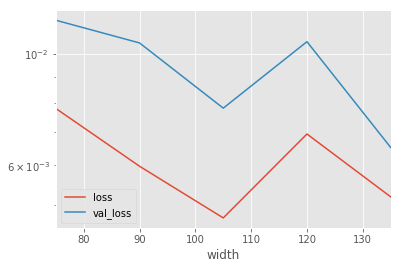

In [70]:
pd.DataFrame(width3_perf).loc[:,['width','mse','val_mse']].set_index('width').plot(logy=True)

### Final run for 1 layer
Conclusion 1 layer of about 135 seems best, let's see if we can improve with another layer.  
Because there can be a bit of variance, let's do a few runs first.

In [60]:
width1 = 135

In [61]:
rerun1_perf = []
prev_weights = []
for run in range(3):
    fit, results, prev_weights = run_depth1(width1, learningrates2, None, "finalFirst")
    results['run']=run
    rerun1_perf.append(results)
    print rerun1_perf

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, None, 135)         74520     
_________________________________________________________________
time_distributed_14 (TimeDis (None, None, 1)           136       
Total params: 74,656
Trainable params: 74,656
Non-trainable params: 0
_________________________________________________________________
Train on 1 samples, validate on 1 samples
Epoch 1/1000
1s - loss: 1.0755 - mse: 936.5521 - val_loss: 0.5915 - val_mse: 515.1248
Epoch 2/1000
0s - loss: 0.5472 - mse: 476.5555 - val_loss: 0.2828 - val_mse: 246.3094
Epoch 3/1000
0s - loss: 0.2685 - mse: 233.7912 - val_loss: 0.3783 - val_mse: 329.4532
Epoch 4/1000
0s - loss: 0.3844 - mse: 334.7589 - val_loss: 0.2879 - val_mse: 250.6860
Epoch 5/1000
0s - loss: 0.2867 - mse: 249.6930 - val_loss: 0.2523 - val_mse: 219.7462
Epoch 6/1000
0s - loss: 0.2356 - mse: 205.1404 - val_loss: 0.2

0s - loss: 0.0202 - mse: 17.5965 - val_loss: 0.0222 - val_mse: 19.3455
Epoch 91/1000
0s - loss: 0.0199 - mse: 17.3221 - val_loss: 0.0219 - val_mse: 19.1021
Epoch 92/1000
0s - loss: 0.0196 - mse: 17.0465 - val_loss: 0.0216 - val_mse: 18.8010
Epoch 93/1000
0s - loss: 0.0193 - mse: 16.7921 - val_loss: 0.0214 - val_mse: 18.6591
Epoch 94/1000
0s - loss: 0.0191 - mse: 16.5944 - val_loss: 0.0211 - val_mse: 18.4037
Epoch 95/1000
0s - loss: 0.0190 - mse: 16.5289 - val_loss: 0.0220 - val_mse: 19.1415
Epoch 96/1000
0s - loss: 0.0196 - mse: 17.0724 - val_loss: 0.0221 - val_mse: 19.2399
Epoch 97/1000
0s - loss: 0.0203 - mse: 17.6889 - val_loss: 0.0240 - val_mse: 20.9335
Epoch 98/1000
0s - loss: 0.0217 - mse: 18.9051 - val_loss: 0.0201 - val_mse: 17.4755
Epoch 99/1000
0s - loss: 0.0180 - mse: 15.6356 - val_loss: 0.0208 - val_mse: 18.1092
Epoch 100/1000
0s - loss: 0.0190 - mse: 16.5550 - val_loss: 0.0225 - val_mse: 19.6241
Epoch 101/1000
0s - loss: 0.0202 - mse: 17.6075 - val_loss: 0.0193 - val_mse: 

0s - loss: 0.0062 - mse: 5.4171 - val_loss: 0.0083 - val_mse: 7.2560
Epoch 187/1000
0s - loss: 0.0062 - mse: 5.3663 - val_loss: 0.0084 - val_mse: 7.2975
Epoch 188/1000
0s - loss: 0.0061 - mse: 5.2937 - val_loss: 0.0083 - val_mse: 7.2670
Epoch 189/1000
0s - loss: 0.0060 - mse: 5.2393 - val_loss: 0.0082 - val_mse: 7.1176
Epoch 190/1000
0s - loss: 0.0060 - mse: 5.2067 - val_loss: 0.0082 - val_mse: 7.1454
Epoch 191/1000
0s - loss: 0.0059 - mse: 5.1199 - val_loss: 0.0082 - val_mse: 7.1066
Epoch 192/1000
0s - loss: 0.0058 - mse: 5.0607 - val_loss: 0.0080 - val_mse: 6.9723
Epoch 193/1000
0s - loss: 0.0058 - mse: 5.0360 - val_loss: 0.0081 - val_mse: 7.0190
Epoch 194/1000
0s - loss: 0.0057 - mse: 4.9602 - val_loss: 0.0080 - val_mse: 6.9307
Epoch 195/1000
0s - loss: 0.0056 - mse: 4.8778 - val_loss: 0.0079 - val_mse: 6.8556
Epoch 196/1000
0s - loss: 0.0056 - mse: 4.8416 - val_loss: 0.0079 - val_mse: 6.9222
Epoch 197/1000
0s - loss: 0.0055 - mse: 4.8016 - val_loss: 0.0078 - val_mse: 6.7730
Epoch 1

0s - loss: 0.0033 - mse: 2.8380 - val_loss: 0.0065 - val_mse: 5.6670
Epoch 282/1000

Epoch 00281: reducing learning rate to 0.000823543069419.
0s - loss: 0.0033 - mse: 2.8303 - val_loss: 0.0065 - val_mse: 5.6604
Epoch 283/1000
0s - loss: 0.0032 - mse: 2.8224 - val_loss: 0.0065 - val_mse: 5.6558
Epoch 284/1000
0s - loss: 0.0032 - mse: 2.8170 - val_loss: 0.0065 - val_mse: 5.6514
Epoch 285/1000
0s - loss: 0.0032 - mse: 2.8118 - val_loss: 0.0065 - val_mse: 5.6482
Epoch 286/1000
0s - loss: 0.0032 - mse: 2.8064 - val_loss: 0.0065 - val_mse: 5.6461
Epoch 287/1000
0s - loss: 0.0032 - mse: 2.8009 - val_loss: 0.0065 - val_mse: 5.6441
Epoch 288/1000
0s - loss: 0.0032 - mse: 2.7956 - val_loss: 0.0065 - val_mse: 5.6405
Epoch 289/1000
0s - loss: 0.0032 - mse: 2.7903 - val_loss: 0.0065 - val_mse: 5.6354
Epoch 290/1000
0s - loss: 0.0032 - mse: 2.7850 - val_loss: 0.0065 - val_mse: 5.6299
Epoch 291/1000
0s - loss: 0.0032 - mse: 2.7796 - val_loss: 0.0065 - val_mse: 5.6260
Epoch 292/1000
0s - loss: 0.0032

0s - loss: 0.0030 - mse: 2.6019 - val_loss: 0.0063 - val_mse: 5.5098
Epoch 375/1000
0s - loss: 0.0030 - mse: 2.6013 - val_loss: 0.0063 - val_mse: 5.5093
Epoch 376/1000
0s - loss: 0.0030 - mse: 2.6007 - val_loss: 0.0063 - val_mse: 5.5088
[{'loss': 0.0029864141251891851, 'run': 0, 'dropout': 0.0, 'val_mse': 5.508796215057373, 'label': '', 'width': 135, 'mse': 2.6006863117218018, 'val_loss': 0.0063258488662540913}]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, None, 135)         74520     
_________________________________________________________________
time_distributed_15 (TimeDis (None, None, 1)           136       
Total params: 74,656
Trainable params: 74,656
Non-trainable params: 0
_________________________________________________________________
Train on 1 samples, validate on 1 samples
Epoch 1/1000
1s - loss: 0.8552 - mse: 744.7449 - val_loss: 0.5704 - val_mse:

0s - loss: 0.0209 - mse: 18.1736 - val_loss: 0.0230 - val_mse: 20.0195
Epoch 86/1000
0s - loss: 0.0206 - mse: 17.9114 - val_loss: 0.0226 - val_mse: 19.7096
Epoch 87/1000
0s - loss: 0.0202 - mse: 17.6209 - val_loss: 0.0223 - val_mse: 19.3811
Epoch 88/1000
0s - loss: 0.0199 - mse: 17.3165 - val_loss: 0.0219 - val_mse: 19.0971
Epoch 89/1000
0s - loss: 0.0195 - mse: 17.0105 - val_loss: 0.0216 - val_mse: 18.8378
Epoch 90/1000
0s - loss: 0.0192 - mse: 16.6941 - val_loss: 0.0214 - val_mse: 18.6108
Epoch 91/1000
0s - loss: 0.0188 - mse: 16.3990 - val_loss: 0.0211 - val_mse: 18.4143
Epoch 92/1000
0s - loss: 0.0186 - mse: 16.2165 - val_loss: 0.0219 - val_mse: 19.0953
Epoch 93/1000
0s - loss: 0.0194 - mse: 16.8865 - val_loss: 0.0280 - val_mse: 24.4132
Epoch 94/1000
0s - loss: 0.0264 - mse: 23.0050 - val_loss: 0.0278 - val_mse: 24.2372
Epoch 95/1000
0s - loss: 0.0256 - mse: 22.3024 - val_loss: 0.0218 - val_mse: 18.9757
Epoch 96/1000

Epoch 00095: reducing learning rate to 0.00699999984354.
1s - lo

0s - loss: 0.0080 - mse: 6.9389 - val_loss: 0.0112 - val_mse: 9.7650
Epoch 180/1000
0s - loss: 0.0083 - mse: 7.2173 - val_loss: 0.0111 - val_mse: 9.6671
Epoch 181/1000
0s - loss: 0.0083 - mse: 7.2497 - val_loss: 0.0107 - val_mse: 9.3480
Epoch 182/1000
0s - loss: 0.0078 - mse: 6.8096 - val_loss: 0.0110 - val_mse: 9.6107
Epoch 183/1000
0s - loss: 0.0079 - mse: 6.8864 - val_loss: 0.0114 - val_mse: 9.8852
Epoch 184/1000
0s - loss: 0.0080 - mse: 7.0066 - val_loss: 0.0110 - val_mse: 9.5967
Epoch 185/1000
0s - loss: 0.0077 - mse: 6.7008 - val_loss: 0.0107 - val_mse: 9.3432
Epoch 186/1000
0s - loss: 0.0076 - mse: 6.6178 - val_loss: 0.0107 - val_mse: 9.3511
Epoch 187/1000
0s - loss: 0.0078 - mse: 6.7716 - val_loss: 0.0106 - val_mse: 9.1930
Epoch 188/1000
0s - loss: 0.0075 - mse: 6.5607 - val_loss: 0.0106 - val_mse: 9.2439
Epoch 189/1000
0s - loss: 0.0074 - mse: 6.4433 - val_loss: 0.0109 - val_mse: 9.5033
Epoch 190/1000
0s - loss: 0.0075 - mse: 6.5688 - val_loss: 0.0107 - val_mse: 9.3527
Epoch 1

0s - loss: 0.0059 - mse: 5.1578 - val_loss: 0.0096 - val_mse: 8.3762
Epoch 274/1000
0s - loss: 0.0059 - mse: 5.1543 - val_loss: 0.0096 - val_mse: 8.3740
Epoch 275/1000
0s - loss: 0.0059 - mse: 5.1507 - val_loss: 0.0096 - val_mse: 8.3716
Epoch 276/1000
0s - loss: 0.0059 - mse: 5.1472 - val_loss: 0.0096 - val_mse: 8.3692
Epoch 277/1000
0s - loss: 0.0059 - mse: 5.1437 - val_loss: 0.0096 - val_mse: 8.3667
Epoch 278/1000
0s - loss: 0.0059 - mse: 5.1402 - val_loss: 0.0096 - val_mse: 8.3645
Epoch 279/1000
0s - loss: 0.0059 - mse: 5.1367 - val_loss: 0.0096 - val_mse: 8.3625
Epoch 280/1000
0s - loss: 0.0059 - mse: 5.1332 - val_loss: 0.0096 - val_mse: 8.3608
Epoch 281/1000
0s - loss: 0.0059 - mse: 5.1297 - val_loss: 0.0096 - val_mse: 8.3592
Epoch 282/1000

Epoch 00281: reducing learning rate to 0.000282475253334.
0s - loss: 0.0059 - mse: 5.1262 - val_loss: 0.0096 - val_mse: 8.3576
Epoch 283/1000
0s - loss: 0.0059 - mse: 5.1227 - val_loss: 0.0096 - val_mse: 8.3564
Epoch 284/1000
0s - loss: 0.0059

0s - loss: 0.0450 - mse: 39.2060 - val_loss: 0.0481 - val_mse: 41.9116
Epoch 35/1000
0s - loss: 0.0430 - mse: 37.4340 - val_loss: 0.0475 - val_mse: 41.3354
Epoch 36/1000
0s - loss: 0.0431 - mse: 37.5687 - val_loss: 0.0461 - val_mse: 40.1161
Epoch 37/1000
0s - loss: 0.0415 - mse: 36.1256 - val_loss: 0.0457 - val_mse: 39.7917
Epoch 38/1000
0s - loss: 0.0405 - mse: 35.3112 - val_loss: 0.0442 - val_mse: 38.4877
Epoch 39/1000
0s - loss: 0.0389 - mse: 33.9057 - val_loss: 0.0432 - val_mse: 37.5834
Epoch 40/1000
0s - loss: 0.0382 - mse: 33.2524 - val_loss: 0.0419 - val_mse: 36.5056
Epoch 41/1000
0s - loss: 0.0372 - mse: 32.4365 - val_loss: 0.0409 - val_mse: 35.5838
Epoch 42/1000
0s - loss: 0.0365 - mse: 31.7578 - val_loss: 0.0399 - val_mse: 34.7357
Epoch 43/1000
0s - loss: 0.0359 - mse: 31.2292 - val_loss: 0.0381 - val_mse: 33.2092
Epoch 44/1000
0s - loss: 0.0345 - mse: 30.0559 - val_loss: 0.0371 - val_mse: 32.2791
Epoch 45/1000
0s - loss: 0.0337 - mse: 29.3726 - val_loss: 0.0362 - val_mse: 31

0s - loss: 0.0105 - mse: 9.1106 - val_loss: 0.0129 - val_mse: 11.2666
Epoch 131/1000
0s - loss: 0.0104 - mse: 9.0344 - val_loss: 0.0127 - val_mse: 11.0829
Epoch 132/1000
0s - loss: 0.0103 - mse: 8.9342 - val_loss: 0.0126 - val_mse: 10.9886
Epoch 133/1000
0s - loss: 0.0101 - mse: 8.8359 - val_loss: 0.0126 - val_mse: 10.9947
Epoch 134/1000
0s - loss: 0.0101 - mse: 8.7675 - val_loss: 0.0125 - val_mse: 10.8679
Epoch 135/1000
0s - loss: 0.0099 - mse: 8.6559 - val_loss: 0.0124 - val_mse: 10.7616
Epoch 136/1000
0s - loss: 0.0099 - mse: 8.6023 - val_loss: 0.0123 - val_mse: 10.6737
Epoch 137/1000
0s - loss: 0.0098 - mse: 8.4970 - val_loss: 0.0122 - val_mse: 10.6160
Epoch 138/1000
0s - loss: 0.0097 - mse: 8.4339 - val_loss: 0.0121 - val_mse: 10.5100
Epoch 139/1000
0s - loss: 0.0096 - mse: 8.3552 - val_loss: 0.0120 - val_mse: 10.4485
Epoch 140/1000
0s - loss: 0.0095 - mse: 8.2723 - val_loss: 0.0120 - val_mse: 10.4102
Epoch 141/1000
0s - loss: 0.0094 - mse: 8.2158 - val_loss: 0.0118 - val_mse: 10.

0s - loss: 0.0058 - mse: 5.0242 - val_loss: 0.0081 - val_mse: 7.0926
Epoch 227/1000
0s - loss: 0.0057 - mse: 4.9922 - val_loss: 0.0081 - val_mse: 7.0943
Epoch 228/1000
0s - loss: 0.0057 - mse: 4.9849 - val_loss: 0.0081 - val_mse: 7.0889
Epoch 229/1000

Epoch 00228: reducing learning rate to 0.00240100002848.
0s - loss: 0.0057 - mse: 4.9543 - val_loss: 0.0081 - val_mse: 7.0843
Epoch 230/1000
0s - loss: 0.0057 - mse: 4.9446 - val_loss: 0.0081 - val_mse: 7.0520
Epoch 231/1000
0s - loss: 0.0057 - mse: 4.9242 - val_loss: 0.0081 - val_mse: 7.0266
Epoch 232/1000
0s - loss: 0.0056 - mse: 4.9117 - val_loss: 0.0081 - val_mse: 7.0211
Epoch 233/1000
0s - loss: 0.0056 - mse: 4.9019 - val_loss: 0.0081 - val_mse: 7.0211
Epoch 234/1000
0s - loss: 0.0056 - mse: 4.8821 - val_loss: 0.0081 - val_mse: 7.0277
Epoch 235/1000
0s - loss: 0.0056 - mse: 4.8732 - val_loss: 0.0081 - val_mse: 7.0114
Epoch 236/1000
0s - loss: 0.0056 - mse: 4.8579 - val_loss: 0.0080 - val_mse: 6.9837
Epoch 237/1000
0s - loss: 0.0056 

0s - loss: 0.0050 - mse: 4.3555 - val_loss: 0.0076 - val_mse: 6.6242
Epoch 320/1000
0s - loss: 0.0050 - mse: 4.3537 - val_loss: 0.0076 - val_mse: 6.6232
Epoch 321/1000
0s - loss: 0.0050 - mse: 4.3520 - val_loss: 0.0076 - val_mse: 6.6221
Epoch 322/1000
0s - loss: 0.0050 - mse: 4.3502 - val_loss: 0.0076 - val_mse: 6.6209
Epoch 323/1000
0s - loss: 0.0050 - mse: 4.3485 - val_loss: 0.0076 - val_mse: 6.6199
Epoch 324/1000
0s - loss: 0.0050 - mse: 4.3467 - val_loss: 0.0076 - val_mse: 6.6187
Epoch 325/1000
0s - loss: 0.0050 - mse: 4.3449 - val_loss: 0.0076 - val_mse: 6.6175
Epoch 326/1000
0s - loss: 0.0050 - mse: 4.3432 - val_loss: 0.0076 - val_mse: 6.6163
Epoch 327/1000

Epoch 00326: reducing learning rate to 0.000197732681409.
0s - loss: 0.0050 - mse: 4.3414 - val_loss: 0.0076 - val_mse: 6.6151
Epoch 328/1000
0s - loss: 0.0050 - mse: 4.3397 - val_loss: 0.0076 - val_mse: 6.6144
Epoch 329/1000
0s - loss: 0.0050 - mse: 4.3384 - val_loss: 0.0076 - val_mse: 6.6138
Epoch 330/1000
0s - loss: 0.0050

0    5.508796
1    8.324284
2    6.606920
Name: val_mse, dtype: float64
6.81333335241


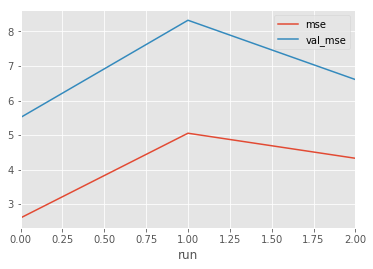

In [65]:
print pd.DataFrame(rerun1_perf)['val_mse']
print np.mean(pd.DataFrame(rerun1_perf)['val_mse'])
pd.DataFrame(rerun1_perf).loc[:,['run','mse','val_mse']].set_index('run').plot()

## Adding a second layer

In [36]:
def run_depthn(layers, learning_params, initial_weights=None):
    model = Sequential()
    model.add(LSTM(layers[0]['width'], return_sequences=True, activation='tanh', input_shape=(None, 2), dropout=layers[0]['dropout']))
    if len(layers)>1:
        extra_layers = layers[1:]
        for i in range(len(extra_layers)):
            model.add(LSTM(extra_layers[i]['width'], return_sequences=True, activation='tanh', dropout=extra_layers[i]['dropout']))
    model.add(TimeDistributed(Dense(1, activation='linear')))
    optimizer = keras.optimizers.Adam(lr=learning_params['lr_intial'], 
                                      beta_1=0.9, 
                                      beta_2=0.999, 
                                      epsilon=1e-08, 
                                      decay=learning_params['lr_decay'])
    model.compile(loss='mean_squared_error', 
                  optimizer=optimizer, 
                  metrics=[mse])
    if not initial_weights is None:
        assign_weights(model, initial_weights)   
    model.summary()

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  cooldown=learning_params['lr_plateau_cooldown'], 
                                  factor=learning_params['lr_plateau_factor'], 
                                  patience=learning_params['lr_plateau_patience'], 
                                  min_lr=learning_params['lr_minimum'],
                                  verbose=1)
    tensor_board = TensorBoard(log_dir="../tensorboardlog/depthn{}_{}".format(
        len(layers),
        "_".join(["width{}x{}".format(l['width'],l['dropout']) for l in layers])))
    early_stopping = EarlyStopping(monitor='val_loss', 
                                   min_delta=learning_params['stop_delta'],
                                   patience=learning_params['stop_patience'], 
                                   verbose=0, 
                                   mode='auto')
    
    fit = model.fit(X_train_p[:,i_fit,:], 
                    y_train_p[:,i_fit,:], 
                    epochs=learning_params['epochs_max'], 
                    validation_data=(X_train_p, y_train_p),
                    verbose=2, 
                    callbacks=[reduce_lr, early_stopping, tensor_board]
                   )
    result_widths = {'width{}'.format(i):y['width'] for i,y in enumerate(layers)}
    result_dropouts = {'dropout{}'.format(i):y['dropout'] for i,y in enumerate(layers)}
    result_values = {'val_mse':fit.history['val_mse'][-1],
                       'val_loss':fit.history['val_loss'][-1],
                       'mse':fit.history['mse'][-1],
                       'loss':fit.history['loss'][-1],
                      }
    results = result_widths.copy()
    results.update(result_dropouts)
    results.update(result_values)
    return fit, results, [layer.get_weights() for layer in model.layers]

In [38]:
width1 = 135
dropout_perf = []
prev_weights = []
for width2 in range(75, 151, 25):
        fit, results, prev_weights = run_depthn([{'width':width1, 'dropout':0},
                                                 {'width':width2, 'dropout':0}
                                                ], learningrates2, prev_weights, 'secondlayer')
        dropout_perf.append(results)
        print dropout_perf

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, None, 135)         74520     
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 75)          63300     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1)           76        
Total params: 137,896
Trainable params: 137,896
Non-trainable params: 0
_________________________________________________________________
Train on 1 samples, validate on 1 samples
Epoch 1/1000
1s - loss: 1.0955 - mse: 954.0013 - val_loss: 0.6145 - val_mse: 535.0911
Epoch 2/1000
1s - loss: 0.5657 - mse: 492.5928 - val_loss: 0.3368 - val_mse: 293.2662
Epoch 3/1000
1s - loss: 0.3268 - mse: 284.6288 - val_loss: 0.4502 - val_mse: 392.0319
Epoch 4/1000
1s - loss: 0.4492 - mse: 391.2126 - val_loss: 0.3925 - val_mse: 341.8412
Epoch 5/1000
1

1s - loss: 0.0191 - mse: 16.6055 - val_loss: 0.0212 - val_mse: 18.4782
Epoch 89/1000
1s - loss: 0.0188 - mse: 16.3419 - val_loss: 0.0208 - val_mse: 18.1142
Epoch 90/1000
1s - loss: 0.0184 - mse: 16.0379 - val_loss: 0.0204 - val_mse: 17.7434
Epoch 91/1000
1s - loss: 0.0181 - mse: 15.7433 - val_loss: 0.0201 - val_mse: 17.4796
Epoch 92/1000
1s - loss: 0.0177 - mse: 15.4461 - val_loss: 0.0198 - val_mse: 17.2791
Epoch 93/1000
1s - loss: 0.0174 - mse: 15.1648 - val_loss: 0.0203 - val_mse: 17.7142
Epoch 94/1000
1s - loss: 0.0176 - mse: 15.3375 - val_loss: 0.0248 - val_mse: 21.5963
Epoch 95/1000
1s - loss: 0.0230 - mse: 20.0441 - val_loss: 0.0522 - val_mse: 45.4415
Epoch 96/1000
1s - loss: 0.0511 - mse: 44.4965 - val_loss: 0.0255 - val_mse: 22.2342
Epoch 97/1000

Epoch 00096: reducing learning rate to 0.00699999984354.
1s - loss: 0.0252 - mse: 21.9572 - val_loss: 0.0291 - val_mse: 25.3249
Epoch 98/1000
1s - loss: 0.0287 - mse: 25.0033 - val_loss: 0.0202 - val_mse: 17.5860
Epoch 99/1000
1s - lo

1s - loss: 0.0094 - mse: 8.2102 - val_loss: 0.0127 - val_mse: 11.0366
Epoch 185/1000
1s - loss: 0.0094 - mse: 8.1518 - val_loss: 0.0126 - val_mse: 10.9969
Epoch 186/1000
1s - loss: 0.0093 - mse: 8.0932 - val_loss: 0.0126 - val_mse: 10.9579
Epoch 187/1000
1s - loss: 0.0092 - mse: 8.0353 - val_loss: 0.0125 - val_mse: 10.9130
Epoch 188/1000
1s - loss: 0.0092 - mse: 7.9774 - val_loss: 0.0125 - val_mse: 10.8741
Epoch 189/1000
1s - loss: 0.0091 - mse: 7.9197 - val_loss: 0.0125 - val_mse: 10.8585
Epoch 190/1000
1s - loss: 0.0090 - mse: 7.8625 - val_loss: 0.0124 - val_mse: 10.8409
Epoch 191/1000
1s - loss: 0.0090 - mse: 7.8057 - val_loss: 0.0124 - val_mse: 10.7952
Epoch 192/1000
1s - loss: 0.0089 - mse: 7.7490 - val_loss: 0.0123 - val_mse: 10.7437
Epoch 193/1000
1s - loss: 0.0088 - mse: 7.6934 - val_loss: 0.0123 - val_mse: 10.7169
Epoch 194/1000
1s - loss: 0.0088 - mse: 7.6379 - val_loss: 0.0123 - val_mse: 10.6925
Epoch 195/1000
1s - loss: 0.0087 - mse: 7.5824 - val_loss: 0.0122 - val_mse: 10.

1s - loss: 0.0045 - mse: 3.8871 - val_loss: 0.0078 - val_mse: 6.8245
Epoch 282/1000
1s - loss: 0.0043 - mse: 3.7589 - val_loss: 0.0080 - val_mse: 6.9885
Epoch 283/1000
1s - loss: 0.0044 - mse: 3.8156 - val_loss: 0.0084 - val_mse: 7.3278
Epoch 284/1000
1s - loss: 0.0043 - mse: 3.7141 - val_loss: 0.0085 - val_mse: 7.4254
Epoch 285/1000
1s - loss: 0.0043 - mse: 3.7525 - val_loss: 0.0080 - val_mse: 6.9331
Epoch 286/1000

Epoch 00285: reducing learning rate to 0.00343000004068.
1s - loss: 0.0042 - mse: 3.6632 - val_loss: 0.0079 - val_mse: 6.8411
Epoch 287/1000
1s - loss: 0.0042 - mse: 3.6926 - val_loss: 0.0081 - val_mse: 7.0557
Epoch 288/1000
1s - loss: 0.0042 - mse: 3.6257 - val_loss: 0.0085 - val_mse: 7.3703
Epoch 289/1000
1s - loss: 0.0042 - mse: 3.6223 - val_loss: 0.0084 - val_mse: 7.3227
Epoch 290/1000
1s - loss: 0.0042 - mse: 3.6214 - val_loss: 0.0080 - val_mse: 6.9349
Epoch 291/1000
1s - loss: 0.0041 - mse: 3.5622 - val_loss: 0.0078 - val_mse: 6.7589
Epoch 292/1000
1s - loss: 0.0041 

1s - loss: 0.0034 - mse: 2.9218 - val_loss: 0.0071 - val_mse: 6.1881
Epoch 375/1000
1s - loss: 0.0034 - mse: 2.9197 - val_loss: 0.0071 - val_mse: 6.1879
Epoch 376/1000
1s - loss: 0.0034 - mse: 2.9176 - val_loss: 0.0071 - val_mse: 6.1876
[{'loss': 0.0033503014128655195, 'width0': 135, 'width1': 75, 'val_mse': 6.1875839233398438, 'mse': 2.9175732135772705, 'val_loss': 0.007105313241481781, 'dropout1': 0, 'dropout0': 0}]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, None, 135)         74520     
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 100)         94400     
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 1)           101       
Total params: 169,021
Trainable params: 169,021
Non-trainable params: 0
____________________________________________

1s - loss: 0.0124 - mse: 10.8192 - val_loss: 0.0139 - val_mse: 12.0839
Epoch 85/1000
1s - loss: 0.0123 - mse: 10.7056 - val_loss: 0.0137 - val_mse: 11.9700
Epoch 86/1000
1s - loss: 0.0122 - mse: 10.5989 - val_loss: 0.0136 - val_mse: 11.8377
Epoch 87/1000
1s - loss: 0.0120 - mse: 10.4891 - val_loss: 0.0134 - val_mse: 11.6988
Epoch 88/1000
1s - loss: 0.0119 - mse: 10.3772 - val_loss: 0.0133 - val_mse: 11.5766
Epoch 89/1000
1s - loss: 0.0118 - mse: 10.2726 - val_loss: 0.0132 - val_mse: 11.4754
Epoch 90/1000
1s - loss: 0.0117 - mse: 10.1726 - val_loss: 0.0131 - val_mse: 11.3838
Epoch 91/1000
1s - loss: 0.0116 - mse: 10.0693 - val_loss: 0.0130 - val_mse: 11.2947
Epoch 92/1000
1s - loss: 0.0114 - mse: 9.9645 - val_loss: 0.0129 - val_mse: 11.2103
Epoch 93/1000
1s - loss: 0.0113 - mse: 9.8650 - val_loss: 0.0128 - val_mse: 11.1293
Epoch 94/1000
1s - loss: 0.0112 - mse: 9.7696 - val_loss: 0.0127 - val_mse: 11.0473
Epoch 95/1000
1s - loss: 0.0111 - mse: 9.6725 - val_loss: 0.0126 - val_mse: 10.964

1s - loss: 0.0056 - mse: 4.8792 - val_loss: 0.0070 - val_mse: 6.0777
Epoch 182/1000
1s - loss: 0.0054 - mse: 4.6888 - val_loss: 0.0071 - val_mse: 6.1898
Epoch 183/1000
1s - loss: 0.0056 - mse: 4.8335 - val_loss: 0.0070 - val_mse: 6.1030
Epoch 184/1000
1s - loss: 0.0051 - mse: 4.4394 - val_loss: 0.0075 - val_mse: 6.5127
Epoch 185/1000
1s - loss: 0.0055 - mse: 4.8025 - val_loss: 0.0066 - val_mse: 5.7768
Epoch 186/1000
1s - loss: 0.0048 - mse: 4.2099 - val_loss: 0.0070 - val_mse: 6.1319
Epoch 187/1000
1s - loss: 0.0054 - mse: 4.7187 - val_loss: 0.0066 - val_mse: 5.7592
Epoch 188/1000
1s - loss: 0.0047 - mse: 4.1155 - val_loss: 0.0072 - val_mse: 6.2818
Epoch 189/1000
1s - loss: 0.0052 - mse: 4.5507 - val_loss: 0.0066 - val_mse: 5.7266
Epoch 190/1000

Epoch 00189: reducing learning rate to 0.00489999982528.
1s - loss: 0.0047 - mse: 4.0749 - val_loss: 0.0067 - val_mse: 5.8374
Epoch 191/1000
1s - loss: 0.0050 - mse: 4.3756 - val_loss: 0.0065 - val_mse: 5.6536
Epoch 192/1000
1s - loss: 0.0047 

1s - loss: 0.0022 - mse: 1.8986 - val_loss: 0.0044 - val_mse: 3.8213
Epoch 278/1000
1s - loss: 0.0022 - mse: 1.8873 - val_loss: 0.0044 - val_mse: 3.8154
Epoch 279/1000
1s - loss: 0.0022 - mse: 1.8760 - val_loss: 0.0044 - val_mse: 3.8092
Epoch 280/1000
1s - loss: 0.0021 - mse: 1.8648 - val_loss: 0.0044 - val_mse: 3.8035
Epoch 281/1000
1s - loss: 0.0021 - mse: 1.8537 - val_loss: 0.0044 - val_mse: 3.7986
Epoch 282/1000
1s - loss: 0.0021 - mse: 1.8429 - val_loss: 0.0044 - val_mse: 3.7940
Epoch 283/1000
1s - loss: 0.0021 - mse: 1.8321 - val_loss: 0.0044 - val_mse: 3.7892
Epoch 284/1000
1s - loss: 0.0021 - mse: 1.8215 - val_loss: 0.0043 - val_mse: 3.7840
Epoch 285/1000
1s - loss: 0.0021 - mse: 1.8108 - val_loss: 0.0043 - val_mse: 3.7789
Epoch 286/1000
1s - loss: 0.0021 - mse: 1.8003 - val_loss: 0.0043 - val_mse: 3.7741
Epoch 287/1000
1s - loss: 0.0021 - mse: 1.7898 - val_loss: 0.0043 - val_mse: 3.7699
Epoch 288/1000
1s - loss: 0.0020 - mse: 1.7795 - val_loss: 0.0043 - val_mse: 3.7654
Epoch 2

1s - loss: 0.0243 - mse: 21.1778 - val_loss: 0.0269 - val_mse: 23.4660
Epoch 44/1000
1s - loss: 0.0233 - mse: 20.3313 - val_loss: 0.0259 - val_mse: 22.5641
Epoch 45/1000
1s - loss: 0.0224 - mse: 19.5024 - val_loss: 0.0252 - val_mse: 21.9371
Epoch 46/1000
1s - loss: 0.0218 - mse: 18.9891 - val_loss: 0.0246 - val_mse: 21.4416
Epoch 47/1000
1s - loss: 0.0213 - mse: 18.5825 - val_loss: 0.0239 - val_mse: 20.8044
Epoch 48/1000
1s - loss: 0.0206 - mse: 17.9585 - val_loss: 0.0231 - val_mse: 20.1063
Epoch 49/1000
1s - loss: 0.0197 - mse: 17.1882 - val_loss: 0.0226 - val_mse: 19.6486
Epoch 50/1000
1s - loss: 0.0191 - mse: 16.6200 - val_loss: 0.0223 - val_mse: 19.4194
Epoch 51/1000
1s - loss: 0.0188 - mse: 16.3294 - val_loss: 0.0218 - val_mse: 19.0276
Epoch 52/1000
1s - loss: 0.0184 - mse: 15.9959 - val_loss: 0.0210 - val_mse: 18.2989
Epoch 53/1000
1s - loss: 0.0177 - mse: 15.4392 - val_loss: 0.0202 - val_mse: 17.5655
Epoch 54/1000
1s - loss: 0.0171 - mse: 14.9102 - val_loss: 0.0197 - val_mse: 17

1s - loss: 0.0074 - mse: 6.4522 - val_loss: 0.0104 - val_mse: 9.0667
Epoch 141/1000
1s - loss: 0.0074 - mse: 6.4018 - val_loss: 0.0104 - val_mse: 9.0256
Epoch 142/1000
1s - loss: 0.0073 - mse: 6.3527 - val_loss: 0.0103 - val_mse: 8.9866
Epoch 143/1000
1s - loss: 0.0072 - mse: 6.3047 - val_loss: 0.0103 - val_mse: 8.9501
Epoch 144/1000
1s - loss: 0.0072 - mse: 6.2579 - val_loss: 0.0102 - val_mse: 8.9150
Epoch 145/1000
1s - loss: 0.0071 - mse: 6.2121 - val_loss: 0.0102 - val_mse: 8.8802
Epoch 146/1000
1s - loss: 0.0071 - mse: 6.1678 - val_loss: 0.0102 - val_mse: 8.8451
Epoch 147/1000
1s - loss: 0.0070 - mse: 6.1244 - val_loss: 0.0101 - val_mse: 8.8095
Epoch 148/1000
1s - loss: 0.0070 - mse: 6.0818 - val_loss: 0.0101 - val_mse: 8.7740
Epoch 149/1000
1s - loss: 0.0069 - mse: 6.0400 - val_loss: 0.0100 - val_mse: 8.7391
Epoch 150/1000
1s - loss: 0.0069 - mse: 5.9991 - val_loss: 0.0100 - val_mse: 8.7051
Epoch 151/1000
1s - loss: 0.0068 - mse: 5.9587 - val_loss: 0.0100 - val_mse: 8.6718
Epoch 1

1s - loss: 0.0042 - mse: 3.6872 - val_loss: 0.0072 - val_mse: 6.3132
Epoch 239/1000
1s - loss: 0.0042 - mse: 3.6672 - val_loss: 0.0072 - val_mse: 6.2890
Epoch 240/1000
1s - loss: 0.0042 - mse: 3.6472 - val_loss: 0.0072 - val_mse: 6.2653
Epoch 241/1000
1s - loss: 0.0042 - mse: 3.6275 - val_loss: 0.0072 - val_mse: 6.2424
Epoch 242/1000
1s - loss: 0.0041 - mse: 3.6077 - val_loss: 0.0071 - val_mse: 6.2200
Epoch 243/1000
1s - loss: 0.0041 - mse: 3.5879 - val_loss: 0.0071 - val_mse: 6.1981
Epoch 244/1000
1s - loss: 0.0041 - mse: 3.5684 - val_loss: 0.0071 - val_mse: 6.1763
Epoch 245/1000
1s - loss: 0.0041 - mse: 3.5491 - val_loss: 0.0071 - val_mse: 6.1546
Epoch 246/1000
1s - loss: 0.0041 - mse: 3.5299 - val_loss: 0.0070 - val_mse: 6.1328
Epoch 247/1000
1s - loss: 0.0040 - mse: 3.5103 - val_loss: 0.0070 - val_mse: 6.1115
Epoch 248/1000
1s - loss: 0.0040 - mse: 3.4911 - val_loss: 0.0070 - val_mse: 6.0903
Epoch 249/1000
1s - loss: 0.0040 - mse: 3.4724 - val_loss: 0.0070 - val_mse: 6.0693
Epoch 2

1s - loss: 0.0019 - mse: 1.6951 - val_loss: 0.0046 - val_mse: 4.0489
Epoch 337/1000
1s - loss: 0.0019 - mse: 1.6733 - val_loss: 0.0046 - val_mse: 4.0264
Epoch 338/1000
1s - loss: 0.0019 - mse: 1.6517 - val_loss: 0.0046 - val_mse: 4.0042
Epoch 339/1000
1s - loss: 0.0019 - mse: 1.6302 - val_loss: 0.0046 - val_mse: 3.9830
Epoch 340/1000
1s - loss: 0.0018 - mse: 1.6091 - val_loss: 0.0045 - val_mse: 3.9622
Epoch 341/1000
1s - loss: 0.0018 - mse: 1.5882 - val_loss: 0.0045 - val_mse: 3.9414
Epoch 342/1000
1s - loss: 0.0018 - mse: 1.5675 - val_loss: 0.0045 - val_mse: 3.9201
Epoch 343/1000
1s - loss: 0.0018 - mse: 1.5471 - val_loss: 0.0045 - val_mse: 3.8987
Epoch 344/1000
1s - loss: 0.0018 - mse: 1.5271 - val_loss: 0.0045 - val_mse: 3.8776
Epoch 345/1000
1s - loss: 0.0017 - mse: 1.5073 - val_loss: 0.0044 - val_mse: 3.8573
Epoch 346/1000
1s - loss: 0.0017 - mse: 1.4879 - val_loss: 0.0044 - val_mse: 3.8380
Epoch 347/1000
1s - loss: 0.0017 - mse: 1.4687 - val_loss: 0.0044 - val_mse: 3.8192
Epoch 3

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, None, 135)         74520     
_________________________________________________________________
lstm_10 (LSTM)               (None, None, 150)         171600    
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 1)           151       
Total params: 246,271
Trainable params: 246,271
Non-trainable params: 0
_________________________________________________________________
Train on 1 samples, validate on 1 samples
Epoch 1/1000
1s - loss: 1.0436 - mse: 908.8286 - val_loss: 1.9815 - val_mse: 1725.5627
Epoch 2/1000
1s - loss: 2.0687 - mse: 1801.5411 - val_loss: 0.5695 - val_mse: 495.9612
Epoch 3/1000
1s - loss: 0.5700 - mse: 496.3499 - val_loss: 0.6486 - val_mse: 564.8232
Epoch 4/1000
1s - loss: 0.6345 - mse: 552.5880 - val_loss: 0.5247 - val_mse: 456.9244
Epoch 5/1000

1s - loss: 0.0074 - mse: 6.4106 - val_loss: 0.0090 - val_mse: 7.8775
Epoch 90/1000
1s - loss: 0.0073 - mse: 6.3233 - val_loss: 0.0089 - val_mse: 7.7785
Epoch 91/1000
1s - loss: 0.0072 - mse: 6.2383 - val_loss: 0.0088 - val_mse: 7.6886
Epoch 92/1000
1s - loss: 0.0071 - mse: 6.1582 - val_loss: 0.0087 - val_mse: 7.6146
Epoch 93/1000
1s - loss: 0.0070 - mse: 6.0832 - val_loss: 0.0087 - val_mse: 7.5516
Epoch 94/1000
1s - loss: 0.0069 - mse: 6.0099 - val_loss: 0.0086 - val_mse: 7.4951
Epoch 95/1000
1s - loss: 0.0068 - mse: 5.9361 - val_loss: 0.0085 - val_mse: 7.4423
Epoch 96/1000
1s - loss: 0.0067 - mse: 5.8641 - val_loss: 0.0085 - val_mse: 7.3908
Epoch 97/1000
1s - loss: 0.0067 - mse: 5.7967 - val_loss: 0.0084 - val_mse: 7.3360
Epoch 98/1000
1s - loss: 0.0066 - mse: 5.7334 - val_loss: 0.0084 - val_mse: 7.2746
Epoch 99/1000
1s - loss: 0.0065 - mse: 5.6722 - val_loss: 0.0083 - val_mse: 7.2080
Epoch 100/1000
1s - loss: 0.0064 - mse: 5.6123 - val_loss: 0.0082 - val_mse: 7.1398
Epoch 101/1000
1s

1s - loss: 0.0023 - mse: 2.0267 - val_loss: 0.0045 - val_mse: 3.9372
Epoch 188/1000
1s - loss: 0.0023 - mse: 1.9960 - val_loss: 0.0045 - val_mse: 3.9109
Epoch 189/1000
1s - loss: 0.0023 - mse: 1.9661 - val_loss: 0.0045 - val_mse: 3.8850
Epoch 190/1000
1s - loss: 0.0022 - mse: 1.9369 - val_loss: 0.0044 - val_mse: 3.8593
Epoch 191/1000
1s - loss: 0.0022 - mse: 1.9084 - val_loss: 0.0044 - val_mse: 3.8342
Epoch 192/1000
1s - loss: 0.0022 - mse: 1.8806 - val_loss: 0.0044 - val_mse: 3.8093
Epoch 193/1000
1s - loss: 0.0021 - mse: 1.8535 - val_loss: 0.0043 - val_mse: 3.7847
Epoch 194/1000
1s - loss: 0.0021 - mse: 1.8270 - val_loss: 0.0043 - val_mse: 3.7605
Epoch 195/1000
1s - loss: 0.0021 - mse: 1.8012 - val_loss: 0.0043 - val_mse: 3.7367
Epoch 196/1000
1s - loss: 0.0020 - mse: 1.7762 - val_loss: 0.0043 - val_mse: 3.7131
Epoch 197/1000
1s - loss: 0.0020 - mse: 1.7518 - val_loss: 0.0042 - val_mse: 3.6898
Epoch 198/1000
1s - loss: 0.0020 - mse: 1.7280 - val_loss: 0.0042 - val_mse: 3.6669
Epoch 1

1s - loss: 0.0012 - mse: 1.0204 - val_loss: 0.0034 - val_mse: 2.9193
Epoch 283/1000
1s - loss: 0.0012 - mse: 1.0190 - val_loss: 0.0034 - val_mse: 2.9176
Epoch 284/1000
1s - loss: 0.0012 - mse: 1.0176 - val_loss: 0.0033 - val_mse: 2.9158
Epoch 285/1000
1s - loss: 0.0012 - mse: 1.0162 - val_loss: 0.0033 - val_mse: 2.9140
[{'loss': 0.0033503014128655195, 'width0': 135, 'width1': 75, 'val_mse': 6.1875839233398438, 'mse': 2.9175732135772705, 'val_loss': 0.007105313241481781, 'dropout1': 0, 'dropout0': 0}, {'loss': 0.0018494370160624385, 'width0': 135, 'width1': 100, 'val_mse': 3.698413610458374, 'mse': 1.6105610132217407, 'val_loss': 0.0042469552718102932, 'dropout1': 0, 'dropout0': 0}, {'loss': 0.00098988576792180538, 'width0': 135, 'width1': 125, 'val_mse': 3.1876635551452637, 'mse': 0.8620307445526123, 'val_loss': 0.0036604509223252535, 'dropout1': 0, 'dropout0': 0}, {'loss': 0.0011669626692309976, 'width0': 135, 'width1': 150, 'val_mse': 2.914015531539917, 'mse': 1.0162359476089478, 'va

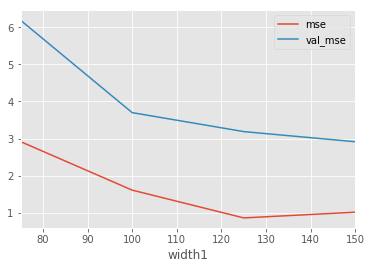

In [43]:
pd.DataFrame(dropout_perf).loc[:,['width1','mse','val_mse']].set_index('width1').plot()#logy=True)

### Final run for 2 layers (no dropout)
If we add a second layer, 150 seems a good choice.

In [49]:
learningrates3 = {
    'lr_intial' : 1e-2, # higher than the default
    'lr_decay' : 0.01, # for adam it is 1 / (1 + decay * t) , thus with decay 0.001 and at t==1000, lr is divided by 2
                    # note that the effect of this decay is not visible in tensorboard
    'lr_plateau_factor' : 0.7, # if no convergence (possibly by too high lr), we boost the lr decay
    'lr_plateau_patience' : 4, # nr of consequetive epochs without improvement before we boost the lr decay
    'lr_plateau_cooldown' : 10, # first do this nr of iterations at new lr before detecting plateau
    'lr_minimum' : 1e-6, # the minimum lr too which we decay (for plateau detection)

    'stop_patience' : 50, # if no extra improvement after this nr of steps , we terminate learning
    'stop_delta' : 0.0001, # the epsilon, changes below this threshold are 'no improvement'

    'epochs_max' : 1000 # limit the total nr op epochs, very high, we will stop based on plateau
}

In [51]:
width1 = 135
width2 = 150
rerun_perf = []
prev_weights = []
for run in range(3):
    fit, results, prev_weights = run_depthn([{'width':width1, 'dropout':0},
                                             {'width':width2, 'dropout':0}
                                            ], learningrates3, None, 'final2nd') # No prev_weights
    results['run']=run
    rerun_perf.append(results)
    print rerun_perf

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, None, 135)         74520     
_________________________________________________________________
lstm_22 (LSTM)               (None, None, 150)         171600    
_________________________________________________________________
time_distributed_11 (TimeDis (None, None, 1)           151       
Total params: 246,271
Trainable params: 246,271
Non-trainable params: 0
_________________________________________________________________
Train on 1 samples, validate on 1 samples
Epoch 1/1000
1s - loss: 0.9382 - mse: 817.0059 - val_loss: 0.6523 - val_mse: 568.0666
Epoch 2/1000
1s - loss: 0.6038 - mse: 525.8548 - val_loss: 0.6912 - val_mse: 601.9639
Epoch 3/1000
1s - loss: 0.6882 - mse: 599.2872 - val_loss: 0.4110 - val_mse: 357.9218
Epoch 4/1000
1s - loss: 0.3912 - mse: 340.7106 - val_loss: 0.9569 - val_mse: 833.3126
Epoch 5/1000
1

1s - loss: 0.0153 - mse: 13.3589 - val_loss: 0.0223 - val_mse: 19.3825
Epoch 89/1000
1s - loss: 0.0176 - mse: 15.2995 - val_loss: 0.0203 - val_mse: 17.7148
Epoch 90/1000
1s - loss: 0.0151 - mse: 13.1099 - val_loss: 0.0218 - val_mse: 18.9584
Epoch 91/1000
1s - loss: 0.0164 - mse: 14.2835 - val_loss: 0.0199 - val_mse: 17.3314
Epoch 92/1000
1s - loss: 0.0147 - mse: 12.8227 - val_loss: 0.0207 - val_mse: 18.0048
Epoch 93/1000
1s - loss: 0.0158 - mse: 13.7808 - val_loss: 0.0195 - val_mse: 17.0052
Epoch 94/1000
1s - loss: 0.0144 - mse: 12.5543 - val_loss: 0.0202 - val_mse: 17.5737
Epoch 95/1000
1s - loss: 0.0152 - mse: 13.2150 - val_loss: 0.0188 - val_mse: 16.4061
Epoch 96/1000
1s - loss: 0.0140 - mse: 12.1929 - val_loss: 0.0194 - val_mse: 16.8516
Epoch 97/1000
1s - loss: 0.0147 - mse: 12.7790 - val_loss: 0.0185 - val_mse: 16.0857
Epoch 98/1000
1s - loss: 0.0137 - mse: 11.9114 - val_loss: 0.0189 - val_mse: 16.4951
Epoch 99/1000
1s - loss: 0.0142 - mse: 12.3293 - val_loss: 0.0182 - val_mse: 15

1s - loss: 0.0056 - mse: 4.8906 - val_loss: 0.0116 - val_mse: 10.0859
Epoch 185/1000
1s - loss: 0.0056 - mse: 4.8548 - val_loss: 0.0115 - val_mse: 9.9929
Epoch 186/1000
1s - loss: 0.0055 - mse: 4.7953 - val_loss: 0.0113 - val_mse: 9.8772
Epoch 187/1000
1s - loss: 0.0055 - mse: 4.7734 - val_loss: 0.0113 - val_mse: 9.8409
Epoch 188/1000
1s - loss: 0.0054 - mse: 4.7007 - val_loss: 0.0113 - val_mse: 9.8779
Epoch 189/1000
1s - loss: 0.0054 - mse: 4.6889 - val_loss: 0.0112 - val_mse: 9.7318
Epoch 190/1000
1s - loss: 0.0053 - mse: 4.6109 - val_loss: 0.0111 - val_mse: 9.6692
Epoch 191/1000
1s - loss: 0.0053 - mse: 4.5991 - val_loss: 0.0111 - val_mse: 9.6752
Epoch 192/1000
1s - loss: 0.0052 - mse: 4.5273 - val_loss: 0.0111 - val_mse: 9.6498
Epoch 193/1000
1s - loss: 0.0052 - mse: 4.4992 - val_loss: 0.0109 - val_mse: 9.5083
Epoch 194/1000
1s - loss: 0.0051 - mse: 4.4486 - val_loss: 0.0109 - val_mse: 9.4766
Epoch 195/1000
1s - loss: 0.0050 - mse: 4.3969 - val_loss: 0.0109 - val_mse: 9.5077
Epoch 

1s - loss: 0.0024 - mse: 2.1003 - val_loss: 0.0091 - val_mse: 7.8916
Epoch 280/1000
1s - loss: 0.0024 - mse: 2.0921 - val_loss: 0.0091 - val_mse: 7.8940
Epoch 281/1000
1s - loss: 0.0024 - mse: 2.0837 - val_loss: 0.0091 - val_mse: 7.8957
Epoch 282/1000
1s - loss: 0.0024 - mse: 2.0756 - val_loss: 0.0091 - val_mse: 7.8924
Epoch 283/1000
1s - loss: 0.0024 - mse: 2.0671 - val_loss: 0.0091 - val_mse: 7.8896
Epoch 284/1000
1s - loss: 0.0024 - mse: 2.0594 - val_loss: 0.0091 - val_mse: 7.8893
Epoch 285/1000

Epoch 00284: reducing learning rate to 0.00117649007589.
1s - loss: 0.0024 - mse: 2.0515 - val_loss: 0.0091 - val_mse: 7.8871
Epoch 286/1000
1s - loss: 0.0023 - mse: 2.0437 - val_loss: 0.0091 - val_mse: 7.8844
Epoch 287/1000
1s - loss: 0.0023 - mse: 2.0380 - val_loss: 0.0091 - val_mse: 7.8816
Epoch 288/1000
1s - loss: 0.0023 - mse: 2.0322 - val_loss: 0.0090 - val_mse: 7.8802
Epoch 289/1000
1s - loss: 0.0023 - mse: 2.0268 - val_loss: 0.0090 - val_mse: 7.8801
Epoch 290/1000
1s - loss: 0.0023 

1s - loss: 0.1222 - mse: 106.4340 - val_loss: 0.1148 - val_mse: 99.9956
Epoch 14/1000
1s - loss: 0.0983 - mse: 85.5897 - val_loss: 0.1039 - val_mse: 90.4887
Epoch 15/1000
1s - loss: 0.0954 - mse: 83.0882 - val_loss: 0.1047 - val_mse: 91.1579
Epoch 16/1000
1s - loss: 0.0990 - mse: 86.2505 - val_loss: 0.0993 - val_mse: 86.4580
Epoch 17/1000
1s - loss: 0.0926 - mse: 80.6096 - val_loss: 0.0882 - val_mse: 76.8133
Epoch 18/1000
1s - loss: 0.0807 - mse: 70.3054 - val_loss: 0.0762 - val_mse: 66.3200
Epoch 19/1000
1s - loss: 0.0690 - mse: 60.1153 - val_loss: 0.0720 - val_mse: 62.6655
Epoch 20/1000
1s - loss: 0.0646 - mse: 56.2418 - val_loss: 0.0791 - val_mse: 68.9014
Epoch 21/1000
1s - loss: 0.0706 - mse: 61.4843 - val_loss: 0.0785 - val_mse: 68.3698
Epoch 22/1000
1s - loss: 0.0707 - mse: 61.6054 - val_loss: 0.0661 - val_mse: 57.5930
Epoch 23/1000
1s - loss: 0.0613 - mse: 53.4242 - val_loss: 0.0595 - val_mse: 51.8261
Epoch 24/1000
1s - loss: 0.0570 - mse: 49.6461 - val_loss: 0.0581 - val_mse: 5

1s - loss: 0.0168 - mse: 14.6101 - val_loss: 0.0177 - val_mse: 15.3800
Epoch 110/1000
1s - loss: 0.0157 - mse: 13.6562 - val_loss: 0.0164 - val_mse: 14.3213
Epoch 111/1000
1s - loss: 0.0140 - mse: 12.1778 - val_loss: 0.0187 - val_mse: 16.3168
Epoch 112/1000
1s - loss: 0.0159 - mse: 13.8586 - val_loss: 0.0178 - val_mse: 15.5315
Epoch 113/1000
1s - loss: 0.0149 - mse: 12.9494 - val_loss: 0.0160 - val_mse: 13.9111
Epoch 114/1000
1s - loss: 0.0132 - mse: 11.4882 - val_loss: 0.0170 - val_mse: 14.8402
Epoch 115/1000
1s - loss: 0.0146 - mse: 12.7350 - val_loss: 0.0163 - val_mse: 14.1539
Epoch 116/1000
1s - loss: 0.0139 - mse: 12.1022 - val_loss: 0.0155 - val_mse: 13.4886
Epoch 117/1000
1s - loss: 0.0128 - mse: 11.1259 - val_loss: 0.0164 - val_mse: 14.3227
Epoch 118/1000
1s - loss: 0.0135 - mse: 11.7685 - val_loss: 0.0160 - val_mse: 13.9109
Epoch 119/1000
1s - loss: 0.0131 - mse: 11.3800 - val_loss: 0.0152 - val_mse: 13.2628
Epoch 120/1000
1s - loss: 0.0124 - mse: 10.8067 - val_loss: 0.0153 - 

1s - loss: 0.0047 - mse: 4.1117 - val_loss: 0.0095 - val_mse: 8.2790
Epoch 207/1000
1s - loss: 0.0047 - mse: 4.0718 - val_loss: 0.0095 - val_mse: 8.2558
Epoch 208/1000
1s - loss: 0.0046 - mse: 4.0322 - val_loss: 0.0095 - val_mse: 8.2308
Epoch 209/1000
1s - loss: 0.0046 - mse: 3.9928 - val_loss: 0.0094 - val_mse: 8.2062
Epoch 210/1000
1s - loss: 0.0045 - mse: 3.9529 - val_loss: 0.0094 - val_mse: 8.1815
Epoch 211/1000
1s - loss: 0.0045 - mse: 3.9132 - val_loss: 0.0094 - val_mse: 8.1563
Epoch 212/1000
1s - loss: 0.0044 - mse: 3.8737 - val_loss: 0.0093 - val_mse: 8.1211
Epoch 213/1000
1s - loss: 0.0044 - mse: 3.8339 - val_loss: 0.0093 - val_mse: 8.0898
Epoch 214/1000
1s - loss: 0.0044 - mse: 3.7942 - val_loss: 0.0093 - val_mse: 8.0645
Epoch 215/1000
1s - loss: 0.0043 - mse: 3.7547 - val_loss: 0.0092 - val_mse: 8.0421
Epoch 216/1000
1s - loss: 0.0043 - mse: 3.7152 - val_loss: 0.0092 - val_mse: 8.0242
Epoch 217/1000
1s - loss: 0.0042 - mse: 3.6757 - val_loss: 0.0092 - val_mse: 7.9917
Epoch 2

1s - loss: 5.8381e-04 - mse: 0.5084 - val_loss: 0.0060 - val_mse: 5.2665
Epoch 303/1000
1s - loss: 5.7635e-04 - mse: 0.5019 - val_loss: 0.0061 - val_mse: 5.2777
Epoch 304/1000
1s - loss: 5.6665e-04 - mse: 0.4935 - val_loss: 0.0061 - val_mse: 5.2783
Epoch 305/1000
1s - loss: 5.5929e-04 - mse: 0.4870 - val_loss: 0.0060 - val_mse: 5.2575
Epoch 306/1000

Epoch 00305: reducing learning rate to 0.00240100002848.
1s - loss: 5.5183e-04 - mse: 0.4806 - val_loss: 0.0060 - val_mse: 5.2576
Epoch 307/1000
1s - loss: 5.4385e-04 - mse: 0.4736 - val_loss: 0.0060 - val_mse: 5.2612
Epoch 308/1000
1s - loss: 5.3925e-04 - mse: 0.4696 - val_loss: 0.0060 - val_mse: 5.2555
Epoch 309/1000
1s - loss: 5.3420e-04 - mse: 0.4652 - val_loss: 0.0060 - val_mse: 5.2477
Epoch 310/1000
1s - loss: 5.2989e-04 - mse: 0.4614 - val_loss: 0.0060 - val_mse: 5.2475
Epoch 311/1000
1s - loss: 5.2522e-04 - mse: 0.4574 - val_loss: 0.0060 - val_mse: 5.2512
Epoch 312/1000
1s - loss: 5.2095e-04 - mse: 0.4537 - val_loss: 0.0060 - val_m

1s - loss: 0.0498 - mse: 43.3686 - val_loss: 0.0535 - val_mse: 46.6037
Epoch 36/1000
1s - loss: 0.0476 - mse: 41.4196 - val_loss: 0.0505 - val_mse: 43.9972
Epoch 37/1000
1s - loss: 0.0456 - mse: 39.6868 - val_loss: 0.0499 - val_mse: 43.4200
Epoch 38/1000
1s - loss: 0.0456 - mse: 39.7409 - val_loss: 0.0486 - val_mse: 42.2850
Epoch 39/1000
1s - loss: 0.0447 - mse: 38.9673 - val_loss: 0.0461 - val_mse: 40.1202
Epoch 40/1000
1s - loss: 0.0425 - mse: 36.9789 - val_loss: 0.0447 - val_mse: 38.9285
Epoch 41/1000
1s - loss: 0.0410 - mse: 35.7250 - val_loss: 0.0445 - val_mse: 38.7271
Epoch 42/1000
1s - loss: 0.0407 - mse: 35.4242 - val_loss: 0.0431 - val_mse: 37.5181
Epoch 43/1000
1s - loss: 0.0396 - mse: 34.4503 - val_loss: 0.0405 - val_mse: 35.2524
Epoch 44/1000
1s - loss: 0.0375 - mse: 32.6942 - val_loss: 0.0388 - val_mse: 33.7867
Epoch 45/1000
1s - loss: 0.0363 - mse: 31.5892 - val_loss: 0.0384 - val_mse: 33.4142
Epoch 46/1000
1s - loss: 0.0359 - mse: 31.2520 - val_loss: 0.0378 - val_mse: 32

1s - loss: 0.0100 - mse: 8.6981 - val_loss: 0.0148 - val_mse: 12.9040
Epoch 133/1000
1s - loss: 0.0096 - mse: 8.3177 - val_loss: 0.0149 - val_mse: 12.9654
Epoch 134/1000
1s - loss: 0.0097 - mse: 8.4349 - val_loss: 0.0150 - val_mse: 13.0240
Epoch 135/1000
1s - loss: 0.0094 - mse: 8.2211 - val_loss: 0.0148 - val_mse: 12.8529
Epoch 136/1000
1s - loss: 0.0093 - mse: 8.0568 - val_loss: 0.0146 - val_mse: 12.6748
Epoch 137/1000
1s - loss: 0.0093 - mse: 8.1097 - val_loss: 0.0143 - val_mse: 12.4651
Epoch 138/1000
1s - loss: 0.0090 - mse: 7.8093 - val_loss: 0.0143 - val_mse: 12.4481
Epoch 139/1000
1s - loss: 0.0089 - mse: 7.7921 - val_loss: 0.0140 - val_mse: 12.1869
Epoch 140/1000
1s - loss: 0.0089 - mse: 7.7218 - val_loss: 0.0138 - val_mse: 12.0280
Epoch 141/1000
1s - loss: 0.0086 - mse: 7.5010 - val_loss: 0.0138 - val_mse: 12.0531
Epoch 142/1000
1s - loss: 0.0086 - mse: 7.5088 - val_loss: 0.0135 - val_mse: 11.7341
Epoch 143/1000
1s - loss: 0.0085 - mse: 7.3852 - val_loss: 0.0134 - val_mse: 11.

1s - loss: 0.0039 - mse: 3.3639 - val_loss: 0.0084 - val_mse: 7.3523
Epoch 228/1000
1s - loss: 0.0038 - mse: 3.3508 - val_loss: 0.0084 - val_mse: 7.3547
Epoch 229/1000
1s - loss: 0.0038 - mse: 3.3370 - val_loss: 0.0085 - val_mse: 7.3588
Epoch 230/1000
1s - loss: 0.0038 - mse: 3.3244 - val_loss: 0.0084 - val_mse: 7.3563
Epoch 231/1000
1s - loss: 0.0038 - mse: 3.3120 - val_loss: 0.0084 - val_mse: 7.3451
Epoch 232/1000
1s - loss: 0.0038 - mse: 3.2989 - val_loss: 0.0084 - val_mse: 7.3309
Epoch 233/1000
1s - loss: 0.0038 - mse: 3.2859 - val_loss: 0.0084 - val_mse: 7.3206
Epoch 234/1000
1s - loss: 0.0038 - mse: 3.2734 - val_loss: 0.0084 - val_mse: 7.3172
Epoch 235/1000
1s - loss: 0.0037 - mse: 3.2608 - val_loss: 0.0084 - val_mse: 7.3179
Epoch 236/1000
1s - loss: 0.0037 - mse: 3.2477 - val_loss: 0.0084 - val_mse: 7.3182
Epoch 237/1000
1s - loss: 0.0037 - mse: 3.2349 - val_loss: 0.0084 - val_mse: 7.3144
Epoch 238/1000

Epoch 00237: reducing learning rate to 0.00117649007589.
1s - loss: 0.0037 

1s - loss: 0.0033 - mse: 2.8645 - val_loss: 0.0082 - val_mse: 7.1356
Epoch 322/1000
1s - loss: 0.0033 - mse: 2.8631 - val_loss: 0.0082 - val_mse: 7.1351
Epoch 323/1000
1s - loss: 0.0033 - mse: 2.8617 - val_loss: 0.0082 - val_mse: 7.1347
Epoch 324/1000
1s - loss: 0.0033 - mse: 2.8604 - val_loss: 0.0082 - val_mse: 7.1343
Epoch 325/1000

Epoch 00324: reducing learning rate to 0.000138412872911.
1s - loss: 0.0033 - mse: 2.8590 - val_loss: 0.0082 - val_mse: 7.1338
Epoch 326/1000
1s - loss: 0.0033 - mse: 2.8576 - val_loss: 0.0082 - val_mse: 7.1335
Epoch 327/1000
1s - loss: 0.0033 - mse: 2.8567 - val_loss: 0.0082 - val_mse: 7.1331
Epoch 328/1000
1s - loss: 0.0033 - mse: 2.8557 - val_loss: 0.0082 - val_mse: 7.1326
Epoch 329/1000
1s - loss: 0.0033 - mse: 2.8547 - val_loss: 0.0082 - val_mse: 7.1322
Epoch 330/1000
1s - loss: 0.0033 - mse: 2.8538 - val_loss: 0.0082 - val_mse: 7.1319
Epoch 331/1000
1s - loss: 0.0033 - mse: 2.8528 - val_loss: 0.0082 - val_mse: 7.1315
Epoch 332/1000
1s - loss: 0.0033

0    7.788837
1    5.264441
2    7.124644
Name: val_mse, dtype: float64
6.72597408295


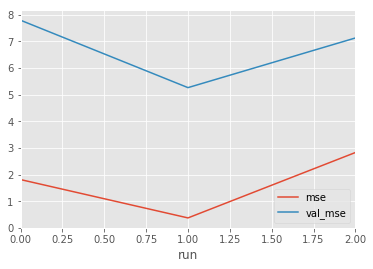

In [55]:
print pd.DataFrame(rerun_perf)['val_mse']
print np.mean(pd.DataFrame(rerun_perf)['val_mse'])
pd.DataFrame(rerun_perf).loc[:,['run','mse','val_mse']].set_index('run').plot()

## Dropout on 2nd layer?

In [63]:
dropout_patience = 2
width1 = 135
width2 = 150
dropout_perf = []
prev_weights = None
for dropout2 in np.linspace(0.0, 0.5, num=6):
    fit, results, prev_weights = run_depthn([{'width':width1, 'dropout':0},
                                             {'width':width2, 'dropout':dropout2}
                                            ], learningrates2, prev_weights, 'dropout2nd')
    dropout_perf.append(results)
    print dropout_perf
    if len(dropout_perf)>dropout_patience and \
            dropout_perf[-1]['val_mse']>np.min(x['val_mse'] for x in dropout_perf[-dropout_patience:-1]):
        break

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, None, 135)         74520     
_________________________________________________________________
lstm_31 (LSTM)               (None, None, 150)         171600    
_________________________________________________________________
time_distributed_17 (TimeDis (None, None, 1)           151       
Total params: 246,271
Trainable params: 246,271
Non-trainable params: 0
_________________________________________________________________
Train on 1 samples, validate on 1 samples
Epoch 1/1000
2s - loss: 0.9826 - mse: 855.6521 - val_loss: 0.7567 - val_mse: 658.9590
Epoch 2/1000
1s - loss: 0.7259 - mse: 632.1243 - val_loss: 0.8886 - val_mse: 773.8506
Epoch 3/1000
1s - loss: 0.8643 - mse: 752.7092 - val_loss: 0.7393 - val_mse: 643.8422
Epoch 4/1000
1s - loss: 0.7118 - mse: 619.9037 - val_loss: 0.4595 - val_mse: 400.1246
Epoch 5/1000
1

1s - loss: 0.0163 - mse: 14.1683 - val_loss: 0.0184 - val_mse: 16.0455
Epoch 89/1000
1s - loss: 0.0161 - mse: 14.0540 - val_loss: 0.0182 - val_mse: 15.8750
Epoch 90/1000
1s - loss: 0.0160 - mse: 13.9364 - val_loss: 0.0180 - val_mse: 15.6989
Epoch 91/1000
1s - loss: 0.0159 - mse: 13.8234 - val_loss: 0.0178 - val_mse: 15.5342
Epoch 92/1000
1s - loss: 0.0158 - mse: 13.7173 - val_loss: 0.0177 - val_mse: 15.3911
Epoch 93/1000
1s - loss: 0.0156 - mse: 13.6133 - val_loss: 0.0175 - val_mse: 15.2761
Epoch 94/1000
1s - loss: 0.0155 - mse: 13.5107 - val_loss: 0.0174 - val_mse: 15.1882
Epoch 95/1000
1s - loss: 0.0154 - mse: 13.4118 - val_loss: 0.0174 - val_mse: 15.1146
Epoch 96/1000
1s - loss: 0.0153 - mse: 13.3146 - val_loss: 0.0173 - val_mse: 15.0380
Epoch 97/1000
1s - loss: 0.0152 - mse: 13.2165 - val_loss: 0.0172 - val_mse: 14.9465
Epoch 98/1000
1s - loss: 0.0151 - mse: 13.1168 - val_loss: 0.0170 - val_mse: 14.8388
Epoch 99/1000
1s - loss: 0.0149 - mse: 13.0183 - val_loss: 0.0169 - val_mse: 14

1s - loss: 0.0089 - mse: 7.7229 - val_loss: 0.0119 - val_mse: 10.4000
Epoch 185/1000
1s - loss: 0.0088 - mse: 7.6851 - val_loss: 0.0119 - val_mse: 10.3750
Epoch 186/1000
1s - loss: 0.0088 - mse: 7.6473 - val_loss: 0.0119 - val_mse: 10.3507
Epoch 187/1000
1s - loss: 0.0087 - mse: 7.6099 - val_loss: 0.0119 - val_mse: 10.3278
Epoch 188/1000
1s - loss: 0.0087 - mse: 7.5728 - val_loss: 0.0118 - val_mse: 10.3058
Epoch 189/1000
1s - loss: 0.0087 - mse: 7.5358 - val_loss: 0.0118 - val_mse: 10.2840
Epoch 190/1000
1s - loss: 0.0086 - mse: 7.4990 - val_loss: 0.0118 - val_mse: 10.2634
Epoch 191/1000
1s - loss: 0.0086 - mse: 7.4625 - val_loss: 0.0118 - val_mse: 10.2436
Epoch 192/1000
1s - loss: 0.0085 - mse: 7.4263 - val_loss: 0.0117 - val_mse: 10.2245
Epoch 193/1000
1s - loss: 0.0085 - mse: 7.3909 - val_loss: 0.0117 - val_mse: 10.2050
Epoch 194/1000
1s - loss: 0.0084 - mse: 7.3561 - val_loss: 0.0117 - val_mse: 10.1848
Epoch 195/1000
1s - loss: 0.0084 - mse: 7.3217 - val_loss: 0.0117 - val_mse: 10.

1s - loss: 0.0071 - mse: 6.1676 - val_loss: 0.0110 - val_mse: 9.5942
Epoch 279/1000
1s - loss: 0.0071 - mse: 6.1643 - val_loss: 0.0110 - val_mse: 9.5928
Epoch 280/1000
1s - loss: 0.0071 - mse: 6.1609 - val_loss: 0.0110 - val_mse: 9.5915
Epoch 281/1000
1s - loss: 0.0071 - mse: 6.1576 - val_loss: 0.0110 - val_mse: 9.5902
Epoch 282/1000
1s - loss: 0.0071 - mse: 6.1543 - val_loss: 0.0110 - val_mse: 9.5889
Epoch 283/1000
1s - loss: 0.0071 - mse: 6.1509 - val_loss: 0.0110 - val_mse: 9.5874
Epoch 284/1000
1s - loss: 0.0071 - mse: 6.1476 - val_loss: 0.0110 - val_mse: 9.5859
Epoch 285/1000
1s - loss: 0.0071 - mse: 6.1442 - val_loss: 0.0110 - val_mse: 9.5842
Epoch 286/1000
1s - loss: 0.0071 - mse: 6.1409 - val_loss: 0.0110 - val_mse: 9.5825
Epoch 287/1000

Epoch 00286: reducing learning rate to 0.000576480140444.
1s - loss: 0.0070 - mse: 6.1375 - val_loss: 0.0110 - val_mse: 9.5807
Epoch 288/1000
1s - loss: 0.0070 - mse: 6.1342 - val_loss: 0.0110 - val_mse: 9.5795
Epoch 289/1000
1s - loss: 0.0070

1s - loss: 0.0334 - mse: 29.0623 - val_loss: 0.0247 - val_mse: 21.5209
Epoch 60/1000
1s - loss: 0.0266 - mse: 23.1455 - val_loss: 0.0271 - val_mse: 23.6389
Epoch 61/1000
1s - loss: 0.0219 - mse: 19.1003 - val_loss: 0.0307 - val_mse: 26.7575
Epoch 62/1000
1s - loss: 0.0294 - mse: 25.6306 - val_loss: 0.0267 - val_mse: 23.2257
Epoch 63/1000
1s - loss: 0.0226 - mse: 19.7071 - val_loss: 0.0216 - val_mse: 18.8433
Epoch 64/1000
1s - loss: 0.0208 - mse: 18.1445 - val_loss: 0.0223 - val_mse: 19.4456
Epoch 65/1000
1s - loss: 0.0215 - mse: 18.7214 - val_loss: 0.0293 - val_mse: 25.5180
Epoch 66/1000
1s - loss: 0.0328 - mse: 28.5405 - val_loss: 0.0292 - val_mse: 25.4537
Epoch 67/1000
1s - loss: 0.0246 - mse: 21.4318 - val_loss: 0.0234 - val_mse: 20.3566
Epoch 68/1000
1s - loss: 0.0215 - mse: 18.7307 - val_loss: 0.0182 - val_mse: 15.8080
Epoch 69/1000
1s - loss: 0.0161 - mse: 14.0191 - val_loss: 0.0187 - val_mse: 16.3163
Epoch 70/1000
1s - loss: 0.0175 - mse: 15.2093 - val_loss: 0.0224 - val_mse: 19

1s - loss: 0.0151 - mse: 13.1258 - val_loss: 0.0137 - val_mse: 11.9700
Epoch 153/1000
1s - loss: 0.0144 - mse: 12.5596 - val_loss: 0.0138 - val_mse: 12.0140
Epoch 154/1000
1s - loss: 0.0173 - mse: 15.0239 - val_loss: 0.0139 - val_mse: 12.0955
Epoch 155/1000
1s - loss: 0.0162 - mse: 14.0749 - val_loss: 0.0139 - val_mse: 12.0627
Epoch 156/1000
1s - loss: 0.0153 - mse: 13.3171 - val_loss: 0.0137 - val_mse: 11.9607
Epoch 157/1000
1s - loss: 0.0128 - mse: 11.1609 - val_loss: 0.0137 - val_mse: 11.9310
Epoch 158/1000
1s - loss: 0.0156 - mse: 13.6070 - val_loss: 0.0136 - val_mse: 11.8816
Epoch 159/1000
1s - loss: 0.0154 - mse: 13.4217 - val_loss: 0.0137 - val_mse: 11.9403
Epoch 160/1000
1s - loss: 0.0133 - mse: 11.6021 - val_loss: 0.0137 - val_mse: 11.9740
Epoch 161/1000

Epoch 00160: reducing learning rate to 0.000576480140444.
1s - loss: 0.0239 - mse: 20.7887 - val_loss: 0.0138 - val_mse: 11.9805
Epoch 162/1000
1s - loss: 0.0164 - mse: 14.3232 - val_loss: 0.0137 - val_mse: 11.9615
Epoch 163/

1s - loss: 0.0167 - mse: 14.5079 - val_loss: 0.0128 - val_mse: 11.1672
Epoch 245/1000
1s - loss: 0.0120 - mse: 10.4205 - val_loss: 0.0128 - val_mse: 11.1644
Epoch 246/1000
1s - loss: 0.0120 - mse: 10.4649 - val_loss: 0.0128 - val_mse: 11.1618
Epoch 247/1000
1s - loss: 0.0113 - mse: 9.8535 - val_loss: 0.0128 - val_mse: 11.1593
Epoch 248/1000
1s - loss: 0.0114 - mse: 9.9379 - val_loss: 0.0128 - val_mse: 11.1568
Epoch 249/1000
1s - loss: 0.0164 - mse: 14.2639 - val_loss: 0.0128 - val_mse: 11.1550
Epoch 250/1000
1s - loss: 0.0117 - mse: 10.1922 - val_loss: 0.0128 - val_mse: 11.1532
Epoch 251/1000
1s - loss: 0.0120 - mse: 10.4864 - val_loss: 0.0128 - val_mse: 11.1537
Epoch 252/1000
1s - loss: 0.0133 - mse: 11.5729 - val_loss: 0.0128 - val_mse: 11.1541
Epoch 253/1000
1s - loss: 0.0120 - mse: 10.4645 - val_loss: 0.0128 - val_mse: 11.1536
Epoch 254/1000

Epoch 00253: reducing learning rate to 6.78223063005e-05.
1s - loss: 0.0117 - mse: 10.1870 - val_loss: 0.0128 - val_mse: 11.1537
Epoch 255/10

1s - loss: 0.0254 - mse: 22.1567 - val_loss: 0.0297 - val_mse: 25.8897
Epoch 59/1000
1s - loss: 0.0276 - mse: 24.0626 - val_loss: 0.0259 - val_mse: 22.5807
Epoch 60/1000
1s - loss: 0.0208 - mse: 18.0932 - val_loss: 0.0233 - val_mse: 20.3061
Epoch 61/1000
1s - loss: 0.0270 - mse: 23.5155 - val_loss: 0.0217 - val_mse: 18.8891
Epoch 62/1000
1s - loss: 0.0201 - mse: 17.4971 - val_loss: 0.0216 - val_mse: 18.7969
Epoch 63/1000
1s - loss: 0.0221 - mse: 19.2375 - val_loss: 0.0226 - val_mse: 19.6703
Epoch 64/1000
1s - loss: 0.0242 - mse: 21.0603 - val_loss: 0.0241 - val_mse: 20.9925
Epoch 65/1000
1s - loss: 0.0282 - mse: 24.5539 - val_loss: 0.0259 - val_mse: 22.5775
Epoch 66/1000
1s - loss: 0.0230 - mse: 20.0683 - val_loss: 0.0292 - val_mse: 25.4181
Epoch 67/1000
1s - loss: 0.0282 - mse: 24.5328 - val_loss: 0.0312 - val_mse: 27.1657
Epoch 68/1000
1s - loss: 0.0449 - mse: 39.1367 - val_loss: 0.0299 - val_mse: 26.0358
Epoch 69/1000
1s - loss: 0.0367 - mse: 31.9237 - val_loss: 0.0270 - val_mse: 23

1s - loss: 0.0152 - mse: 13.2386 - val_loss: 0.0168 - val_mse: 14.5877
Epoch 152/1000
1s - loss: 0.0182 - mse: 15.8853 - val_loss: 0.0167 - val_mse: 14.5519
Epoch 153/1000
1s - loss: 0.0174 - mse: 15.1827 - val_loss: 0.0167 - val_mse: 14.5128
Epoch 154/1000

Epoch 00153: reducing learning rate to 0.000403536082013.
1s - loss: 0.0210 - mse: 18.2834 - val_loss: 0.0166 - val_mse: 14.4549
Epoch 155/1000
1s - loss: 0.0170 - mse: 14.8200 - val_loss: 0.0166 - val_mse: 14.4167
Epoch 156/1000
1s - loss: 0.0176 - mse: 15.3185 - val_loss: 0.0165 - val_mse: 14.3757
Epoch 157/1000
1s - loss: 0.0165 - mse: 14.4085 - val_loss: 0.0165 - val_mse: 14.3400
Epoch 158/1000
1s - loss: 0.0202 - mse: 17.5508 - val_loss: 0.0164 - val_mse: 14.3239
Epoch 159/1000
1s - loss: 0.0142 - mse: 12.3304 - val_loss: 0.0164 - val_mse: 14.3139
Epoch 160/1000
1s - loss: 0.0177 - mse: 15.3722 - val_loss: 0.0164 - val_mse: 14.3116
Epoch 161/1000
1s - loss: 0.0175 - mse: 15.2181 - val_loss: 0.0164 - val_mse: 14.3027
Epoch 162/

1s - loss: 0.0212 - mse: 18.4348 - val_loss: 0.0158 - val_mse: 13.8017
Epoch 244/1000
1s - loss: 0.0253 - mse: 22.0110 - val_loss: 0.0158 - val_mse: 13.7991
Epoch 245/1000
1s - loss: 0.0168 - mse: 14.6235 - val_loss: 0.0158 - val_mse: 13.7962
Epoch 246/1000
1s - loss: 0.0169 - mse: 14.7052 - val_loss: 0.0158 - val_mse: 13.7938
Epoch 247/1000
1s - loss: 0.0164 - mse: 14.3237 - val_loss: 0.0158 - val_mse: 13.7913
Epoch 248/1000
1s - loss: 0.0177 - mse: 15.4003 - val_loss: 0.0158 - val_mse: 13.7894
Epoch 249/1000
1s - loss: 0.0148 - mse: 12.8788 - val_loss: 0.0158 - val_mse: 13.7880
Epoch 250/1000

Epoch 00249: reducing learning rate to 4.7475615429e-05.
1s - loss: 0.0183 - mse: 15.9043 - val_loss: 0.0158 - val_mse: 13.7860
Epoch 251/1000
1s - loss: 0.0143 - mse: 12.4646 - val_loss: 0.0158 - val_mse: 13.7846
Epoch 252/1000
1s - loss: 0.0143 - mse: 12.4469 - val_loss: 0.0158 - val_mse: 13.7832
Epoch 253/1000
1s - loss: 0.0151 - mse: 13.1923 - val_loss: 0.0158 - val_mse: 13.7823
Epoch 254/1

1s - loss: 0.0224 - mse: 19.5400 - val_loss: 0.0396 - val_mse: 34.4931
Epoch 15/1000
1s - loss: 0.0319 - mse: 27.8006 - val_loss: 0.0427 - val_mse: 37.1672
Epoch 16/1000
1s - loss: 0.0285 - mse: 24.7758 - val_loss: 0.0439 - val_mse: 38.2638
Epoch 17/1000
1s - loss: 0.0657 - mse: 57.2058 - val_loss: 0.0277 - val_mse: 24.1645
Epoch 18/1000
1s - loss: 0.0284 - mse: 24.7449 - val_loss: 0.0214 - val_mse: 18.6380
Epoch 19/1000
1s - loss: 0.0225 - mse: 19.6289 - val_loss: 0.0237 - val_mse: 20.6728
Epoch 20/1000
1s - loss: 0.0410 - mse: 35.7435 - val_loss: 0.0244 - val_mse: 21.2051
Epoch 21/1000
1s - loss: 0.0282 - mse: 24.5384 - val_loss: 0.0291 - val_mse: 25.3246
Epoch 22/1000
1s - loss: 0.0370 - mse: 32.1901 - val_loss: 0.0281 - val_mse: 24.5063
Epoch 23/1000

Epoch 00022: reducing learning rate to 0.00699999984354.
3s - loss: 0.0278 - mse: 24.1676 - val_loss: 0.0263 - val_mse: 22.9400
Epoch 24/1000
1s - loss: 0.0491 - mse: 42.7247 - val_loss: 0.0261 - val_mse: 22.7434
Epoch 25/1000
1s - lo


Epoch 00107: reducing learning rate to 0.00117649007589.
1s - loss: 0.0129 - mse: 11.2024 - val_loss: 0.0124 - val_mse: 10.8048
Epoch 109/1000
1s - loss: 0.0101 - mse: 8.8000 - val_loss: 0.0130 - val_mse: 11.3466
Epoch 110/1000
1s - loss: 0.0088 - mse: 7.6826 - val_loss: 0.0135 - val_mse: 11.7688
Epoch 111/1000
1s - loss: 0.0239 - mse: 20.7758 - val_loss: 0.0135 - val_mse: 11.7367
Epoch 112/1000
1s - loss: 0.0139 - mse: 12.0674 - val_loss: 0.0132 - val_mse: 11.5131
Epoch 113/1000
2s - loss: 0.0091 - mse: 7.9033 - val_loss: 0.0130 - val_mse: 11.3313
Epoch 114/1000
1s - loss: 0.0140 - mse: 12.1734 - val_loss: 0.0126 - val_mse: 10.9788
Epoch 115/1000
1s - loss: 0.0110 - mse: 9.6159 - val_loss: 0.0121 - val_mse: 10.5362
Epoch 116/1000
1s - loss: 0.0098 - mse: 8.5213 - val_loss: 0.0116 - val_mse: 10.1082
Epoch 117/1000
1s - loss: 0.0147 - mse: 12.8303 - val_loss: 0.0112 - val_mse: 9.7637
Epoch 118/1000
1s - loss: 0.0123 - mse: 10.6811 - val_loss: 0.0107 - val_mse: 9.3461
Epoch 119/1000
1s 

1s - loss: 0.0077 - mse: 6.6725 - val_loss: 0.0078 - val_mse: 6.8189
Epoch 202/1000
1s - loss: 0.0092 - mse: 8.0158 - val_loss: 0.0078 - val_mse: 6.8185
Epoch 203/1000
1s - loss: 0.0076 - mse: 6.6221 - val_loss: 0.0078 - val_mse: 6.8211
Epoch 204/1000
1s - loss: 0.0097 - mse: 8.4686 - val_loss: 0.0078 - val_mse: 6.8196
Epoch 205/1000
1s - loss: 0.0083 - mse: 7.2489 - val_loss: 0.0078 - val_mse: 6.8174
Epoch 206/1000
1s - loss: 0.0075 - mse: 6.5733 - val_loss: 0.0078 - val_mse: 6.8132
Epoch 207/1000
1s - loss: 0.0089 - mse: 7.7938 - val_loss: 0.0078 - val_mse: 6.8102
Epoch 208/1000
1s - loss: 0.0092 - mse: 7.9942 - val_loss: 0.0078 - val_mse: 6.8061
Epoch 209/1000
1s - loss: 0.0097 - mse: 8.4698 - val_loss: 0.0078 - val_mse: 6.8069
Epoch 210/1000
1s - loss: 0.0089 - mse: 7.7169 - val_loss: 0.0078 - val_mse: 6.8061
Epoch 211/1000
1s - loss: 0.0068 - mse: 5.9218 - val_loss: 0.0078 - val_mse: 6.8075
Epoch 212/1000
1s - loss: 0.0099 - mse: 8.6459 - val_loss: 0.0078 - val_mse: 6.8078
Epoch 2

1s - loss: 0.0214 - mse: 18.6165 - val_loss: 0.0132 - val_mse: 11.4864
Epoch 37/1000
1s - loss: 0.0183 - mse: 15.9712 - val_loss: 0.0133 - val_mse: 11.6016
Epoch 38/1000
1s - loss: 0.0130 - mse: 11.2956 - val_loss: 0.0124 - val_mse: 10.8130
Epoch 39/1000
1s - loss: 0.0132 - mse: 11.5137 - val_loss: 0.0111 - val_mse: 9.6787
Epoch 40/1000
1s - loss: 0.0180 - mse: 15.6484 - val_loss: 0.0104 - val_mse: 9.0295
Epoch 41/1000

Epoch 00040: reducing learning rate to 0.00343000004068.
1s - loss: 0.0077 - mse: 6.7184 - val_loss: 0.0104 - val_mse: 9.0457
Epoch 42/1000
1s - loss: 0.0091 - mse: 7.9280 - val_loss: 0.0103 - val_mse: 8.9894
Epoch 43/1000
1s - loss: 0.0128 - mse: 11.1699 - val_loss: 0.0099 - val_mse: 8.6513
Epoch 44/1000
1s - loss: 0.0212 - mse: 18.4535 - val_loss: 0.0098 - val_mse: 8.5735
Epoch 45/1000
1s - loss: 0.0132 - mse: 11.4914 - val_loss: 0.0096 - val_mse: 8.3646
Epoch 46/1000
1s - loss: 0.0174 - mse: 15.1774 - val_loss: 0.0090 - val_mse: 7.8250
Epoch 47/1000
1s - loss: 0.0115


Epoch 00130: reducing learning rate to 0.000576480140444.
1s - loss: 0.0051 - mse: 4.4146 - val_loss: 0.0048 - val_mse: 4.1742
Epoch 132/1000
1s - loss: 0.0057 - mse: 4.9593 - val_loss: 0.0048 - val_mse: 4.1940
Epoch 133/1000
1s - loss: 0.0050 - mse: 4.3660 - val_loss: 0.0048 - val_mse: 4.2081
Epoch 134/1000
1s - loss: 0.0068 - mse: 5.9402 - val_loss: 0.0048 - val_mse: 4.2215
Epoch 135/1000
1s - loss: 0.0092 - mse: 8.0345 - val_loss: 0.0048 - val_mse: 4.2168
Epoch 136/1000
1s - loss: 0.0080 - mse: 6.9850 - val_loss: 0.0049 - val_mse: 4.2253
Epoch 137/1000
1s - loss: 0.0084 - mse: 7.3156 - val_loss: 0.0049 - val_mse: 4.2311
Epoch 138/1000
1s - loss: 0.0058 - mse: 5.0749 - val_loss: 0.0049 - val_mse: 4.2460
Epoch 139/1000
1s - loss: 0.0083 - mse: 7.2162 - val_loss: 0.0049 - val_mse: 4.2526
Epoch 140/1000
1s - loss: 0.0083 - mse: 7.2402 - val_loss: 0.0049 - val_mse: 4.2588
Epoch 141/1000
1s - loss: 0.0095 - mse: 8.2777 - val_loss: 0.0049 - val_mse: 4.2670
Epoch 142/1000
1s - loss: 0.0062

1s - loss: 0.0230 - mse: 20.0259 - val_loss: 0.0285 - val_mse: 24.7944
Epoch 28/1000
1s - loss: 0.0395 - mse: 34.4102 - val_loss: 0.0245 - val_mse: 21.3770
Epoch 29/1000
1s - loss: 0.0224 - mse: 19.4996 - val_loss: 0.0176 - val_mse: 15.3327
Epoch 30/1000
1s - loss: 0.0471 - mse: 40.9988 - val_loss: 0.0159 - val_mse: 13.8649
Epoch 31/1000
1s - loss: 0.0415 - mse: 36.1646 - val_loss: 0.0134 - val_mse: 11.7091
Epoch 32/1000
1s - loss: 0.0330 - mse: 28.7197 - val_loss: 0.0169 - val_mse: 14.6984
Epoch 33/1000
1s - loss: 0.0250 - mse: 21.7506 - val_loss: 0.0199 - val_mse: 17.3207
Epoch 34/1000
1s - loss: 0.0318 - mse: 27.7016 - val_loss: 0.0186 - val_mse: 16.2405
Epoch 35/1000
1s - loss: 0.0166 - mse: 14.4512 - val_loss: 0.0196 - val_mse: 17.0674
Epoch 36/1000

Epoch 00035: reducing learning rate to 0.00489999982528.
1s - loss: 0.0309 - mse: 26.9096 - val_loss: 0.0168 - val_mse: 14.6408
Epoch 37/1000
1s - loss: 0.0210 - mse: 18.2606 - val_loss: 0.0145 - val_mse: 12.6204
Epoch 38/1000
1s - lo

1s - loss: 0.0085 - mse: 7.3826 - val_loss: 0.0046 - val_mse: 4.0034
Epoch 123/1000
1s - loss: 0.0101 - mse: 8.8049 - val_loss: 0.0046 - val_mse: 4.0189
Epoch 124/1000

Epoch 00123: reducing learning rate to 0.000823543069419.
1s - loss: 0.0068 - mse: 5.9617 - val_loss: 0.0046 - val_mse: 4.0428
Epoch 125/1000
1s - loss: 0.0095 - mse: 8.2919 - val_loss: 0.0047 - val_mse: 4.0698
Epoch 126/1000
1s - loss: 0.0050 - mse: 4.3931 - val_loss: 0.0047 - val_mse: 4.1030
Epoch 127/1000
1s - loss: 0.0115 - mse: 10.0344 - val_loss: 0.0047 - val_mse: 4.1150
Epoch 128/1000
1s - loss: 0.0063 - mse: 5.4656 - val_loss: 0.0048 - val_mse: 4.1442
Epoch 129/1000
1s - loss: 0.0142 - mse: 12.3470 - val_loss: 0.0047 - val_mse: 4.1284
Epoch 130/1000
1s - loss: 0.0094 - mse: 8.1556 - val_loss: 0.0047 - val_mse: 4.1108
Epoch 131/1000
1s - loss: 0.0090 - mse: 7.8049 - val_loss: 0.0047 - val_mse: 4.1057
Epoch 132/1000
1s - loss: 0.0056 - mse: 4.9026 - val_loss: 0.0047 - val_mse: 4.1048
Epoch 133/1000
1s - loss: 0.01

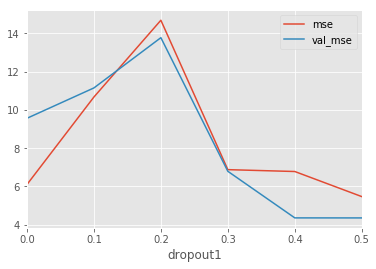

In [66]:
pd.DataFrame(dropout_perf).loc[:,['dropout1','mse','val_mse']].set_index('dropout1').plot()

no improvement....

## 5 - Model tuning
With the evaluation functions defined, we can start to create a predictive model

### First naive model
Here we create a first model, a simple linear regression.

In [ ]:
linear_regression = Pipeline([
        ("lm", linear_model.LinearRegression())
    ])

#### The quality of our first naive model:

For reference, predicting y with the original features (thus only just the soi):

In [ ]:
print "num features:{}".format(X_orig.shape[1])
print "Scores (higher is better);"
print "cv train:\t{}".format(np.mean(cross_val_train(linear_regression, X_orig.loc[X_train.index,:], y_train, cv_count=10)))
print "cv test:\t{}".format(np.mean(cross_val(linear_regression, X_orig.loc[X_train.index,:], y_train, cv_count=10)))

Probably you do much better with your new set of features.

In [ ]:
print "num features:{}".format(X.shape[1])
print "Scores (higher is better);"
print "cv train:\t{}".format(np.mean(cross_val_train(linear_regression, X, y, cv_count=10)))
print "cv test:\t{}".format(np.mean(cross_val(linear_regression, X, y, cv_count=10)))

### Choosing a different model
Feel free to select a different model, and see if you can increase the performance

In [ ]:
alternative = Pipeline([
        ("ridge", Ridge(alpha=1.0))
    ])
print "num features:\t{}".format(X.shape[1])
print "Scores (higher is better);"
print "cv train:\t{}".format(np.mean(cross_val_train(alternative, X_train, y_train, cv_count=10)))
print "cv test:\t{}".format(np.mean(cross_val(alternative, X_train, y_train, cv_count=10)))

## Model tuning
### Recommended solution for model tuning: grid search cv on meta params

Most models need some meta parameter tuning, so let us also do that:

In [ ]:
param_grid={'alpha':np.power(1.5, range(-8,4))}
display(param_grid)
ridge_cv = GridSearchCV(estimator = Ridge(),
                       param_grid=param_grid,
                       scoring=model_scorer,
                       n_jobs=1,
                       cv=GrowingWindow(4), # Usually useful to select a slightly different cv set
                       verbose=1).fit(X_train, y_train)

This resulted in the following best meta parameters:

In [ ]:
print "params:\t\t{}".format(ridge_cv.best_params_)
print "num features:\t{}".format(X.shape[1])
print "Scores (higher is better);"
print "cv train:\t{}".format(np.mean(cross_val_train(ridge_cv.best_estimator_, X_train, y_train, cv_count=10)))
print "cv test:\t{}".format(np.mean(cross_val(ridge_cv.best_estimator_, X_train, y_train, cv_count=10)))

In [ ]:
model_best = Ridge(**(ridge_cv.best_params_))

---
## 6 - Selecting features
Not all features are actually equally usefull. With too many available features, most models will have problems distinguishing noise from signal. One way is to use regularization (as used above), the other is to actually remove useless features.

### (partial) Autocorrelation
One classic way to determine usefull features is by looking at the autocorrelation, and partial autocorrelation.  
The regular autocorrelation shows the correlation of the target variable `recruit` with the lagged versions. Thus this is done by correlating the `recruit` with **just** the 1 lagged version of `recruit`, and then repeated for different lags.  
However, if lag 1 correlates, lag 2 will also correlate, because lag 2 is the 1 lagged version of lag 1.  
Therefore the partial autocorrelation plot is more usefull, as it shows the correlation, corrected for the correlation with the other lags. It can be made by applying a linear regression of the target `recruit` with **all** lagged versions in 1 model, such that the individual coefficients indicate the individual marginal effect.

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.plot_acf(y_orig.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.plot_pacf(y_orig.squeeze(), lags=40, ax=ax2)

This shows that mainly the first 2 lags of `recruit` are useful, the others are just noise. (The first one at `x==0` reflects the correlation of `recruit` with itself)

### Recommended solution for feature selection: Recursive feature elimination

The recommended solution is to iteratively remove features, a few at a time, and take the set which works best on a validation set.

First we show how `RFE` in general works:

In [ ]:
rfe = RFECV(model_best, step=5, scoring = model_scorer, cv=GrowingWindow(6))
print "Scores (higher is better) (not this selects features per fold);"
print "cv train:\t{}".format(np.mean(cross_val_train(rfe, X_train, y_train, cv_count=10)))
print "cv test:\t{}".format(np.mean(cross_val(rfe, X_train, y_train, cv_count=10)))

First we determine a fit, to get the order in which features are removed.  
In the current setup, the model is first fitted using all features. The 5 least important features are removed, and the model is refit. This is repeated until only 10 features remain. This gives an ordering of all features (the order they were removed). 

In [ ]:
rfe_fit = rfe.fit(X_train, y_train)
print rfe_fit.n_features_
print "As an example, the last remaining features were:"
X_train.loc[:, rfe_fit.ranking_<=1].head()

Now, per step, we determine the cross val score using the features that were still remaining at that step. This gives a good evaluation of those features, of which we can then select the best:

In [ ]:
rfe_all = [np.mean(cross_val(
                                model_best, 
                                X_train.loc[:, rfe_fit.ranking_<=i], 
                                y_train, 
                                cv_count=3))
     for i in range(1, max(rfe_fit.ranking_))]
best_index = np.array(rfe_all).argsort()[::-1][0]

We now define two variables to indicate the selected features:
 * `column_mask` : an indexer to be used on the pandas dataframe to select columns
 * `X_sub_train` : The full train dataset (`X_train`), but only the selected features
 * `X_sub_test` : The train dataset (`X_test`), but only the selected features

In [ ]:
column_mask = rfe_fit.ranking_<=(best_index+1)
X_sub_train = X_train.loc[:, column_mask]
X_sub_test = X_test.loc[:, column_mask]
print 'Best index          = {}'.format(best_index)
print 'Best nr of features = {}'.format(sum(column_mask))
print 'Which gives score   = {}'.format(rfe_all[best_index])

print 'Column names        = {}'.format(X_train.columns[column_mask].values)
print "Scores (higher is better);"
print "cv train:\t{}".format(np.mean(cross_val_train(model_best, X_sub_train, y_train, cv_count=10)))
print "cv test:\t{}".format(np.mean(cross_val(model_best, X_sub_train, y_train, cv_count=10)))

---
## 7 - Final score on the test set
When you are done tuning and selection, it is time to evaluate the performance on a hold out set.

To easily print the same measurements for different configurations, we define a helper function here:
> Here we multiply the `model_score` by -1 to get the score comparable to the previous cross validations  
> Note that the holdout test score will very likely be worse than the cv test score. One reason is that all meta params were selected to optimize that test score.

In [ ]:
def final_describe(model, train, test):
    """Evaluates a model on the final test set. For comparison, also (cv) measurements are given about the train set.
    model is the pandas pipeline that is evaluated
    train is the train dataset (with more/less features)
    test is the test dataset (with the same features as x_train)
    """
    # first some cross validation measurements
    print "cross validated (within train set)"
    print "cv train:\t{}".format(np.mean(cross_val_train(model, train, y_train, cv_count=10)))
    print "cv test:\t{}".format(np.mean(cross_val(model, train, y_train, cv_count=10)))
    # first fit the model on the FULL train set
    fit = model.fit(train, y_train)
    test_predictions = fit.predict(test)
    print 'full train:\t{}'.format(-model_score(y_train, fit.predict(train)))
    print "After fitting on full train set, evaluating on holdout set:"
    print 'Holdout test:\t{}'.format(-model_score(y_test, test_predictions))
    print 'Holdout r2:\t{}'.format(r2_score(y_test, test_predictions))

# Conclusion

### Best model on selected features

In [ ]:
model_best

In [ ]:
final_describe(model_best, X_sub_train, X_sub_test)

In [ ]:
fit = model_best.fit(X_sub_train, y_train)
test_predictions = fit.predict(X_sub_test)
result = pd.DataFrame({"y_pred":test_predictions, "y_real":y_test})
result.plot()

### Best model on all features

In [ ]:
final_describe(model_best, X_train, X_test)

### Alternative model on all features

In [ ]:
final_describe(alternative, X_train, X_test)

### Initial (linear) model on all features

In [ ]:
final_describe(linear_regression, X_train, X_test)